# Import nesscary packages

In [1]:
import pandas as pd   
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import seaborn as sns
import tensorflow as tf

In [2]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.utils import shuffle
from sklearn import feature_selection
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import ElasticNet,LinearRegression,Ridge
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score,GridSearchCV,KFold
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor
from sklearn import svm
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit

# Data

In [3]:
# import volve production data
df = pd.read_excel('Production_data/Volve production data.xlsx',sheet_name='Daily Production Data')

In [4]:
'''Overview of the production data (11 catogorical columns and 13 numerical columns)

# # # # Explanations

# # # # DATEPRD: Production date (daily)
# # # # WELL_BORE_CODE: ID of the well in the field
# # # # NPD_WELL_BORE_CODE: Official ID code of the wellbore
# # # # NPD_WELL_BORE_NAME: Name of the wellbore
# # # # NPD_FIELD_CODE: Field code
# # # # NPD_FIELD_NAME: Field name
# # # # NPD_FACILITY_CODE: Code for facility used
# # # # NPD_FACILITY_NAME: Facility owner name
# # # # ON_STREAM_HRS: Flow period for wells (in hours)
# # # # AVG_DOWNHOLE_PRESSURE: Average downhole pressure
# # # # AVG_DOWNHOLE_TEMPERATURE: Average downhole temperature
# # # # AVG_DP_TUBING: Average production tubing size
# # # # AVG_ANNULUS_PRESS: Average annulus pressure
# # # # AVG_CHOKE_SIZE_P: Average choke size
# # # # AVG_CHOKE_UOM: Average choke unit of measurement (%)
# # # # AVG_WHP_P: Average wellhead pressure
# # # # AVG_WHT_P: Average wellhead temperature
# # # # DP_CHOKE_SIZE: Production choke size (in mm)
# # # # BORE_OIL_VOL: Produced oil volume per day
# # # # BORE_GAS_VOL: Produced gas volume per day
# # # # BORE_WAT_VOL: Produced water volume per day
# # # # BORE_WI_VOL: Injected water volume per day
# # # # FLOW_KIND: whether producer or injector
# # # # WELL_TYPE: Same as FLOW_KIND but in code 'OP' or 'WI' '''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15634 entries, 0 to 15633
Data columns (total 24 columns):
DATEPRD                     15634 non-null datetime64[ns]
WELL_BORE_CODE              15634 non-null object
NPD_WELL_BORE_CODE          15634 non-null int64
NPD_WELL_BORE_NAME          15634 non-null object
NPD_FIELD_CODE              15634 non-null int64
NPD_FIELD_NAME              15634 non-null object
NPD_FACILITY_CODE           15634 non-null int64
NPD_FACILITY_NAME           15634 non-null object
ON_STREAM_HRS               15349 non-null float64
AVG_DOWNHOLE_PRESSURE       8980 non-null float64
AVG_DOWNHOLE_TEMPERATURE    8980 non-null float64
AVG_DP_TUBING               8980 non-null float64
AVG_ANNULUS_PRESS           7890 non-null float64
AVG_CHOKE_SIZE_P            8919 non-null float64
AVG_CHOKE_UOM               9161 non-null object
AVG_WHP_P                   9155 non-null float64
AVG_WHT_P                   9146 non-null float64
DP_CHOKE_SIZE               15340 no

In [5]:
# Set the index by production date
df.set_index('DATEPRD',inplace=True)

In [6]:
# Check how many wells in the 
df['WELL_BORE_CODE'].value_counts()

NO 15/9-F-4 AH    3327
NO 15/9-F-5 AH    3306
NO 15/9-F-14 H    3056
NO 15/9-F-12 H    3056
NO 15/9-F-11 H    1165
NO 15/9-F-15 D     978
NO 15/9-F-1 C      746
Name: WELL_BORE_CODE, dtype: int64

In [7]:
## name of numerical cols
numerical_col_name=[col for col in df.columns if df[col].dtype==float]

In [8]:
## create new dataframe with wells of type production
production_well={}
for i,j in df.groupby('WELL_BORE_CODE'):
    if np.unique(j['FLOW_KIND'])[0]=='production':
        production_well[i]=j[numerical_col_name]

In [9]:
## There are 5 producers
production_well.keys()

dict_keys(['NO 15/9-F-1 C', 'NO 15/9-F-11 H', 'NO 15/9-F-12 H', 'NO 15/9-F-14 H', 'NO 15/9-F-15 D'])

In [10]:
## store the name
name=list(production_well.keys())

In [18]:
def df_clean(df):
    """Clean the dataframe
    Input: production_well[],
    Output: cleaned dataframe"""
    
    df=df.copy()
    df.drop(['AVG_ANNULUS_PRESS','BORE_WI_VOL'],axis=1,inplace=True)
    df = df[['ON_STREAM_HRS','AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE','AVG_WHP_P', 'AVG_CHOKE_SIZE_P',\
             'BORE_OIL_VOL','BORE_GAS_VOL','BORE_WAT_VOL']]
    idx=pd.date_range(df.index[0], df.index[-1])
    
    df=df[(np.abs(stats.zscore(df,nan_policy='omit')) <3).all(axis=1)]
    df=df.reindex(idx,fill_value=np.nan)
    return df

In [ ]:
## substitute cleaned dataframe with orginal one
for i in name:
    production_well[i]=df_clean(production_well[i])

#### Func1

##### Citation: from tensorflow timeseries tutorial
https://www.tensorflow.org/tutorials/structured_data/time_series

In [27]:
def feature_target_future(dataset, target, start_index, end_index, history_size, operation_feature_index ,
                      target_size, step):
    
    """Get suitable format of time series data,
    dataset: per well dataframe
    target: col index
    start_index: index from where to start formatting
    end_index: index from where to end formatting
    history_size: timestep to look back
    operation_feature_index: col index of operation feature
    target_size: timestep to look forward,
    step: how many steps to jump"""
    
    data_1 = []
    data_2=[]
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    dataset_1=dataset[:,operation_feature_index]
    cols=set(range(dataset.shape[1]))

    dataset_2=dataset

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data_2.append(dataset_2[indices])

    for i in range(start_index, end_index):
        indices = range(i, i+target_size, step)
        data_1.append(dataset_1[indices])
        
        labels.append(target[i:i+target_size])


    return np.array(data_1).reshape(len(data_1),-1), np.array(data_2).reshape(len(data_2),-1),\
            np.array(labels).reshape(len(labels),-1)

#### Func2

In [28]:
def train_val_test(df,history_size,all_train=False):
    '''Train test split
    df: per well dataframe
    history_size: history_size
    all_train: reshape the data into one single numpy array without test'''
    
    future_target=1
    ofi=[0,4]
    if all_train==True:
        train_f1,train_f2,train_label=feature_target_future(df.values, df.values[:, [-3,-2,-1]], 0,
                                                 None, history_size,ofi,
                                                 1, step=1)
        train=np.hstack([train_f1,train_f2,train_label])
        return train

    train_stop=int(len(df)*0.8)
    
    train_f1,train_f2,train_label=feature_target_future(df.values, df.values[:, [-3,-2,-1]], 0,
                                                 train_stop, history_size,ofi,
                                                 1, step=1)

    test_f1,test_f2,test_label=feature_target_future(df.values, df.values[:, [-3,-2,-1]], train_stop,
                                                 None, history_size,ofi,
                                                 1, step=1)
    train=np.hstack([train_f1,train_f2,train_label])
    test=np.hstack([test_f1,test_f2,test_label])
    return train,test

#### funcs below can be combined together (I have no time)

In [223]:
def convert_task_3_apply(train,val,test,history_size):
    """separate combined feature set (operational feature + non-operational test)"""
    targets=[-1]
    test_targets=test[:,targets]
    test_input_1=test[:,[0,1]]
    test_input_2=test[:,2:-1].reshape(len(test),history_size,-1)
    return (test_input_1,test_input_2,test_targets)

In [135]:
def convert_task_3(train,val,test,history_size):
    """separate combined feature set (operational feature + non-operational for train, val and test)"""
    targets=[-1]
    train_targets=train[:,targets]
    val_targets=val[:,targets]
    test_targets=test[:,targets]
    train_input_1=train[:,[0,1]]
    train_input_2=train[:,2:-1].reshape(len(train),history_size,-1)
    val_input_1=val[:,[0,1]]
    val_input_2=val[:,2:-1].reshape(len(val),history_size,-1)
    test_input_1=test[:,[0,1]]
    test_input_2=test[:,2:-1].reshape(len(test),history_size,-1)
    return (train_input_1,train_input_2,train_targets),(val_input_1,val_input_2,val_targets),\
            (test_input_1,test_input_2,test_targets)

In [2018]:
def convert_task_3_only_valid(train,test,history_size):
    """separate combined feature set (operational feature + non-operational for train, and test)"""
    targets=[-1]
    train_targets=train[:,targets]
    test_targets=test[:,targets]
    train_input_1=train[:,[0,1]]
    train_input_2=train[:,2:-1].reshape(len(train),history_size,-1)
    test_input_1=test[:,[0,1]]
    test_input_2=test[:,2:-1].reshape(len(test),history_size,-1)
    return (train_input_1,train_input_2,train_targets),\
            (test_input_1,test_input_2,test_targets)

#### Func3

In [37]:
def drop_na_shutin(data):
    """clean samples with NAN value and drop samples when daily production is 0"""
    droped=data[~np.isnan(data).any(axis=1)]
    droped=droped[droped[:,0]!=0]
    return droped

#### Func4

In [51]:
def model_optimization(X_train,y_train,X_test,y_test,model,name):
    '''test different model with hyperparameter optimization'''
    if model=='BR':
        clf = linear_model.BayesianRidge()
        alpha_1=[0.01,0.0001,0.000001]
        alpha_2=[0.01,0.0001,0.000001]
        lambda_1=[0.01,0.0001,0.000001]
        lambda_2=[0.01,0.0001,0.000001]
        n_iter=[100,300,600]
        hyperparameters={'alpha_1':alpha_1,'alpha_2':alpha_2,
                       'lambda_1':lambda_1,'lambda_2': lambda_2,'n_iter': n_iter}
    if model=='RF':
        clf = RandomForestRegressor(random_state=2019)
        max_features = ['auto', 'sqrt']
        max_depth = [int(x) for x in np.linspace(1, 110, num = 11)]
        max_depth.append(None)
        min_samples_split = [2, 5, 10]
        min_samples_leaf = [1, 2, 4]
        bootstrap = [True, False]
        hyperparameters={'max_features': max_features,'max_depth': max_depth,'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf}
    if model=='AB':    
        clf = AdaBoostRegressor()
        n_estimators=[100,200,400]
        learning_rate=[0.0001,0.01,1]
        loss=['linear', 'square', 'exponential']
        hyperparameters={'n_estimators':n_estimators,'learning_rate':learning_rate
                       ,'loss':loss}
    if model=='EN':
        clf = ElasticNet(tol=0.001)
        alpha=[0.1,0.3, 0.5, 0.7, 0.9]
        l1_ratio=[0.1,0.3, 0.5, 0.7, 0.9]
        fit_intercept=[True,False]
        max_iter=[100,1000]
        hyperparameters={'alpha':alpha,'l1_ratio':l1_ratio,'fit_intercept':fit_intercept,'max_iter':max_iter}
        
    if model=='NN':
        clf = MLPRegressor(tol=0.001,random_state=2,learning_rate='adaptive')
        hidden_layer_sizes=[(64),(32),(128)]
        activation=['relu']
        alpha=[0.1,0.01]
        learning_rate_init=[0.01,0.1,0.001]
        hyperparameters={'hidden_layer_sizes':hidden_layer_sizes,'activation':activation,'alpha':alpha,\
                         'learning_rate_init':learning_rate_init}
   
    if model=='SVR':   
        clf = SVR(tol=0.001)
        hyperparameters={"C": [0.01,0.1,1e0, 1e1, 1e2,1e3,1e4],"gamma": ['scale','auto']}

    ## Cross validation
    cv = TimeSeriesSplit(n_splits=3)
    r2 = make_scorer(r2_score) ## '''might change scoring method'''
    grid_obj = GridSearchCV(clf, hyperparameters, cv=cv , scoring=r2)
    grid_fit = grid_obj.fit(X_train, y_train)
    print('Best parameter:',grid_fit.best_params_)
    best_clf = grid_fit.best_estimator_ 

    
    
    ### Test score
    best_clf.fit(X_train,y_train)
    y_test_pre=best_clf.predict(X_test)
    target_range_test=y_test.max()-y_test.min()
    test_MAE=mean_absolute_error(y_test, y_test_pre)       ### test MAE
    test_MAE_range=test_MAE/target_range_test              ### test MAE/range  
    test_MAPE=np.mean(np.abs((y_test-y_test_pre)/y_test))  ### test MAPE
    test_r2=r2_score(y_test,y_test_pre)                    ### test R2
    print('Test MAE:{}, Test MAPE:{},  Test R2:{}'.format(test_MAE,test_MAPE,test_r2))
    print('Test MAE/range:{}'.format(test_MAE_range))
    print('\n')
    
    ### Train score
    y_train_pre=best_clf.predict(X_train)
    target_range_train=y_train.max()-y_train.min()
    train_MAE=mean_absolute_error(y_train, y_train_pre)
    train_MAE_range=train_MAE/target_range_train
    train_MAPE=np.mean(np.abs((y_train-y_train_pre)/y_train))
    train_r2=r2_score(y_train,y_train_pre)

    print('Train MAE:{},  Train MAPE:{},   Train R2:{}'.format(train_MAE,train_MAPE,train_r2))
    print('Train MAE/range:{}'.format(train_MAE_range))
    
    
    fig,axes=plt.subplots(2,1,figsize=(20,10))
    axes[0].plot(y_train_pre,label='prediction')
    axes[0].set_ylabel('{}'.format(name),fontsize=20)
    axes[0].plot(y_train,label='true')
    axes[0].set_title('Train',fontsize=20)
    axes[0].legend(fontsize=15)
    
    axes[1].plot(y_test_pre,label='prediction')
    axes[1].plot(y_test,label='true')
    axes[1].set_ylabel('{}'.format(name),fontsize=20)
    axes[1].set_xlabel('''Index of samples''',fontsize=20)
    axes[1].set_title('Test',fontsize=20)
    axes[1].legend(fontsize=15)

    return best_clf

#### Func5

##### citation:
https://nbviewer.jupyter.org/github/leandrovrabelo/tsmodels/blob/master/notebooks/english/Basic%20Principles%20for%20Time%20Series%20Forecasting.ipynb

In [84]:
def check_error(orig, pred, name_col='', index_name=''):
    """Different matrics to access the model performance """
    rmse = sqrt(mean_squared_error(orig, pred))
    mae = mean_absolute_error(orig, pred)
    R2=r2_score(orig, pred)
    target_range_test=orig.max()-orig.min()
    mae_range=mae/target_range_test
    error_group = [ rmse, mae,R2,mae_range]
    serie = pd.DataFrame(error_group, index=['RMSE','MAE','R2','MAE/range'], columns=[name_col])
    serie.index.name = index_name
    
    return serie

# Task #1 (Without model updating)

In [12]:
## name_list of well of interested
name_list=np.array(name)[[2,3,1]]

In [22]:
## production date of well name_list[2]
start_date=production_well[name_list[2]].index[0]

In [24]:
## Obtain dataframe of well 1 and 2 before the production date of well name_list[2]
Before_1=production_well[name_list[0]].iloc[np.where(production_well[name_list[0]].index<start_date)[0]]
Before_2=production_well[name_list[1]].iloc[np.where(production_well[name_list[1]].index<start_date)[0]]

## Testing

In [29]:
## train test split for these two wells.
train_1,test_1=train_val_test(Before_1,1)
train_2,test_2=train_val_test(Before_2,1)

In [54]:
## group them together
train=np.vstack([train_1,train_2])
test=np.vstack([test_1,test_2])

In [55]:
## cleaning
train=drop_na_shutin(train)
test=drop_na_shutin(test)

In [42]:
## scaling
sc=StandardScaler()
sc=sc.fit(train[:,:10])
train[:,:10]=sc.transform(train[:,:10])
test[:,:10]=sc.transform(test[:,:10])

Best parameter: {'C': 10000.0, 'gamma': 'auto'}
Test MAE:57.302477117546815, Test MAPE:0.16606721272651945,  Test R2:0.677583221205236
Test MAE/range:0.03658624666718605


Train MAE:50.72294485377538,  Train MAPE:inf,   Train R2:0.9918589502742357
Train MAE/range:0.008613621171054239


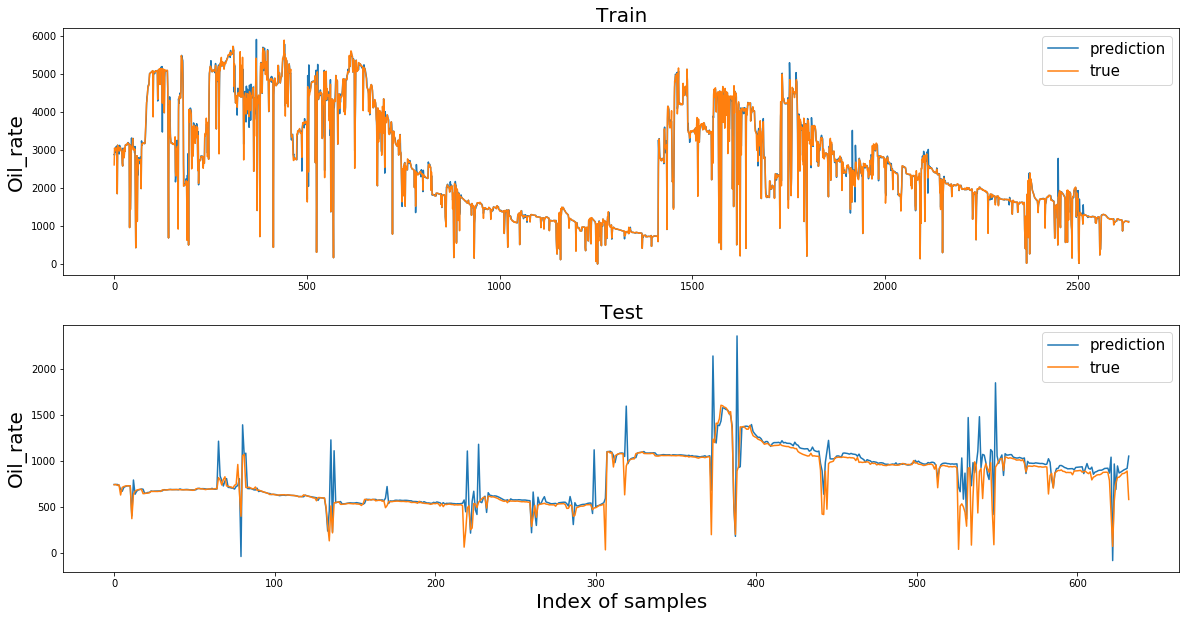

In [59]:
clf_oil=model_optimization(train[:,:10],train[:,10],test[:,:10],test[:,10],'SVR','Oil_rate')

Best parameter: {'C': 10000.0, 'gamma': 'auto'}
Test MAE:115.5567211712464, Test MAPE:0.055980031499439496,  Test R2:0.9318530240441649
Test MAE/range:0.019181608168723


Train MAE:83.38207216992157,  Train MAPE:inf,   Train R2:0.9718200129548422
Train MAE/range:0.010378740189411853


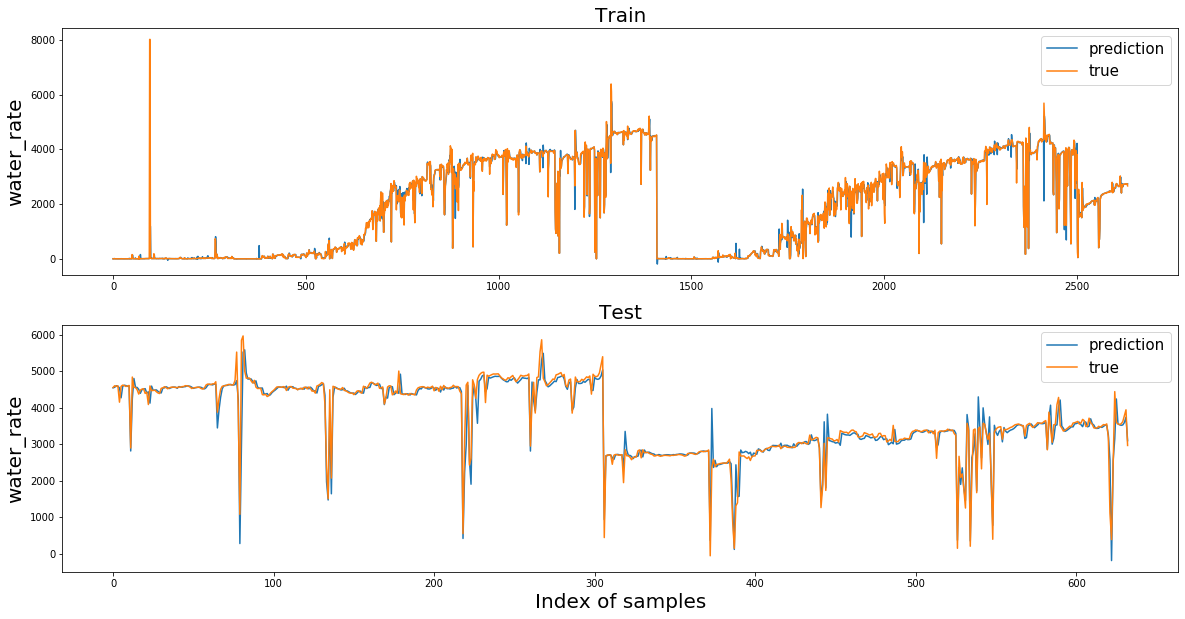

In [60]:
clf_water=model_optimization(train[:,:10],train[:,12],test[:,:10],test[:,12],'SVR','water_rate')

## Applying

In [62]:
train_1=train_val_test(Before_1,all_train=True,history_size=1)
train_2=train_val_test(Before_2,all_train=True,history_size=1)

In [64]:
train=np.vstack([train_1,train_2])

In [63]:
test=train_val_test(production_well[name_list[2]],all_train=True,history_size=1)

In [65]:
train=drop_na_shutin(train)
test=drop_na_shutin(test)

sc=StandardScaler()
sc=sc.fit(train[:,:10])
train[:,:10]=sc.transform(train[:,:10])
test[:,:10]=sc.transform(test[:,:10])

Best parameter: {'C': 10000.0, 'gamma': 'auto'}
Test MAE:99.11313380430579, Test MAPE:0.12646725728135108,  Test R2:0.8739873897136723
Test MAE/range:0.05123343730515047


Train MAE:45.8016634004139,  Train MAPE:inf,   Train R2:0.9933132020599346
Train MAE/range:0.007777903642476324


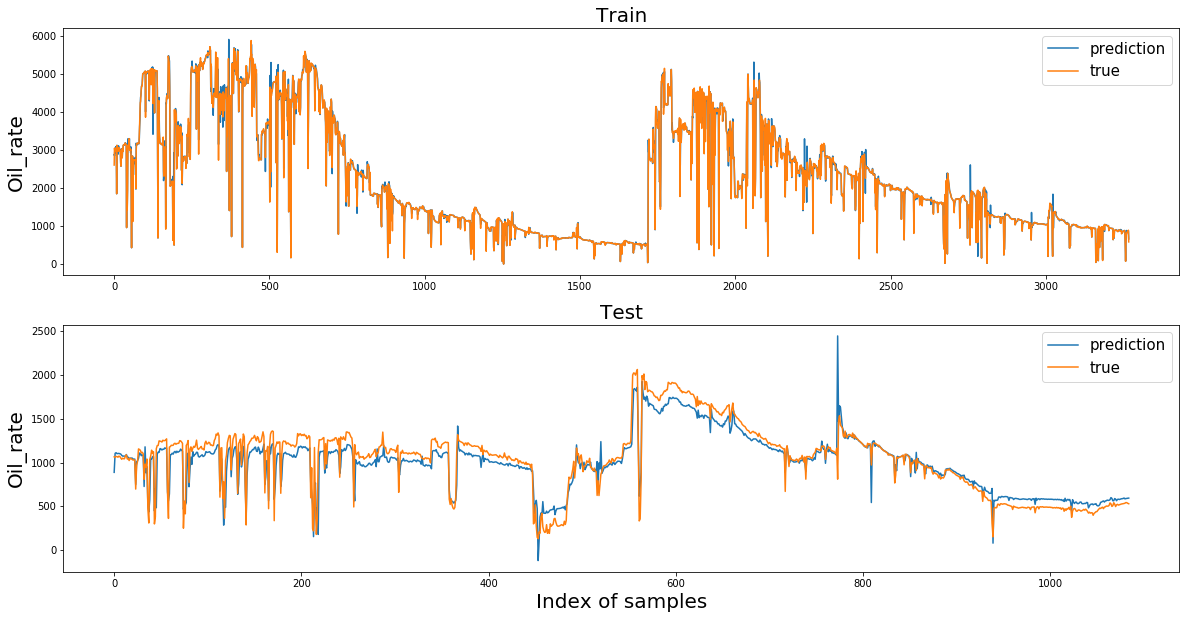

In [68]:
clfo=model_optimization(train[:,:10],train[:,10],test[:,:10],test[:,10],'SVR','Oil_rate')

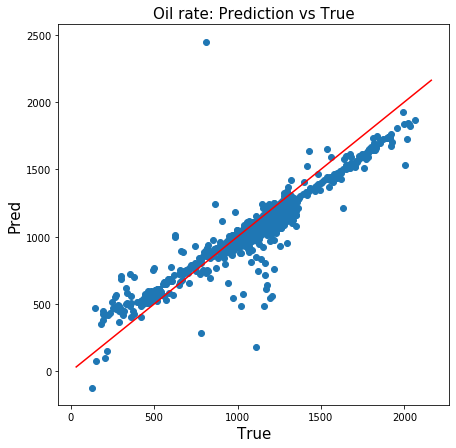

In [87]:
y_test_pre=clfo.predict(test[:,:10])
plt.figure(figsize=(7,7))
plt.title('Oil rate: Prediction vs True',fontsize=15)
plt.scatter(test[:,10],y_test_pre)
ax=plt.gca()
x = np.linspace(*ax.get_xlim())
plt.xlabel('True',fontsize=15)
plt.ylabel('Pred',fontsize=15)
ax.plot(x, x,'r')

In [88]:
check_error(test[:,10],y_test_pre)

RMSE       137.322096
MAE         99.113134
R2           0.873987
MAE/range    0.051233

Best parameter: {'C': 1000.0, 'gamma': 'auto'}
Test MAE:127.87464599940131, Test MAPE:inf,  Test R2:0.9671620502578985
Test MAE/range:0.03592317433902618


Train MAE:98.7844743910709,  Train MAPE:inf,   Train R2:0.9729104011247599
Train MAE/range:0.0122274205112646


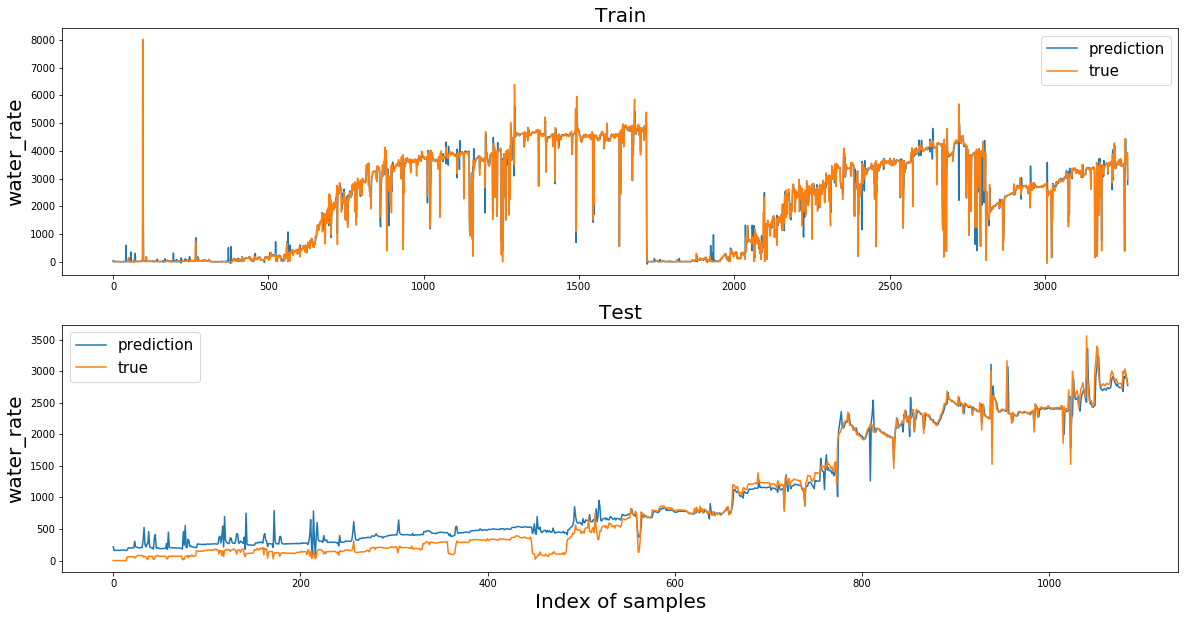

In [70]:
clfw=model_optimization(train[:,:10],train[:,12],test[:,:10],test[:,12],'SVR','water_rate')

Text(0, 0.5, 'Pred')

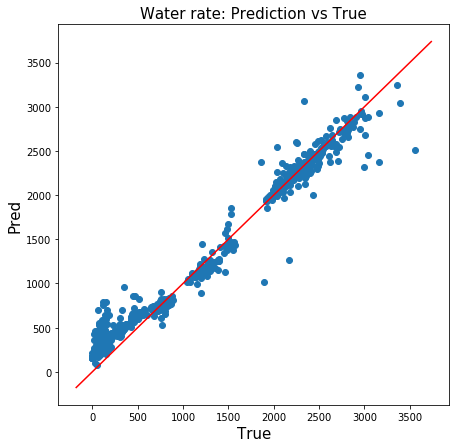

In [85]:
y_test_pre=clfw.predict(test[:,:10])
plt.figure(figsize=(7,7))
plt.title('Water rate: Prediction vs True',fontsize=15)
plt.scatter(test[:,12],y_test_pre)
ax=plt.gca()
x = np.linspace(*ax.get_xlim())
ax.plot(x, x,'r')
plt.xlabel('True',fontsize=15)
plt.ylabel('Pred',fontsize=15)
# plt.legend(fontsize=10)

In [86]:
check_error(test[:,12],y_test_pre)

RMSE       173.553320
MAE        127.874646
R2           0.967162
MAE/range    0.035923

# Task #2 (Model updating)

##  Testing

In [89]:
train_1,test_1=train_val_test(Before_1,1)
train_2,test_2=train_val_test(Before_2,1)

In [90]:
train=np.vstack([train_1,train_2])
test=np.vstack([test_1,test_2])

In [91]:
train=drop_na_shutin(train)
test=drop_na_shutin(test)

In [92]:
sc=StandardScaler()
sc=sc.fit(train[:,:10])
train[:,:10]=sc.transform(train[:,:10])
test[:,:10]=sc.transform(test[:,:10])

In [93]:
clf_oil = SVR(tol=0.001,C= 10000.0, gamma= 'auto')
clf_oil.fit(train[:,:10],train[:,10])

clf_water = SVR(tol=0.001,C= 1000.0, gamma ='auto')
clf_water.fit(train[:,:10],train[:,12])

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [94]:
prediction_oil=[]
prediction_water=[]
# train
for i in range(len(test)):
    print(i)
#     test[i].reshape(1,-1)[:,:10]=sc.transform(New_data[i][:10].reshape(1,-1))
    
    oil=clf_oil.predict(test[i].reshape(1,-1)[:,:10])
    water=clf_water.predict(test[i].reshape(1,-1)[:,:10])
    prediction_oil.append(oil)
    prediction_water.append(water)
    
    train=np.vstack([train,test[i].reshape(1,-1)])
    clf_oil.fit(train[:,:10],train[:,10])
    clf_water.fit(train[:,:10],train[:,12])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

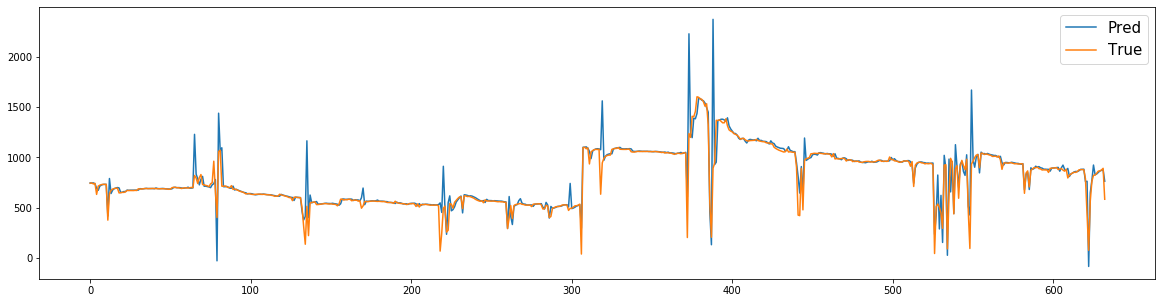

In [99]:
plt.figure(figsize=(20,5))
plt.plot(prediction_oil,label='Pred')
plt.plot(test[:,10],label='True')
plt.legend(fontsize=15)

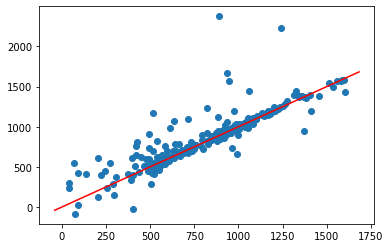

In [101]:
plt.scatter(test[:,10],prediction_oil)
ax=plt.gca()
x = np.linspace(*ax.get_xlim())
ax.plot(x, x,'r')

In [100]:
check_error(test[:,10],prediction_oil)

RMSE       113.275771
MAE         35.786533
R2           0.814530
MAE/range    0.022849

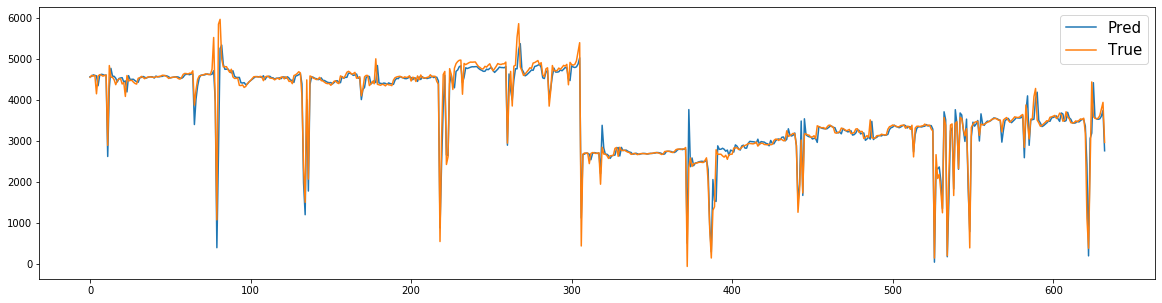

In [96]:
plt.figure(figsize=(20,5))
plt.plot(prediction_water,label='Pred')
plt.plot(test[:,12],label='True')
plt.legend(fontsize=15)

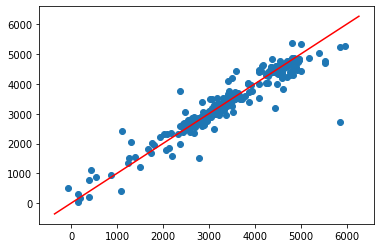

In [97]:
plt.scatter(test[:,12],prediction_water)
ax=plt.gca()
x = np.linspace(*ax.get_xlim())
ax.plot(x, x,'r')

In [98]:
check_error(test[:,12],prediction_water)

RMSE       232.978383
MAE        106.423724
R2           0.941870
MAE/range    0.017666

## Applying

In [102]:
train_1=train_val_test(Before_1,all_train=True,history_size=1)
train_2=train_val_test(Before_2,all_train=True,history_size=1)

In [103]:
train=np.vstack([train_1,train_2])

In [104]:
test=train_val_test(production_well[name_list[2]],all_train=True,history_size=1)

In [105]:
train=drop_na_shutin(train)
test=drop_na_shutin(test)

sc=StandardScaler()
sc=sc.fit(train[:,:10])
train[:,:10]=sc.transform(train[:,:10])
test[:,:10]=sc.transform(test[:,:10])

In [106]:
sc=StandardScaler()
sc=sc.fit(train[:,:10])
train[:,:10]=sc.transform(train[:,:10])
test[:,:10]=sc.transform(test[:,:10])

In [107]:
clf_oil = SVR(tol=0.001,C= 10000.0, gamma= 'auto')
clf_oil.fit(train[:,:10],train[:,10])

SVR(C=10000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [108]:
clf_water = SVR(tol=0.001,C= 1000.0, gamma ='auto')
clf_water.fit(train[:,:10],train[:,12])

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [109]:
Prediction_oil=[]
Prediction_water=[]
# train
for i in range(len(test)):
    print(i)
#     New_data[i].reshape(1,-1)[:,:10]=sc.transform(New_data[i][:10].reshape(1,-1))
    
    oil=clf_oil.predict(test[i].reshape(1,-1)[:,:10])
    water=clf_water.predict(test[i].reshape(1,-1)[:,:10])
    Prediction_oil.append(oil)
    Prediction_water.append(water)
    
    train=np.vstack([train,test[i].reshape(1,-1)])
    clf_oil.fit(train[:,:10],train[:,10])
    clf_water.fit(train[:,:10],train[:,12])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

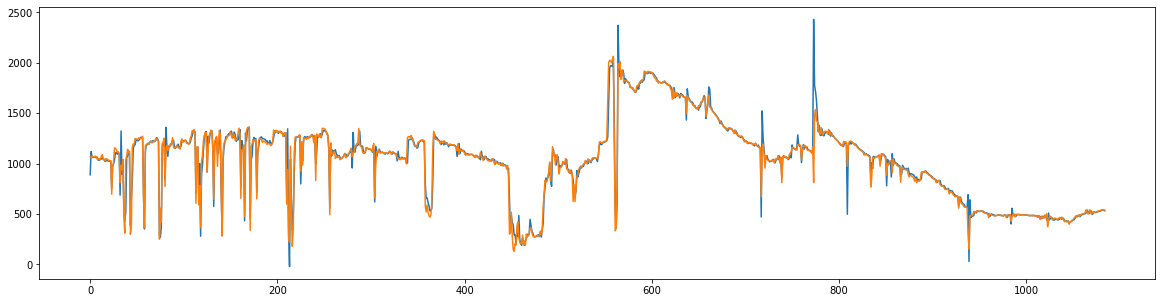

In [1500]:
plt.figure(figsize=(20,5))
plt.plot(Prediction_oil)
plt.plot(test[:,10])

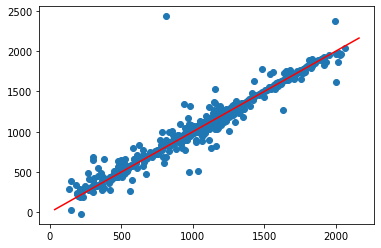

In [111]:
plt.scatter(test[:,10],Prediction_oil)
ax=plt.gca()
x = np.linspace(*ax.get_xlim())
ax.plot(x, x,'r')

In [112]:
check_error(test[:,10],Prediction_oil)

RMSE       80.920204
MAE        32.872480
R2          0.956243
MAE/range   0.016992

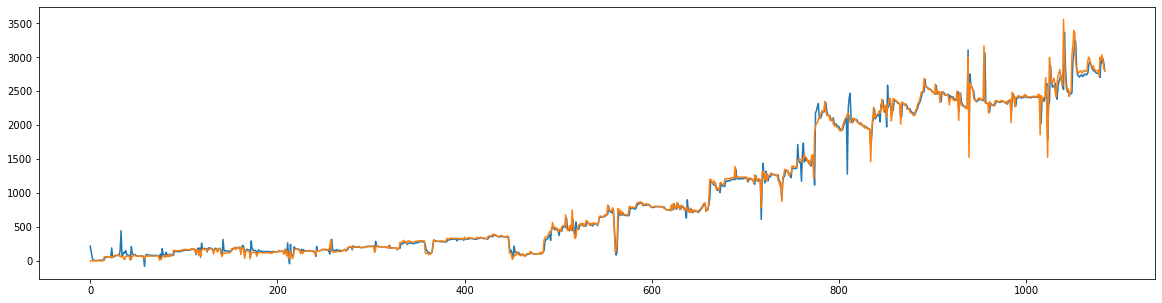

In [113]:
plt.figure(figsize=(20,5))
plt.plot(Prediction_water)
plt.plot(test[:,12])

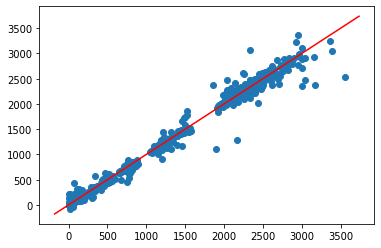

In [114]:
plt.scatter(test[:,12],Prediction_water)
ax=plt.gca()
x = np.linspace(*ax.get_xlim())
ax.plot(x, x,'r')

In [115]:
check_error(test[:,12],Prediction_water)

RMSE       93.489860
MAE        41.488902
R2          0.990471
MAE/range   0.011655

# Task #3 (PSO+LSTM)

In [116]:
import time
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
import itertools
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten,Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import Model

#### Func

In [126]:
def train_val_test_task_3(df,history_size,all_train=False):
    '''Maybe you can combine this with orginal train_val_test function'''
    future_target=1
    ofi=[0,4]
    targets=[-3]
    if all_train==True:
        train_f1,train_f2,train_label=feature_target_future(df.values, df.values[:, targets], 0,
                                                 None, history_size,ofi,
                                                 1, step=1)
        train=np.hstack([train_f1,train_f2,train_label])
        return train

    train_f1,train_f2,train_label=feature_target_future(df.values, df.values[:, targets], 0,
                                                 None, history_size,ofi,
                                                 1, step=1)
    
    train=np.hstack([train_f1,train_f2,train_label])
    return train

In [130]:
BUFFER_SIZE = 10000

##### PSO tutorial:
https://pyswarms.readthedocs.io/en/latest/examples/tutorials/basic_optimization.html#Optimizing-a-function

In [117]:
def fitness_function(single_particle, mini_batch_data):
    """Objective function.
    
    """
    future_target=1
    ofi=[0,4]
    

    history_size=int(single_particle[0])
    n_unit=int(single_particle[1])
    learning_rate=single_particle[2]
    l2=single_particle[3]
    
    t=train_val_test_task_3(mini_batch_data,history_size)
    tscv=TimeSeriesSplit(3)
    RMSE=[]
    R2=[]
    MAE=[]
    MAE_RANGE=[]
    for train_index, test_index in tscv.split(t):
    
        train, test = t[train_index], t[test_index[history_size:]]
        
        train=drop_na_shutin(train)
        test=drop_na_shutin(test)
        
        train,test=convert_task_3_only_valid(train,test,history_size)
        
        print(train[0].shape,train[1].shape,train[2].shape)
        print(test[0].shape,test[1].shape,test[2].shape)
        
        BATCHSIZE=min(len(train),32)
        
        train_data_multi = tf.data.Dataset.from_tensor_slices(((train[0],train[1]),train[2]))
        train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCHSIZE).repeat()

        val_data_multi = tf.data.Dataset.from_tensor_slices(((test[0],test[1]), test[2]))
        val_data_multi = val_data_multi.batch(BATCHSIZE).repeat()
        
        tf.keras.backend.clear_session()
        tf.random.set_seed(13)

        ### define two sets of inputs
        inputA = Input(shape=train[0].shape[1])
        inputB = Input(shape=train[1].shape[1:])
        # the first branch operates on the first input
        
        x = Dense(int(n_unit/4),activation='relu',kernel_regularizer=regularizers.l2(l2))(inputA)
        y = LSTM(n_unit,activation='relu',kernel_regularizer=regularizers.l2(l2),
                            return_sequences=False)(inputB)
        merged_model = layers.concatenate([x,y])

        final_model = Dense(1)(merged_model)


        model = Model(inputs=[inputA, inputB], outputs=final_model)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_squared_error',
                  metrics=['mae'])

        model.summary()
        earlyStopping=EarlyStopping(monitor='loss', \
                                    min_delta=0.0001, patience=0, verbose=0, mode='auto',restore_best_weights=False)

        history = model.fit(train_data_multi, callbacks=[earlyStopping],epochs=200,
                                                    validation_data=val_data_multi,
                                                validation_steps=15,
                                                steps_per_epoch=45,shuffle=True)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()
        pred=model.predict((test[0],test[1]))
        rmse=mean_squared_error(test[2],pred)
        RMSE.append(rmse)

    loss=np.mean(RMSE)

    return loss

In [118]:
def f(x,mini_batch_data):
    """Higher-level method to do fitness_function in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [fitness_function(x[i],mini_batch_data=mini_batch_data) for i in range(n_particles)]
    return np.array(j)

In [119]:
# Initialize swarm
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

In [122]:
# set boundary for different hyperparameters
max_bound_1 = 14
max_bound_2 = 256
max_bound_3 = 0.1
max_bound_4 = 0.1

min_bound_1 = 1
min_bound_2 = 8
min_bound_3 = 0.001
min_bound_4 = 0

bounds=(np.array([min_bound_1,min_bound_2,min_bound_3,min_bound_4]),np.array([max_bound_1,max_bound_2,max_bound_3,max_bound_4]))

In [123]:
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=4, options=options, bounds= bounds)

In [3847]:
### this may take hours to run, the optimized values is at the bottom
cost, pos = optimizer.optimize(f, 20, mini_batch_data=Before_1[:int(len(Before_1)*0.8)])

2020-04-24 20:22:29,568 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



pyswarms.single.global_best:   0%|          |0/20

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 56)           168         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 224)          208768      input_2[0][0]                    
______________________________________________________________________________________________

45/45 [==============================] - 0s 7ms/step - loss: 33585392.9922 - mae: 2578.1958 - val_loss: 264731.4690 - val_mae: 469.9039
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 19283809.0880 - mae: 1696.1417 - val_loss: 226937.3146 - val_mae: 437.9415
Epoch 8/200
45/45 [==============================] - 0s 7ms/step - loss: 913542.4343 - mae: 563.0667 - val_loss: 153909.7224 - val_mae: 259.9338
Epoch 9/200
45/45 [==============================] - 0s 7ms/step - loss: 1457415.6854 - mae: 633.5312 - val_loss: 156868.1268 - val_mae: 264.5732
Epoch 10/200
45/45 [==============================] - 0s 7ms/step - loss: 660200.5178 - mae: 540.6855 - val_loss: 169315.8284 - val_mae: 360.2520
Epoch 11/200
45/45 [==============================] - 0s 7ms/step - loss: 681193.4828 - mae: 538.1188 - val_loss: 145021.2738 - val_mae: 248.7040
Epoch 12/200
45/45 [==============================] - 0s 7ms/step - loss: 595137.9003 - mae: 489.4819 - val_loss: 139196.5245 - val_m

45/45 [==============================] - 5s 103ms/step - loss: 1446586040516.2666 - mae: 708942.2500 - val_loss: 109925312477.8667 - val_mae: 276661.7188
Epoch 2/200
45/45 [==============================] - 1s 13ms/step - loss: 887697069852.4445 - mae: 574398.5000 - val_loss: 271577190502.4000 - val_mae: 439994.9375
Epoch 3/200
45/45 [==============================] - 1s 13ms/step - loss: 64637934814.1333 - mae: 138357.7812 - val_loss: 22950862028.8000 - val_mae: 151014.2500
Epoch 4/200
45/45 [==============================] - 1s 13ms/step - loss: 1661054440464.7112 - mae: 252110.8125 - val_loss: 6234513757.8667 - val_mae: 68016.0703
Epoch 5/200
45/45 [==============================] - 1s 14ms/step - loss: 3124823325.4222 - mae: 38650.0273 - val_loss: 140949914.4333 - val_mae: 9684.2432
Epoch 6/200
45/45 [==============================] - 1s 14ms/step - loss: 264882783.9444 - mae: 10915.7676 - val_loss: 64010007.2667 - val_mae: 5982.0942
Epoch 7/200
45/45 [=============================

45/45 [==============================] - 2s 36ms/step - loss: 552699735963.0222 - mae: 389148.8750 - val_loss: 245905131281.0667 - val_mae: 229515.2500
Epoch 2/200
45/45 [==============================] - 1s 12ms/step - loss: 242408890397.1556 - mae: 194235.9688 - val_loss: 255627590.9333 - val_mae: 15059.4990
Epoch 3/200
45/45 [==============================] - 1s 13ms/step - loss: 797035569.9556 - mae: 22418.3867 - val_loss: 214423188.8000 - val_mae: 14139.5371
Epoch 4/200
45/45 [==============================] - 1s 13ms/step - loss: 360884659.7500 - mae: 16086.0107 - val_loss: 107679526.6667 - val_mae: 9810.5088
Epoch 5/200
45/45 [==============================] - 1s 13ms/step - loss: 220315272.2505 - mae: 13603.7129 - val_loss: 27959375.0667 - val_mae: 4930.9458
Epoch 6/200
45/45 [==============================] - 1s 15ms/step - loss: 117019736.9111 - mae: 7868.1665 - val_loss: 15055304.1333 - val_mae: 2975.3386
Epoch 7/200
45/45 [==============================] - 1s 13ms/step - lo

Epoch 55/200
45/45 [==============================] - 1s 13ms/step - loss: 5059193.3900 - mae: 1443.5443 - val_loss: 1094570.4304 - val_mae: 648.6897
Epoch 56/200
45/45 [==============================] - 1s 13ms/step - loss: 2389843.5418 - mae: 1053.1443 - val_loss: 1100819.1563 - val_mae: 609.2821
Epoch 57/200
45/45 [==============================] - 1s 13ms/step - loss: 2938809.4923 - mae: 1084.1268 - val_loss: 961821.2714 - val_mae: 602.5445
Epoch 58/200
45/45 [==============================] - 1s 14ms/step - loss: 3474569.1963 - mae: 1103.6775 - val_loss: 915513.7166 - val_mae: 563.1946
Epoch 59/200
45/45 [==============================] - 1s 13ms/step - loss: 2869575.9756 - mae: 903.4169 - val_loss: 874146.1470 - val_mae: 551.5541
Epoch 60/200
45/45 [==============================] - 1s 13ms/step - loss: 2628671.2503 - mae: 980.6243 - val_loss: 819038.5047 - val_mae: 540.9150
Epoch 61/200
45/45 [==============================] - 1s 14ms/step - loss: 2201886.6513 - mae: 867.5001 - 

45/45 [==============================] - 0s 8ms/step - loss: 490255.9896 - mae: 503.2218 - val_loss: 707328.4844 - val_mae: 493.6163
Epoch 24/200
45/45 [==============================] - 0s 7ms/step - loss: 669929.0771 - mae: 545.4303 - val_loss: 507802.4318 - val_mae: 416.1585
Epoch 25/200
45/45 [==============================] - 0s 8ms/step - loss: 499322.9052 - mae: 523.4436 - val_loss: 692876.4563 - val_mae: 481.3343
Epoch 26/200
45/45 [==============================] - 0s 9ms/step - loss: 443303.9845 - mae: 490.1708 - val_loss: 491481.6916 - val_mae: 278.2976
Epoch 27/200
45/45 [==============================] - 0s 7ms/step - loss: 837696.2679 - mae: 719.1422 - val_loss: 671986.8313 - val_mae: 462.3389
Epoch 28/200
45/45 [==============================] - 0s 8ms/step - loss: 322466.5017 - mae: 388.6113 - val_loss: 566541.5974 - val_mae: 510.3854
Epoch 29/200
45/45 [==============================] - 0s 8ms/step - loss: 847622.4868 - mae: 661.3996 - val_loss: 1490520.0750 - val_mae:

45/45 [==============================] - 0s 8ms/step - loss: 536191.1274 - mae: 423.2533 - val_loss: 604043.6661 - val_mae: 539.2169
Epoch 8/200
45/45 [==============================] - 0s 9ms/step - loss: 509437.1571 - mae: 476.5385 - val_loss: 541216.9271 - val_mae: 448.9093
Epoch 9/200
45/45 [==============================] - 0s 8ms/step - loss: 687975.5827 - mae: 556.8822 - val_loss: 705485.7375 - val_mae: 647.9675
Epoch 10/200
45/45 [==============================] - 0s 9ms/step - loss: 717937.5781 - mae: 514.9950 - val_loss: 644424.2198 - val_mae: 593.3737
Epoch 11/200
45/45 [==============================] - 0s 8ms/step - loss: 424580.3558 - mae: 397.5943 - val_loss: 592574.0661 - val_mae: 535.4950
Epoch 12/200
45/45 [==============================] - 0s 6ms/step - loss: 588890.2572 - mae: 523.5995 - val_loss: 513629.3686 - val_mae: 332.1589
Epoch 13/200
45/45 [==============================] - 0s 7ms/step - loss: 547869.5849 - mae: 459.7704 - val_loss: 685764.7667 - val_mae: 63

45/45 [==============================] - 1s 31ms/step - loss: 20546721564.4722 - mae: 88787.7109 - val_loss: 339627079.4000 - val_mae: 7449.1167
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 2226929677.2010 - mae: 23746.0391 - val_loss: 632344.9646 - val_mae: 723.3848
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 1147329823.0771 - mae: 19343.5391 - val_loss: 410055.1789 - val_mae: 522.0998
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 76127727.7931 - mae: 6615.4468 - val_loss: 506513.3370 - val_mae: 546.6603
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 2727593.1123 - mae: 1137.3021 - val_loss: 89398.0277 - val_mae: 213.9230
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 1696920.4394 - mae: 743.1301 - val_loss: 46049.1286 - val_mae: 112.3379
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 895544.7534 - mae: 592.2667 - val_loss: 4

45/45 [==============================] - 1s 32ms/step - loss: 6202789101.8667 - mae: 54328.4961 - val_loss: 1523624135.4667 - val_mae: 31941.3535
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 10067560636.5556 - mae: 53719.9102 - val_loss: 166838020.5333 - val_mae: 6986.7104
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 321181508.5486 - mae: 9001.2412 - val_loss: 91979916.0000 - val_mae: 9389.5469
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 35090974.5729 - mae: 4894.8813 - val_loss: 4727995.5776 - val_mae: 1663.3306
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 7579617.6547 - mae: 1692.9736 - val_loss: 4736185.1063 - val_mae: 1733.0214
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 43614544.6021 - mae: 4736.9062 - val_loss: 4540829.9104 - val_mae: 1837.5636
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 5897445.4341 - mae: 1808

Epoch 19/200
45/45 [==============================] - 0s 7ms/step - loss: 957964.1796 - mae: 665.2026 - val_loss: 366549.5880 - val_mae: 537.3130
Epoch 20/200
45/45 [==============================] - 0s 7ms/step - loss: 911753.7116 - mae: 741.0250 - val_loss: 157084.6852 - val_mae: 303.0802
Epoch 21/200
45/45 [==============================] - 0s 7ms/step - loss: 907819.3737 - mae: 732.8246 - val_loss: 301806.9708 - val_mae: 479.5916
Epoch 22/200
45/45 [==============================] - 0s 7ms/step - loss: 825495.5083 - mae: 662.6146 - val_loss: 119969.4757 - val_mae: 262.3570
Epoch 23/200
45/45 [==============================] - 0s 7ms/step - loss: 838443.8276 - mae: 631.4984 - val_loss: 280919.6677 - val_mae: 462.1468
Epoch 24/200
45/45 [==============================] - 0s 7ms/step - loss: 724911.0978 - mae: 641.6763 - val_loss: 125451.7934 - val_mae: 267.5794
Epoch 25/200
45/45 [==============================] - 0s 7ms/step - loss: 681223.6347 - mae: 576.9336 - val_loss: 259052.209

45/45 [==============================] - 1s 32ms/step - loss: 111466459454.1111 - mae: 183206.5781 - val_loss: 1746564359.4667 - val_mae: 26731.9062
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 4161474241.0222 - mae: 25476.3359 - val_loss: 5976151.3167 - val_mae: 2427.9900
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 17606629.6333 - mae: 4042.6042 - val_loss: 5975481.5833 - val_mae: 2427.8518
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 17864617.6278 - mae: 4086.5476 - val_loss: 5974790.6000 - val_mae: 2427.7097
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 18121352.4809 - mae: 4127.4995 - val_loss: 5973987.5833 - val_mae: 2427.5442
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 18290018.0222 - mae: 4137.5068 - val_loss: 5973086.7667 - val_mae: 2427.3586
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 17024560.9333 - mae: 3962

45/45 [==============================] - 1s 32ms/step - loss: 1507316130734.9333 - mae: 724782.6875 - val_loss: 38173787477.3333 - val_mae: 192077.7969
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 15612044728.9778 - mae: 90543.9219 - val_loss: 250952986.6667 - val_mae: 14499.7959
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 682710211.6854 - mae: 20224.3086 - val_loss: 305399168.0000 - val_mae: 16440.4180
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 92096045.2222 - mae: 7280.7656 - val_loss: 38562469.3083 - val_mae: 4579.9307
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 73882518.5974 - mae: 6100.3022 - val_loss: 30926895.7000 - val_mae: 4190.2842
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 58685845.9556 - mae: 5242.6885 - val_loss: 25538730.5167 - val_mae: 3830.5000
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 61875772.1

Epoch 56/200
45/45 [==============================] - 0s 6ms/step - loss: 1210824.8179 - mae: 825.4093 - val_loss: 1712427.1365 - val_mae: 926.7381
Epoch 57/200
45/45 [==============================] - 0s 6ms/step - loss: 1159912.5326 - mae: 831.7885 - val_loss: 2339005.4083 - val_mae: 1450.7286
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 62)           186         input_1[0][0]                

45/45 [==============================] - 0s 5ms/step - loss: 17204216.0000 - mae: 4001.7671 - val_loss: 23603609.0000 - val_mae: 4763.1592
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 16560198.5000 - mae: 3897.6135 - val_loss: 23269669.8000 - val_mae: 4728.6221
Epoch 8/200
45/45 [==============================] - 0s 5ms/step - loss: 16295886.1955 - mae: 3874.9065 - val_loss: 22101286.1333 - val_mae: 4605.8267
Epoch 9/200
45/45 [==============================] - 0s 5ms/step - loss: 14806373.9222 - mae: 3704.1228 - val_loss: 17939100.1333 - val_mae: 4139.3047
Epoch 10/200
45/45 [==============================] - 0s 5ms/step - loss: 9257076.2695 - mae: 2868.2380 - val_loss: 8423612.4333 - val_mae: 2847.4653
Epoch 11/200
45/45 [==============================] - 0s 5ms/step - loss: 3306774.6986 - mae: 1579.4647 - val_loss: 1024951.1583 - val_mae: 968.8124
Epoch 12/200
45/45 [==============================] - 0s 5ms/step - loss: 698900.3122 - mae: 663.3477 - val_l

45/45 [==============================] - 4s 84ms/step - loss: 3081773033.1583 - mae: 32900.0703 - val_loss: 1475149.7500 - val_mae: 1204.7380
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 7066276.7727 - mae: 1620.6442 - val_loss: 24624.2415 - val_mae: 142.3211
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 426949.0279 - mae: 411.5579 - val_loss: 34503.4844 - val_mae: 176.4026
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 356851.9273 - mae: 318.2463 - val_loss: 41502.9044 - val_mae: 195.7610
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 528766.4907 - mae: 414.6932 - val_loss: 62911.6659 - val_mae: 243.2148
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 363005.7258 - mae: 373.4346 - val_loss: 21453.1079 - val_mae: 128.1574
Epoch 7/200
45/45 [==============================] - 0s 4ms/step - loss: 201687.5748 - mae: 269.7419 - val_loss: 14324.7576 - val_mae: 7

45/45 [==============================] - 1s 28ms/step - loss: 69469594.3285 - mae: 4801.6045 - val_loss: 1178244.7281 - val_mae: 1062.1399
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 9033653.6547 - mae: 2548.7690 - val_loss: 186858.3880 - val_mae: 395.4810
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 541759.6877 - mae: 525.4509 - val_loss: 176136.3917 - val_mae: 385.5791
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 258551.2195 - mae: 314.5039 - val_loss: 109387.5779 - val_mae: 286.8693
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 230852.8431 - mae: 342.8745 - val_loss: 166037.9542 - val_mae: 371.5141
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 323742.4924 - mae: 361.7406 - val_loss: 40748.2778 - val_mae: 121.4033
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 186181.0526 - mae: 318.2265 - val_loss: 105454.0708 - val_mae:

45/45 [==============================] - 2s 34ms/step - loss: 16037802560.9944 - mae: 72144.4375 - val_loss: 506686862.9333 - val_mae: 22230.7832
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 1959372036.2333 - mae: 16400.5156 - val_loss: 5987712.9500 - val_mae: 2430.3652
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 17094936.9639 - mae: 3940.3694 - val_loss: 5932798.1167 - val_mae: 2419.1418
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 17632279.8222 - mae: 4058.8259 - val_loss: 5661377.9833 - val_mae: 2362.8755
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 16274845.8071 - mae: 3900.1360 - val_loss: 3632703.4000 - val_mae: 1890.0151
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 8385380.9500 - mae: 2672.9080 - val_loss: 156110.2279 - val_mae: 374.2909
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 1090307.6686 - mae: 828.9868 - 




pyswarms.single.global_best:   0%|          |0/20, best_cost=2.77e+5


pyswarms.single.global_best:   5%|▌         |1/20, best_cost=2.77e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 53)           159         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 214)          190888      input_2[0][0]                    
______________________________________________________________________________________________

45/45 [==============================] - 1s 31ms/step - loss: 891408238026.5778 - mae: 619829.1250 - val_loss: 21657777561.6000 - val_mae: 145242.5000
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 48984183759.2889 - mae: 129457.5859 - val_loss: 3150848034.1333 - val_mae: 55548.9883
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 6239074219.8875 - mae: 54245.2969 - val_loss: 99652845.2000 - val_mae: 7731.5391
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 152541494.6677 - mae: 6256.7480 - val_loss: 32605188.8729 - val_mae: 2898.0303
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 275227930.7222 - mae: 11295.4600 - val_loss: 85671045.6000 - val_mae: 7553.6724
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 93909090.4865 - mae: 5905.4321 - val_loss: 49811728.0479 - val_mae: 3429.1416
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 7818313

45/45 [==============================] - 1s 29ms/step - loss: 329558549769.6000 - mae: 312373.5312 - val_loss: 743386997.3333 - val_mae: 14866.0957
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 11583331330.1333 - mae: 62824.7188 - val_loss: 77610532.0000 - val_mae: 7906.3960
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 303619165.4684 - mae: 10559.8193 - val_loss: 4401274.9667 - val_mae: 1950.0071
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 22714338.5029 - mae: 2476.5798 - val_loss: 43492.6821 - val_mae: 128.3357
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 1316154.0190 - mae: 563.9975 - val_loss: 42771.8790 - val_mae: 124.6194
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 7130233.8889 - mae: 1056.3096 - val_loss: 572361.8021 - val_mae: 727.6748
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 2927145.8345 - mae: 1111.2112 - v

45/45 [==============================] - 0s 9ms/step - loss: 4644016.7268 - mae: 1231.6936 - val_loss: 566042.3441 - val_mae: 563.0225
Epoch 11/200
45/45 [==============================] - 0s 10ms/step - loss: 2170948.9377 - mae: 1073.3921 - val_loss: 593193.9568 - val_mae: 569.8491
Epoch 12/200
45/45 [==============================] - 0s 9ms/step - loss: 1553564.3445 - mae: 873.2877 - val_loss: 530702.0860 - val_mae: 527.7583
Epoch 13/200
45/45 [==============================] - 0s 9ms/step - loss: 1466583.6864 - mae: 862.8050 - val_loss: 527479.0042 - val_mae: 522.4594
Epoch 14/200
45/45 [==============================] - 0s 8ms/step - loss: 1657750.4873 - mae: 951.7935 - val_loss: 613847.0795 - val_mae: 587.2263
Epoch 15/200
45/45 [==============================] - 0s 10ms/step - loss: 1997378.9003 - mae: 1055.0963 - val_loss: 632156.4764 - val_mae: 599.3069
Epoch 16/200
45/45 [==============================] - 0s 8ms/step - loss: 1577924.1347 - mae: 840.7210 - val_loss: 517242.0119

45/45 [==============================] - 0s 8ms/step - loss: 950524.2423 - mae: 717.5496 - val_loss: 109977.9948 - val_mae: 297.8418
Epoch 31/200
45/45 [==============================] - 0s 8ms/step - loss: 3596495.0059 - mae: 1445.8405 - val_loss: 1349221.4542 - val_mae: 1145.1766
Epoch 32/200
45/45 [==============================] - 0s 8ms/step - loss: 3286411.2303 - mae: 1348.8481 - val_loss: 27825.9766 - val_mae: 114.1869
Epoch 33/200
45/45 [==============================] - 0s 8ms/step - loss: 1358150.2091 - mae: 800.3139 - val_loss: 88174.9589 - val_mae: 261.5958
Epoch 34/200
45/45 [==============================] - 0s 8ms/step - loss: 2441150.3644 - mae: 1087.8092 - val_loss: 64251.9716 - val_mae: 232.0522
Epoch 35/200
45/45 [==============================] - 0s 8ms/step - loss: 3173185.6995 - mae: 1346.3561 - val_loss: 281060.5396 - val_mae: 503.6961
Epoch 36/200
45/45 [==============================] - 0s 8ms/step - loss: 2184094.8563 - mae: 986.2034 - val_loss: 49903.3635 - v

Epoch 33/200
45/45 [==============================] - 0s 7ms/step - loss: 3489280.8231 - mae: 1449.2194 - val_loss: 2276576.3500 - val_mae: 1328.0872
Epoch 34/200
45/45 [==============================] - 0s 7ms/step - loss: 1026802.8791 - mae: 654.3163 - val_loss: 918815.3083 - val_mae: 734.0611
Epoch 35/200
45/45 [==============================] - 0s 7ms/step - loss: 934540.6960 - mae: 675.8367 - val_loss: 2560672.8583 - val_mae: 1509.0168
Epoch 36/200
45/45 [==============================] - 0s 7ms/step - loss: 1339298.8947 - mae: 905.6365 - val_loss: 753490.2266 - val_mae: 608.2460
Epoch 37/200
45/45 [==============================] - 0s 7ms/step - loss: 1048353.6228 - mae: 705.3395 - val_loss: 752212.6345 - val_mae: 495.3240
Epoch 38/200
45/45 [==============================] - 0s 7ms/step - loss: 734340.6705 - mae: 606.9698 - val_loss: 2426913.5250 - val_mae: 1377.7085
Epoch 39/200
45/45 [==============================] - 0s 7ms/step - loss: 1455127.3266 - mae: 909.9251 - val_loss

45/45 [==============================] - 0s 7ms/step - loss: 160291313.6306 - mae: 8246.4346 - val_loss: 9237987.5771 - val_mae: 2203.3489
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 31598832.5684 - mae: 2854.1665 - val_loss: 12226212.9250 - val_mae: 2797.8596
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 38076147.6736 - mae: 3671.8562 - val_loss: 6544340.0844 - val_mae: 1871.0052
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 17696570.5444 - mae: 2697.0393 - val_loss: 6617946.1375 - val_mae: 2001.3455
Epoch 8/200
45/45 [==============================] - 0s 6ms/step - loss: 12597630.7059 - mae: 2463.6089 - val_loss: 4856488.5781 - val_mae: 1574.3048
Epoch 9/200
45/45 [==============================] - 0s 6ms/step - loss: 10192188.3865 - mae: 2015.6857 - val_loss: 4498051.1750 - val_mae: 1582.5717
Epoch 10/200
45/45 [==============================] - 0s 6ms/step - loss: 11802702.3163 - mae: 2220.7356 - val

45/45 [==============================] - 1s 29ms/step - loss: 370269151763.0222 - mae: 341383.7188 - val_loss: 19198162607.2000 - val_mae: 118048.3203
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 14220309196.7563 - mae: 75913.0156 - val_loss: 165681362.8000 - val_mae: 11786.4697
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 2557587906.8996 - mae: 42244.3203 - val_loss: 8274274.4667 - val_mae: 2453.9729
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 219310778.6903 - mae: 12396.4033 - val_loss: 69330910.4000 - val_mae: 8170.7222
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 77098696.2415 - mae: 7221.5664 - val_loss: 3488113.6172 - val_mae: 1250.1416
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 13429963.9347 - mae: 2872.7087 - val_loss: 1949826.4563 - val_mae: 1085.5469
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 53032672.3392

45/45 [==============================] - 1s 33ms/step - loss: 416029864278.7472 - mae: 234758.2500 - val_loss: 22344663.3333 - val_mae: 4630.6152
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 282260110.4049 - mae: 9005.9053 - val_loss: 504198.5979 - val_mae: 699.2999
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 949221796.3062 - mae: 9776.4766 - val_loss: 1352295.9583 - val_mae: 1154.6715
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 12224452.1444 - mae: 3214.8425 - val_loss: 1131088.0542 - val_mae: 1054.8668
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 8936390.3028 - mae: 2690.4302 - val_loss: 622617.4542 - val_mae: 778.4196
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 4522570.7094 - mae: 1784.4889 - val_loss: 48335.0669 - val_mae: 199.6255
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 706192.4285 - mae: 627.0214 - val_loss

Epoch 18/200
45/45 [==============================] - 0s 3ms/step - loss: 527779.2392 - mae: 455.5899 - val_loss: 1687034.7083 - val_mae: 1017.8801
Epoch 19/200
45/45 [==============================] - 0s 3ms/step - loss: 569715.1490 - mae: 476.9412 - val_loss: 1389589.7917 - val_mae: 762.5278
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 22)           66          input_1[0][0]                  

Epoch 26/200
45/45 [==============================] - 0s 7ms/step - loss: 378554.5667 - mae: 440.7747 - val_loss: 888756.5281 - val_mae: 641.1940
Epoch 27/200
45/45 [==============================] - 0s 6ms/step - loss: 482810.8487 - mae: 505.3536 - val_loss: 640146.7698 - val_mae: 589.5195
Epoch 28/200
45/45 [==============================] - 0s 7ms/step - loss: 384630.7841 - mae: 443.4624 - val_loss: 669550.5979 - val_mae: 619.6659
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 11, 8)]      0                                            
____________________________________________________

45/45 [==============================] - 0s 6ms/step - loss: 883545.3178 - mae: 466.2133 - val_loss: 125514.7344 - val_mae: 113.9935
Epoch 10/200
45/45 [==============================] - 0s 7ms/step - loss: 4175983.7298 - mae: 1402.4664 - val_loss: 182671.9979 - val_mae: 409.6934
Epoch 11/200
45/45 [==============================] - 0s 6ms/step - loss: 402811.5910 - mae: 410.9374 - val_loss: 15412.4535 - val_mae: 74.3357
Epoch 12/200
45/45 [==============================] - 0s 6ms/step - loss: 260111.6843 - mae: 293.9439 - val_loss: 16501.0019 - val_mae: 82.4549
Epoch 13/200
45/45 [==============================] - 0s 7ms/step - loss: 684904.5508 - mae: 402.2386 - val_loss: 21088.3458 - val_mae: 108.8503
Epoch 14/200
45/45 [==============================] - 0s 7ms/step - loss: 236269.6330 - mae: 306.1949 - val_loss: 12263.8664 - val_mae: 50.1168
Epoch 15/200
45/45 [==============================] - 0s 6ms/step - loss: 638231.7272 - mae: 438.9211 - val_loss: 12908.7115 - val_mae: 74.992

45/45 [==============================] - 0s 7ms/step - loss: 416803890.5111 - mae: 13390.5205 - val_loss: 83117315.2333 - val_mae: 7278.7988
Epoch 10/200
45/45 [==============================] - 1s 14ms/step - loss: 397000553.6401 - mae: 13603.4658 - val_loss: 54844338.5333 - val_mae: 5803.1079
Epoch 11/200
45/45 [==============================] - 0s 11ms/step - loss: 182006971.4889 - mae: 10438.5195 - val_loss: 139469538.2667 - val_mae: 10585.5957
Epoch 12/200
45/45 [==============================] - 1s 13ms/step - loss: 1704886797.4375 - mae: 15365.8369 - val_loss: 524547668.8000 - val_mae: 19088.3789
Epoch 13/200
45/45 [==============================] - 1s 17ms/step - loss: 4399008399.6556 - mae: 31346.0449 - val_loss: 124927853.0667 - val_mae: 9715.2129
Epoch 14/200
45/45 [==============================] - 0s 11ms/step - loss: 1210083831.1111 - mae: 25711.7520 - val_loss: 799750097.0667 - val_mae: 25258.5977
Epoch 15/200
45/45 [==============================] - 0s 9ms/step - loss: 

Epoch 33/200
45/45 [==============================] - 0s 5ms/step - loss: 303328.3301 - mae: 375.9017 - val_loss: 341695.6451 - val_mae: 259.4360
Epoch 34/200
45/45 [==============================] - 0s 5ms/step - loss: 277435.2746 - mae: 366.3784 - val_loss: 339887.0211 - val_mae: 253.8608
Epoch 35/200
45/45 [==============================] - 0s 6ms/step - loss: 265892.8413 - mae: 334.8820 - val_loss: 339335.6527 - val_mae: 238.5921
Epoch 36/200
45/45 [==============================] - 0s 5ms/step - loss: 299540.6055 - mae: 368.8082 - val_loss: 358887.8299 - val_mae: 341.7474
Epoch 37/200
45/45 [==============================] - 0s 5ms/step - loss: 370406.1474 - mae: 397.5876 - val_loss: 335681.4799 - val_mae: 281.1045
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0   

Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 3035724.8653 - mae: 1388.7417 - val_loss: 35192.1318 - val_mae: 123.9488
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 513980.0132 - mae: 475.3150 - val_loss: 28511.2741 - val_mae: 101.3741
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 819778.0457 - mae: 583.8564 - val_loss: 57079.2142 - val_mae: 210.8485
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 924889.4658 - mae: 679.7221 - val_loss: 36434.2717 - val_mae: 153.8849
Epoch 8/200
45/45 [==============================] - 0s 6ms/step - loss: 514332.7066 - mae: 448.2630 - val_loss: 19987.0705 - val_mae: 78.0884
Epoch 9/200
45/45 [==============================] - 0s 5ms/step - loss: 476062.6165 - mae: 441.8817 - val_loss: 23890.2352 - val_mae: 106.4512
Epoch 10/200
45/45 [==============================] - 0s 5ms/step - loss: 539650.8264 - mae: 458.0571 - val_loss: 18274.4063 - val_mae:

Epoch 12/200
45/45 [==============================] - 0s 3ms/step - loss: 454702.5618 - mae: 528.7267 - val_loss: 393635.3783 - val_mae: 430.6143
Epoch 13/200
45/45 [==============================] - 0s 4ms/step - loss: 527589.4705 - mae: 563.4164 - val_loss: 396297.0118 - val_mae: 432.4207
Epoch 14/200
45/45 [==============================] - 0s 3ms/step - loss: 442816.7233 - mae: 525.7303 - val_loss: 489528.4448 - val_mae: 517.8442
Epoch 15/200
45/45 [==============================] - 0s 3ms/step - loss: 434677.0842 - mae: 500.3822 - val_loss: 286908.9201 - val_mae: 309.3749
Epoch 16/200
45/45 [==============================] - 0s 4ms/step - loss: 520966.3972 - mae: 573.0484 - val_loss: 346318.9242 - val_mae: 375.4911
Epoch 17/200
45/45 [==============================] - 0s 3ms/step - loss: 409466.4959 - mae: 489.8234 - val_loss: 423859.5910 - val_mae: 454.3713
Epoch 18/200
45/45 [==============================] - 0s 3ms/step - loss: 522010.0811 - mae: 556.7969 - val_loss: 467211.787

Epoch 29/200
45/45 [==============================] - 0s 3ms/step - loss: 374462.6418 - mae: 373.8937 - val_loss: 82433.9630 - val_mae: 197.6721
Epoch 30/200
45/45 [==============================] - 0s 3ms/step - loss: 432534.2841 - mae: 433.6519 - val_loss: 84446.8024 - val_mae: 175.2968
Epoch 31/200
45/45 [==============================] - 0s 3ms/step - loss: 229521.1943 - mae: 298.5170 - val_loss: 100219.9519 - val_mae: 203.3079
Epoch 32/200
45/45 [==============================] - 0s 3ms/step - loss: 290478.2536 - mae: 333.7398 - val_loss: 95839.1569 - val_mae: 195.5553
Epoch 33/200
45/45 [==============================] - 0s 3ms/step - loss: 405536.3209 - mae: 384.0168 - val_loss: 93119.0009 - val_mae: 191.2612
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0       

45/45 [==============================] - 0s 6ms/step - loss: 985964.9617 - mae: 665.1967 - val_loss: 315541.2974 - val_mae: 400.2915
Epoch 27/200
45/45 [==============================] - 0s 7ms/step - loss: 826442.5233 - mae: 631.7110 - val_loss: 488987.9926 - val_mae: 562.8285
Epoch 28/200
45/45 [==============================] - 0s 7ms/step - loss: 632701.6003 - mae: 607.3395 - val_loss: 234870.3130 - val_mae: 319.6521
Epoch 29/200
45/45 [==============================] - 0s 7ms/step - loss: 933347.4501 - mae: 675.8871 - val_loss: 387286.8242 - val_mae: 474.7988
Epoch 30/200
45/45 [==============================] - 0s 7ms/step - loss: 1255620.9100 - mae: 832.7972 - val_loss: 155996.1492 - val_mae: 318.2877
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0               




pyswarms.single.global_best:   5%|▌         |1/20, best_cost=2.33e+5


pyswarms.single.global_best:  10%|█         |2/20, best_cost=2.33e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 8, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 52)           156         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 208)          180544      input_2[0][0]                    
______________________________________________________________________________________________

45/45 [==============================] - 2s 35ms/step - loss: 6066330002267.0225 - mae: 1395916.7500 - val_loss: 101856363588.2667 - val_mae: 309769.3438
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 648225349859.2000 - mae: 442942.5938 - val_loss: 15114721075.2000 - val_mae: 121885.3750
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 89947266947.9111 - mae: 215375.2188 - val_loss: 3992693316.2667 - val_mae: 61509.9492
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 5346958876.3000 - mae: 50205.9961 - val_loss: 22364429.0667 - val_mae: 4518.4912
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 267398011.3069 - mae: 10725.7256 - val_loss: 19392158.0000 - val_mae: 4245.3989
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 110071796.0625 - mae: 5226.4243 - val_loss: 7558637.4667 - val_mae: 2589.9221
Epoch 7/200
45/45 [==============================] - 0s 8ms/step - 

Epoch 55/200
45/45 [==============================] - 0s 7ms/step - loss: 2704718.4528 - mae: 1292.9819 - val_loss: 3289636.3167 - val_mae: 1784.6262
Epoch 56/200
45/45 [==============================] - 0s 7ms/step - loss: 2953961.2389 - mae: 1277.7823 - val_loss: 4111364.1333 - val_mae: 2009.6652
Epoch 57/200
45/45 [==============================] - 0s 7ms/step - loss: 5025427.5410 - mae: 1424.3135 - val_loss: 1822564.4750 - val_mae: 1312.4445
Epoch 58/200
45/45 [==============================] - 0s 7ms/step - loss: 2841906.8292 - mae: 1337.2968 - val_loss: 3799056.4833 - val_mae: 1936.5125
Epoch 59/200
45/45 [==============================] - 0s 7ms/step - loss: 2669829.3702 - mae: 1112.7987 - val_loss: 3169862.1667 - val_mae: 1765.5782
Epoch 60/200
45/45 [==============================] - 0s 7ms/step - loss: 2825257.7669 - mae: 1145.9276 - val_loss: 2526817.0417 - val_mae: 1573.6793
Epoch 61/200
45/45 [==============================] - 0s 7ms/step - loss: 2546760.5781 - mae: 1108.8

45/45 [==============================] - 3s 78ms/step - loss: 1916211360.2382 - mae: 29064.2324 - val_loss: 1984851082.6667 - val_mae: 33021.8047
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 610591621.3667 - mae: 11984.3838 - val_loss: 657643.0323 - val_mae: 477.6958
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 12114472.3120 - mae: 2304.5830 - val_loss: 769428.7578 - val_mae: 782.9394
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 3386805.3285 - mae: 1174.7583 - val_loss: 471794.0167 - val_mae: 471.1169
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 2915825.1222 - mae: 1203.9772 - val_loss: 376731.7508 - val_mae: 380.4137
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 13590341.7762 - mae: 2612.8674 - val_loss: 409038.0807 - val_mae: 499.1687
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 1729492.9422 - mae: 905.3630 - val_loss: 

45/45 [==============================] - 1s 30ms/step - loss: 3122896764.3111 - mae: 40352.1992 - val_loss: 22397838.9117 - val_mae: 1756.1915
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 198617278.0278 - mae: 10007.0830 - val_loss: 1033749.3833 - val_mae: 995.9765
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 2402612.6917 - mae: 1155.7319 - val_loss: 71303.8597 - val_mae: 233.6503
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 1099977.9716 - mae: 671.2187 - val_loss: 80527.1432 - val_mae: 256.4269
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 1153572.7036 - mae: 700.1890 - val_loss: 35517.9826 - val_mae: 126.6322
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 567178.3625 - mae: 478.1839 - val_loss: 88535.2880 - val_mae: 273.6385
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 479976.0710 - mae: 480.8564 - val_loss: 28021.5238 - 

45/45 [==============================] - 2s 40ms/step - loss: 43056221307.0222 - mae: 134056.5938 - val_loss: 1222807813.3333 - val_mae: 27899.3398
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 1017719224.8889 - mae: 25494.8105 - val_loss: 52437209.3333 - val_mae: 7009.7842
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 93531745.3278 - mae: 7849.6841 - val_loss: 1181189.7184 - val_mae: 661.1771
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 10637006.5035 - mae: 1770.5709 - val_loss: 1050255.5023 - val_mae: 630.7086
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 8808461.9646 - mae: 1544.8512 - val_loss: 805917.7835 - val_mae: 527.6454
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 8568735.0059 - mae: 1434.1788 - val_loss: 644594.1587 - val_mae: 493.4377
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 4672638.8778 - mae: 1320.3331 - v

45/45 [==============================] - 2s 35ms/step - loss: 694526825.2667 - mae: 20016.6426 - val_loss: 91010557.3333 - val_mae: 4899.7144
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 50295210.2191 - mae: 5026.6396 - val_loss: 6361847.3500 - val_mae: 2485.3347
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 6753513.4086 - mae: 1944.7400 - val_loss: 232968.4951 - val_mae: 402.0312
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 548435.9320 - mae: 468.4116 - val_loss: 131748.0662 - val_mae: 217.0553
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 972622.7962 - mae: 535.7759 - val_loss: 965262.0380 - val_mae: 637.0857
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 226413367.8458 - mae: 9964.5498 - val_loss: 5809374.2833 - val_mae: 2390.3694
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 17536784.0778 - mae: 4056.3838 - val_loss: 5445

45/45 [==============================] - 1s 27ms/step - loss: 258920878.2844 - mae: 11393.8906 - val_loss: 9100577.0188 - val_mae: 2034.9253
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 838333808.9222 - mae: 20414.5176 - val_loss: 380233760.0000 - val_mae: 19168.7676
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 71296878.2172 - mae: 6553.4604 - val_loss: 6293912.2667 - val_mae: 2327.5435
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 1182047.9339 - mae: 745.3033 - val_loss: 1453066.8292 - val_mae: 854.9442
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 536023.4099 - mae: 464.6824 - val_loss: 1635333.3354 - val_mae: 997.8076
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 962293.6160 - mae: 563.0322 - val_loss: 1121894.0212 - val_mae: 539.0103
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 556452.0041 - mae: 533.7831 - val_loss: 11

45/45 [==============================] - 0s 8ms/step - loss: 23267626.5576 - mae: 1955.3683 - val_loss: 1547795.8375 - val_mae: 1106.2695
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 61768016.5611 - mae: 1543.3359 - val_loss: 4419221.1229 - val_mae: 1799.4576
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 46279740.9028 - mae: 4410.2808 - val_loss: 2945709.4750 - val_mae: 1565.4908
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 4159938.7011 - mae: 1638.1837 - val_loss: 1084376.2812 - val_mae: 935.9601
Epoch 7/200
45/45 [==============================] - 0s 8ms/step - loss: 618528.5305 - mae: 569.3896 - val_loss: 581345.1288 - val_mae: 382.6702
Epoch 8/200
45/45 [==============================] - 0s 7ms/step - loss: 436201.1049 - mae: 473.1429 - val_loss: 525156.1109 - val_mae: 427.5935
Epoch 9/200
45/45 [==============================] - 0s 7ms/step - loss: 587812.9192 - mae: 478.8082 - val_loss: 539558.3945

45/45 [==============================] - 2s 42ms/step - loss: 5353194333.8667 - mae: 53440.1445 - val_loss: 2704505244.6000 - val_mae: 39808.3477
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 1015142668.2556 - mae: 19735.7227 - val_loss: 39645474.4000 - val_mae: 6180.6367
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 190767082.7274 - mae: 4938.5933 - val_loss: 283858.9729 - val_mae: 486.8949
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 2621942.3401 - mae: 1201.9807 - val_loss: 87264.8149 - val_mae: 219.5242
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 441484.6043 - mae: 431.1067 - val_loss: 127462.7697 - val_mae: 281.8357
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 32753813.9937 - mae: 3267.2346 - val_loss: 402284.5917 - val_mae: 523.7917
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 1263819.9491 - mae: 793.4946 - val_loss

45/45 [==============================] - 1s 32ms/step - loss: 30640235677.1556 - mae: 130444.4453 - val_loss: 33707632230.4000 - val_mae: 170177.1719
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 29975469589.6889 - mae: 119479.1250 - val_loss: 1474825979.7333 - val_mae: 35366.8047
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 626349610.6556 - mae: 20406.1035 - val_loss: 35715934.2260 - val_mae: 2608.0972
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 60371044.9191 - mae: 5041.2812 - val_loss: 4685326.9542 - val_mae: 1861.0756
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 11788844.6724 - mae: 2139.9175 - val_loss: 1811389.9108 - val_mae: 927.2627
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 662796975.5208 - mae: 7802.8794 - val_loss: 166623234.1333 - val_mae: 12712.6025
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 59252751.056

45/45 [==============================] - 0s 6ms/step - loss: 7887240.1994 - mae: 1889.3282 - val_loss: 3814405.8750 - val_mae: 1643.3889
Epoch 17/200
45/45 [==============================] - 0s 6ms/step - loss: 16139592.1142 - mae: 2120.4255 - val_loss: 2353258.2646 - val_mae: 1186.9409
Epoch 18/200
45/45 [==============================] - 0s 6ms/step - loss: 9977639.3750 - mae: 2184.5544 - val_loss: 2900127.6833 - val_mae: 1455.0686
Epoch 19/200
45/45 [==============================] - 0s 6ms/step - loss: 7470155.8115 - mae: 1810.5618 - val_loss: 4870390.9500 - val_mae: 2049.0339
Epoch 20/200
45/45 [==============================] - 0s 6ms/step - loss: 11835796.2643 - mae: 2435.6958 - val_loss: 1810387.0521 - val_mae: 1070.9254
Epoch 21/200
45/45 [==============================] - 0s 6ms/step - loss: 6844867.5326 - mae: 2017.2623 - val_loss: 1170597.7414 - val_mae: 760.9932
Epoch 22/200
45/45 [==============================] - 0s 6ms/step - loss: 4774216.2856 - mae: 1402.6644 - val_lo

45/45 [==============================] - 1s 31ms/step - loss: 13096667895.1250 - mae: 69042.4688 - val_loss: 1494097.6438 - val_mae: 1081.5143
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 19467415110.1667 - mae: 43082.3398 - val_loss: 8715503.7667 - val_mae: 2854.2747
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 126406704.1056 - mae: 8282.1846 - val_loss: 295043.0764 - val_mae: 343.9929
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 7140058.7585 - mae: 1866.4783 - val_loss: 659065.8938 - val_mae: 765.2324
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 8980229.1130 - mae: 1446.0774 - val_loss: 313547.9771 - val_mae: 521.1949
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 2389241.3113 - mae: 927.1445 - val_loss: 81456.9253 - val_mae: 247.2304
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 2160033.8535 - mae: 1009.2195 - val_loss: 

45/45 [==============================] - 2s 34ms/step - loss: 29333613695.8111 - mae: 93683.9297 - val_loss: 77452642.6833 - val_mae: 5521.9062
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 283931148.5000 - mae: 10448.1943 - val_loss: 4425815.7333 - val_mae: 1933.1522
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 17493394.6778 - mae: 4053.5769 - val_loss: 4758261.9833 - val_mae: 2161.3103
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 11744384.9333 - mae: 3246.1890 - val_loss: 283561.9185 - val_mae: 503.7069
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 1946962.6170 - mae: 1086.6646 - val_loss: 3170853.3500 - val_mae: 1752.2087
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 803517.2913 - mae: 698.7389 - val_loss: 2601534.0667 - val_mae: 1585.3774
Epoch 7/200
45/45 [==============================] - 0s 8ms/step - loss: 879318.7392 - mae: 717.6779 - val_los

45/45 [==============================] - 0s 4ms/step - loss: 3505236.2930 - mae: 1134.6779 - val_loss: 753427.9077 - val_mae: 580.2614
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 2659498.6208 - mae: 999.0432 - val_loss: 508065.3571 - val_mae: 470.4632
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 1373090.1085 - mae: 768.5275 - val_loss: 520794.8229 - val_mae: 571.8551
Epoch 8/200
45/45 [==============================] - 0s 4ms/step - loss: 1299300.5486 - mae: 702.9841 - val_loss: 303351.1267 - val_mae: 366.1917
Epoch 9/200
45/45 [==============================] - 0s 4ms/step - loss: 734246.5892 - mae: 548.4255 - val_loss: 278364.5426 - val_mae: 389.7178
Epoch 10/200
45/45 [==============================] - 0s 4ms/step - loss: 896184.7053 - mae: 615.9158 - val_loss: 289299.7376 - val_mae: 409.5859
Epoch 11/200
45/45 [==============================] - 0s 4ms/step - loss: 997448.6113 - mae: 648.2445 - val_loss: 219161.3025 - val_mae:

45/45 [==============================] - 1s 30ms/step - loss: 2432848241.1778 - mae: 29058.7207 - val_loss: 60069343.0833 - val_mae: 5447.3809
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 29729944.3854 - mae: 4033.1250 - val_loss: 7678614.2396 - val_mae: 2109.1833
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 8337324.7692 - mae: 1891.7354 - val_loss: 47275325.4667 - val_mae: 6828.9946
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 3504649.9580 - mae: 1384.0758 - val_loss: 1710537.0750 - val_mae: 1220.4554
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 780988.5218 - mae: 626.7466 - val_loss: 544992.8456 - val_mae: 425.4420
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 5830029.3985 - mae: 1770.0088 - val_loss: 2515149.8833 - val_mae: 1543.1414
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 1422087.6942 - mae: 954.3076 - val_loss: 




pyswarms.single.global_best:  10%|█         |2/20, best_cost=1.93e+5


pyswarms.single.global_best:  15%|█▌        |3/20, best_cost=1.93e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 11, 8)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 45)           135         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 182)          139048      input_2[0][0]                    
______________________________________________________________________________________________

Epoch 9/200
45/45 [==============================] - 0s 7ms/step - loss: 247435711.0127 - mae: 9709.4385 - val_loss: 43738476.4750 - val_mae: 4673.3574
Epoch 10/200
45/45 [==============================] - 0s 7ms/step - loss: 186516583.6056 - mae: 9814.3623 - val_loss: 46275653.3750 - val_mae: 5053.5640
Epoch 11/200
45/45 [==============================] - 0s 8ms/step - loss: 201995185.6778 - mae: 8553.6484 - val_loss: 34690916.8708 - val_mae: 4166.4922
Epoch 12/200
45/45 [==============================] - 0s 7ms/step - loss: 170167188.2222 - mae: 8832.2910 - val_loss: 32791693.0823 - val_mae: 4094.6348
Epoch 13/200
45/45 [==============================] - 0s 7ms/step - loss: 251401019.0500 - mae: 8544.5518 - val_loss: 32261244.3375 - val_mae: 4092.4548
Epoch 14/200
45/45 [==============================] - 0s 7ms/step - loss: 245632888.5024 - mae: 9512.1689 - val_loss: 31158010.4729 - val_mae: 3958.0200
Epoch 15/200
45/45 [==============================] - 0s 7ms/step - loss: 160319840

45/45 [==============================] - 0s 6ms/step - loss: 439872.1046 - mae: 450.4978 - val_loss: 892766.7273 - val_mae: 799.9966
Epoch 16/200
45/45 [==============================] - 0s 7ms/step - loss: 484750.5310 - mae: 495.6324 - val_loss: 1232766.4635 - val_mae: 1009.7936
Epoch 17/200
45/45 [==============================] - 0s 6ms/step - loss: 356852.5850 - mae: 461.0720 - val_loss: 614743.0707 - val_mae: 553.9866
Epoch 18/200
45/45 [==============================] - 0s 6ms/step - loss: 427935.0066 - mae: 433.1733 - val_loss: 615217.9286 - val_mae: 554.3002
Epoch 19/200
45/45 [==============================] - 0s 6ms/step - loss: 511571.0674 - mae: 463.8931 - val_loss: 622102.6896 - val_mae: 561.2616
Epoch 20/200
45/45 [==============================] - 0s 6ms/step - loss: 441139.9013 - mae: 472.8067 - val_loss: 773009.0286 - val_mae: 708.1634
Epoch 21/200
45/45 [==============================] - 0s 6ms/step - loss: 422892.7511 - mae: 434.8846 - val_loss: 584141.3911 - val_mae

Epoch 23/200
45/45 [==============================] - 0s 8ms/step - loss: 504029.8091 - mae: 453.2254 - val_loss: 96289.5142 - val_mae: 177.9382
Epoch 24/200
45/45 [==============================] - 0s 6ms/step - loss: 955181.7270 - mae: 567.9141 - val_loss: 97699.8413 - val_mae: 269.8381
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 8)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 28)           84          input_1[0][0]                    
__

45/45 [==============================] - 2s 35ms/step - loss: 60793454553.7556 - mae: 126009.1094 - val_loss: 7463745348.2667 - val_mae: 76190.1641
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 5584683640.4722 - mae: 51828.8906 - val_loss: 105771850.6667 - val_mae: 10187.0771
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 38361348.3361 - mae: 4731.5112 - val_loss: 1810845.3677 - val_mae: 896.4068
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 32253493.4208 - mae: 2931.4624 - val_loss: 2356396.0000 - val_mae: 1292.5690
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 22998799.2340 - mae: 3680.6621 - val_loss: 3717526.0500 - val_mae: 1799.7513
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 2056204.8687 - mae: 970.6725 - val_loss: 987556.1234 - val_mae: 641.9132
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 1125925.1254 - mae: 693.1203

45/45 [==============================] - 1s 32ms/step - loss: 27878873986.0444 - mae: 104367.1641 - val_loss: 22479664349.8667 - val_mae: 130684.7969
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 2781924453.6889 - mae: 33570.3008 - val_loss: 15878593.6667 - val_mae: 3969.3423
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 7240660.3403 - mae: 1811.4374 - val_loss: 273087.2500 - val_mae: 468.9308
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 918053.4234 - mae: 764.5461 - val_loss: 136529.2081 - val_mae: 271.2017
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 736430.0413 - mae: 517.6078 - val_loss: 106643.0052 - val_mae: 173.1099
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 563140.5769 - mae: 393.6548 - val_loss: 107328.3525 - val_mae: 177.5480
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 563357.0732 - mae: 464.7932 - val_loss: 1

45/45 [==============================] - 2s 34ms/step - loss: 1140876322284.2000 - mae: 536352.5625 - val_loss: 10624973926.4000 - val_mae: 100510.7812
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 8749743875.7444 - mae: 43266.8203 - val_loss: 7065821.3000 - val_mae: 2599.7915
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 821347683.8667 - mae: 14056.7461 - val_loss: 22529456.0000 - val_mae: 4690.4468
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 54070567.6444 - mae: 7179.8608 - val_loss: 15266096.0000 - val_mae: 3851.4932
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 33788220.9990 - mae: 5652.6147 - val_loss: 9511685.9000 - val_mae: 3027.1094
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 21805042.6000 - mae: 4504.7788 - val_loss: 5834619.4333 - val_mae: 2355.0168
Epoch 7/200
45/45 [==============================] - 0s 8ms/step - loss: 12993200.1056 - ma

45/45 [==============================] - 0s 8ms/step - loss: 814326.2392 - mae: 597.4418 - val_loss: 59100.5227 - val_mae: 183.2955
Epoch 73/200
45/45 [==============================] - 0s 7ms/step - loss: 683971.1390 - mae: 570.5483 - val_loss: 44711.0819 - val_mae: 144.4102
Epoch 74/200
45/45 [==============================] - 0s 7ms/step - loss: 688558.8650 - mae: 507.2925 - val_loss: 39830.4411 - val_mae: 132.8903
Epoch 75/200
45/45 [==============================] - 0s 7ms/step - loss: 1329843.1378 - mae: 558.4023 - val_loss: 37551.8366 - val_mae: 152.5530
Epoch 76/200
45/45 [==============================] - 0s 7ms/step - loss: 1288400.7759 - mae: 698.9478 - val_loss: 75340.9990 - val_mae: 239.5703
Epoch 77/200
45/45 [==============================] - 0s 8ms/step - loss: 2757920.8450 - mae: 889.1139 - val_loss: 33814.9760 - val_mae: 121.3201
Epoch 78/200
45/45 [==============================] - 0s 8ms/step - loss: 650121.0441 - mae: 549.2123 - val_loss: 30726.0867 - val_mae: 116.

Epoch 19/200
45/45 [==============================] - 0s 4ms/step - loss: 349795.3995 - mae: 379.4891 - val_loss: 969947.3706 - val_mae: 717.8098
Epoch 20/200
45/45 [==============================] - 0s 4ms/step - loss: 405002.7735 - mae: 462.4708 - val_loss: 1098902.2245 - val_mae: 841.1176
Epoch 21/200
45/45 [==============================] - 0s 4ms/step - loss: 334505.0541 - mae: 367.6341 - val_loss: 1013775.0594 - val_mae: 768.0130
Epoch 22/200
45/45 [==============================] - 0s 4ms/step - loss: 504209.9162 - mae: 482.7406 - val_loss: 874138.8667 - val_mae: 620.1429
Epoch 23/200
45/45 [==============================] - 0s 4ms/step - loss: 439172.9118 - mae: 435.1373 - val_loss: 798329.6311 - val_mae: 490.8546
Epoch 24/200
45/45 [==============================] - 0s 4ms/step - loss: 516259.8509 - mae: 501.1968 - val_loss: 813820.9952 - val_mae: 541.2519
Epoch 25/200
45/45 [==============================] - 0s 4ms/step - loss: 424275.4514 - mae: 421.6635 - val_loss: 783368.5

45/45 [==============================] - 4s 97ms/step - loss: 459960542525.3222 - mae: 281208.0000 - val_loss: 11780029405.8667 - val_mae: 106293.5312
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 23578291678.5097 - mae: 56556.8477 - val_loss: 114289926.0000 - val_mae: 8253.8682
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 7730684583.7014 - mae: 32371.4180 - val_loss: 27486183.3646 - val_mae: 3856.2393
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 248007676866.6194 - mae: 65837.9766 - val_loss: 24912381.8000 - val_mae: 4934.4731
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 17992819.4333 - mae: 4092.1375 - val_loss: 24914775.6667 - val_mae: 4934.7168
Epoch 6/200
45/45 [==============================] - 0s 8ms/step - loss: 17567997.2111 - mae: 4010.0920 - val_loss: 24914231.5333 - val_mae: 4934.6621
Epoch 7/200
45/45 [==============================] - 0s 8ms/step - loss: 16329854

45/45 [==============================] - 2s 43ms/step - loss: 205284717027.2000 - mae: 210188.8438 - val_loss: 6006411.4833 - val_mae: 2434.1396
Epoch 2/200
45/45 [==============================] - 0s 9ms/step - loss: 4656998114.5889 - mae: 26762.7598 - val_loss: 4021745.2083 - val_mae: 1574.2509
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 18736043.7222 - mae: 4046.3306 - val_loss: 5999234.2500 - val_mae: 2432.6853
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 18560926.6000 - mae: 4179.1606 - val_loss: 5994135.1000 - val_mae: 2431.6475
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 18436041.8467 - mae: 4181.4590 - val_loss: 5990539.6833 - val_mae: 2430.9155
Epoch 6/200
45/45 [==============================] - 0s 8ms/step - loss: 18522985.4000 - mae: 4165.8174 - val_loss: 5988266.6000 - val_mae: 2430.4517
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 17146557.1222 - mae: 3989.520

Epoch 9/200
45/45 [==============================] - 0s 6ms/step - loss: 7029500.5589 - mae: 638.0013 - val_loss: 14759.9959 - val_mae: 58.1951
Epoch 10/200
45/45 [==============================] - 0s 6ms/step - loss: 3862350.9895 - mae: 644.8186 - val_loss: 35233.6562 - val_mae: 161.1899
Epoch 11/200
45/45 [==============================] - 0s 6ms/step - loss: 4709745.9823 - mae: 651.9875 - val_loss: 47426.7010 - val_mae: 196.4329
Epoch 12/200
45/45 [==============================] - 0s 6ms/step - loss: 752207.8153 - mae: 453.3239 - val_loss: 23931.9096 - val_mae: 116.8412
Epoch 13/200
45/45 [==============================] - 0s 6ms/step - loss: 447227411.4050 - mae: 3829.4285 - val_loss: 100508.1594 - val_mae: 305.4252
Epoch 14/200
45/45 [==============================] - 0s 6ms/step - loss: 20279987.6179 - mae: 2609.4709 - val_loss: 47720.9180 - val_mae: 205.5706
Epoch 15/200
45/45 [==============================] - 0s 6ms/step - loss: 707746.3805 - mae: 470.9737 - val_loss: 16764.7

45/45 [==============================] - 0s 6ms/step - loss: 440685.8077 - mae: 475.9415 - val_loss: 469141.6812 - val_mae: 333.2570
Epoch 27/200
45/45 [==============================] - 0s 6ms/step - loss: 950597.0927 - mae: 766.7894 - val_loss: 492156.8995 - val_mae: 408.9842
Epoch 28/200
45/45 [==============================] - 0s 6ms/step - loss: 877859.6124 - mae: 730.1714 - val_loss: 2776166.1750 - val_mae: 1515.2635
Epoch 29/200
45/45 [==============================] - 0s 6ms/step - loss: 1006004.4763 - mae: 805.4117 - val_loss: 1341854.9979 - val_mae: 931.9428
Epoch 30/200
45/45 [==============================] - 0s 6ms/step - loss: 1736346.3659 - mae: 1068.3602 - val_loss: 5316223.8000 - val_mae: 2292.7854
Epoch 31/200
45/45 [==============================] - 0s 6ms/step - loss: 874830.7665 - mae: 737.7100 - val_loss: 1729129.0583 - val_mae: 1260.7736
Epoch 32/200
45/45 [==============================] - 0s 7ms/step - loss: 852158.2850 - mae: 704.1595 - val_loss: 587880.3958 -

45/45 [==============================] - 1s 30ms/step - loss: 3441668510.1333 - mae: 42363.6641 - val_loss: 14367645687.4667 - val_mae: 109249.2031
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 9767086752.8444 - mae: 55629.2148 - val_loss: 18540383.0667 - val_mae: 4246.5210
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 53730607.2965 - mae: 4969.8174 - val_loss: 1572564.4542 - val_mae: 1192.2039
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 14492027.3208 - mae: 2792.2810 - val_loss: 568841.1948 - val_mae: 660.9317
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 21459339.1429 - mae: 3200.0664 - val_loss: 1462409.5750 - val_mae: 1165.5028
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 22520974.5870 - mae: 3404.8706 - val_loss: 4190496.6167 - val_mae: 1962.3907
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 23284982.0074 - mae: 3414.1

45/45 [==============================] - 1s 30ms/step - loss: 51448544817.0667 - mae: 140460.3906 - val_loss: 651921321.4333 - val_mae: 20904.2402
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 432589483.3556 - mae: 14864.6855 - val_loss: 32635664.5333 - val_mae: 5222.8574
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 31222994.2209 - mae: 3984.7290 - val_loss: 11580090.5167 - val_mae: 3061.3862
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 73653631.5146 - mae: 6329.5391 - val_loss: 10609461.0833 - val_mae: 2819.5337
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 42896053.3258 - mae: 4870.9209 - val_loss: 30355671.3333 - val_mae: 5215.7856
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 10156028.4661 - mae: 2349.5664 - val_loss: 1834156.0240 - val_mae: 1028.9849
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 3917637.3784 - mae: 1363

45/45 [==============================] - 0s 5ms/step - loss: 14906811.5612 - mae: 2143.4124 - val_loss: 1211129.0769 - val_mae: 435.9038
Epoch 38/200
45/45 [==============================] - 0s 5ms/step - loss: 6655873.9049 - mae: 1489.1492 - val_loss: 700727.0009 - val_mae: 402.5183
Epoch 39/200
45/45 [==============================] - 0s 5ms/step - loss: 4916678.4619 - mae: 1172.5503 - val_loss: 443983.5670 - val_mae: 427.8286
Epoch 40/200
45/45 [==============================] - 0s 5ms/step - loss: 1780692.5746 - mae: 874.4872 - val_loss: 433506.2824 - val_mae: 322.4043
Epoch 41/200
45/45 [==============================] - 0s 5ms/step - loss: 2205638.3816 - mae: 881.8858 - val_loss: 34178.0658 - val_mae: 131.3842
Epoch 42/200
45/45 [==============================] - 0s 5ms/step - loss: 616999.5687 - mae: 555.4796 - val_loss: 54068.5420 - val_mae: 198.6980
Epoch 43/200
45/45 [==============================] - 0s 5ms/step - loss: 510237.7238 - mae: 441.6560 - val_loss: 78005.3944 - va

45/45 [==============================] - 1s 30ms/step - loss: 775015456319.2889 - mae: 413724.5938 - val_loss: 9238228258.1333 - val_mae: 84239.1797
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 68892536569.5486 - mae: 102152.3984 - val_loss: 3803419.4000 - val_mae: 1940.0774
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 100027128.2757 - mae: 7872.2993 - val_loss: 857645.1375 - val_mae: 881.2656
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 2479967.5964 - mae: 1034.4071 - val_loss: 75917.4503 - val_mae: 138.9496
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 1026048.9394 - mae: 623.9518 - val_loss: 79755.6359 - val_mae: 173.2766
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 1111868.6016 - mae: 689.8741 - val_loss: 47982.2423 - val_mae: 94.6663
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 1010874.2563 - mae: 541.1911 - val_loss

45/45 [==============================] - 1s 31ms/step - loss: 41247380823.7174 - mae: 91646.5078 - val_loss: 163119123.7208 - val_mae: 6406.8745
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 496852012.4778 - mae: 10905.5088 - val_loss: 1429193.5500 - val_mae: 1188.4581
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 12891331.3667 - mae: 3280.2056 - val_loss: 1303122.2583 - val_mae: 1134.5040
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 12519767.2222 - mae: 3214.2881 - val_loss: 325544.0250 - val_mae: 562.0887
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 6657237.7778 - mae: 2189.5676 - val_loss: 6664105.2333 - val_mae: 2577.6560
Epoch 6/200
45/45 [==============================] - 0s 8ms/step - loss: 1860318.4028 - mae: 1198.1240 - val_loss: 11272845.1333 - val_mae: 3352.4900
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 1838818.6764 - mae: 1194.7394 - v




pyswarms.single.global_best:  15%|█▌        |3/20, best_cost=1.93e+5


pyswarms.single.global_best:  20%|██        |4/20, best_cost=1.93e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 8)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 37)           111         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 150)          95400       input_2[0][0]                    
______________________________________________________________________________________________

Epoch 43/200
45/45 [==============================] - 0s 6ms/step - loss: 6611708.8722 - mae: 1920.0754 - val_loss: 2580475.4203 - val_mae: 1143.9602
Epoch 44/200
45/45 [==============================] - 0s 6ms/step - loss: 8345382.8906 - mae: 2085.7122 - val_loss: 2271087.7365 - val_mae: 1080.6874
Epoch 45/200
45/45 [==============================] - 0s 7ms/step - loss: 6944267.9392 - mae: 1930.6158 - val_loss: 2594327.0573 - val_mae: 1371.3031
Epoch 46/200
45/45 [==============================] - 0s 7ms/step - loss: 8473943.5944 - mae: 2163.7756 - val_loss: 2661059.0552 - val_mae: 1412.1348
Epoch 47/200
45/45 [==============================] - 0s 6ms/step - loss: 5826323.4705 - mae: 1718.6248 - val_loss: 1914350.0745 - val_mae: 1000.5167
Epoch 48/200
45/45 [==============================] - 0s 6ms/step - loss: 7120056.0337 - mae: 1899.0247 - val_loss: 1823863.4865 - val_mae: 979.7393
Epoch 49/200
45/45 [==============================] - 0s 6ms/step - loss: 6360197.2785 - mae: 1802.32

Epoch 11/200
45/45 [==============================] - 0s 8ms/step - loss: 1436537.9662 - mae: 814.3781 - val_loss: 507823.6146 - val_mae: 469.3069
Epoch 12/200
45/45 [==============================] - 0s 7ms/step - loss: 1310349.8934 - mae: 745.4427 - val_loss: 398633.3622 - val_mae: 394.3270
Epoch 13/200
45/45 [==============================] - 0s 6ms/step - loss: 1082466.0286 - mae: 779.9836 - val_loss: 296577.4923 - val_mae: 362.4399
Epoch 14/200
45/45 [==============================] - 0s 7ms/step - loss: 568121.2818 - mae: 528.7217 - val_loss: 249143.2699 - val_mae: 316.3120
Epoch 15/200
45/45 [==============================] - 0s 7ms/step - loss: 737812.5504 - mae: 574.3952 - val_loss: 215657.2794 - val_mae: 336.8433
Epoch 16/200
45/45 [==============================] - 0s 6ms/step - loss: 751284.2068 - mae: 537.8810 - val_loss: 207112.0849 - val_mae: 355.1854
Epoch 17/200
45/45 [==============================] - 0s 7ms/step - loss: 781415.9505 - mae: 579.5554 - val_loss: 182804.

45/45 [==============================] - 0s 6ms/step - loss: 17842277.5556 - mae: 4076.0913 - val_loss: 24844273.6000 - val_mae: 4927.5723
Epoch 19/200
45/45 [==============================] - 0s 6ms/step - loss: 17400570.7111 - mae: 3999.4980 - val_loss: 24837397.8000 - val_mae: 4926.8745
Epoch 20/200
45/45 [==============================] - 0s 6ms/step - loss: 16628251.5333 - mae: 3898.5959 - val_loss: 24830546.5333 - val_mae: 4926.1787
Epoch 21/200
45/45 [==============================] - 0s 6ms/step - loss: 17661742.5111 - mae: 4048.1316 - val_loss: 24823321.0000 - val_mae: 4925.4448
Epoch 22/200
45/45 [==============================] - 0s 7ms/step - loss: 16294609.1889 - mae: 3873.5154 - val_loss: 24815957.2000 - val_mae: 4924.6973
Epoch 23/200
45/45 [==============================] - 0s 7ms/step - loss: 16752227.9778 - mae: 3939.2625 - val_loss: 24808339.7333 - val_mae: 4923.9238
Epoch 24/200
45/45 [==============================] - 0s 6ms/step - loss: 16131211.1222 - mae: 3834.6

45/45 [==============================] - 0s 9ms/step - loss: 54286812.0224 - mae: 5967.6538 - val_loss: 9903293.3000 - val_mae: 3087.2188
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 2721934.5322 - mae: 1257.5121 - val_loss: 1091074.9182 - val_mae: 844.7333
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 914433.8261 - mae: 705.0896 - val_loss: 1605200.9750 - val_mae: 1125.1874
Epoch 5/200
45/45 [==============================] - 0s 9ms/step - loss: 909690.3754 - mae: 716.1690 - val_loss: 717921.0776 - val_mae: 584.2745
Epoch 6/200
45/45 [==============================] - 0s 9ms/step - loss: 1244551.8620 - mae: 843.2372 - val_loss: 1513001.6021 - val_mae: 1087.1216
Epoch 7/200
45/45 [==============================] - 0s 9ms/step - loss: 959967.6804 - mae: 753.3760 - val_loss: 684825.3342 - val_mae: 507.1264
Epoch 8/200
45/45 [==============================] - ETA: 0s - loss: 1217829.1135 - mae: 883.487 - 0s 8ms/step - loss: 1240180.15

45/45 [==============================] - 0s 7ms/step - loss: 43145942.2062 - mae: 3838.3145 - val_loss: 123923162.1333 - val_mae: 8427.1807
Epoch 8/200
45/45 [==============================] - 0s 6ms/step - loss: 41404586.9403 - mae: 4472.4800 - val_loss: 1938055.4167 - val_mae: 967.6702
Epoch 9/200
45/45 [==============================] - 0s 7ms/step - loss: 5422780.9167 - mae: 1816.3911 - val_loss: 11365632.0667 - val_mae: 3178.5454
Epoch 10/200
45/45 [==============================] - 0s 6ms/step - loss: 4715026.2021 - mae: 1728.6571 - val_loss: 885839.3570 - val_mae: 572.6775
Epoch 11/200
45/45 [==============================] - 0s 6ms/step - loss: 3166089.3991 - mae: 1405.1720 - val_loss: 2866550.2729 - val_mae: 1436.7070
Epoch 12/200
45/45 [==============================] - 0s 6ms/step - loss: 3241704.9332 - mae: 1451.8940 - val_loss: 7932534.5000 - val_mae: 2752.1177
Epoch 13/200
45/45 [==============================] - 0s 6ms/step - loss: 1336211.4143 - mae: 906.5774 - val_loss

Epoch 18/200
45/45 [==============================] - 0s 6ms/step - loss: 5058967.5590 - mae: 1714.5408 - val_loss: 1368292.9990 - val_mae: 1010.1906
Epoch 19/200
45/45 [==============================] - 0s 6ms/step - loss: 3969046.7725 - mae: 1425.7531 - val_loss: 1802127.2999 - val_mae: 985.2218
Epoch 20/200
45/45 [==============================] - 0s 6ms/step - loss: 5063078.0021 - mae: 1719.7002 - val_loss: 2389559.6654 - val_mae: 1086.4524
Epoch 21/200
45/45 [==============================] - 0s 6ms/step - loss: 9282970.2644 - mae: 2282.4905 - val_loss: 834856.7109 - val_mae: 671.8806
Epoch 22/200
45/45 [==============================] - 0s 6ms/step - loss: 2516993.3139 - mae: 1217.3700 - val_loss: 1125000.0625 - val_mae: 894.2979
Epoch 23/200
45/45 [==============================] - 0s 6ms/step - loss: 2583532.9810 - mae: 1242.0332 - val_loss: 595497.6882 - val_mae: 581.7116
Epoch 24/200
45/45 [==============================] - 0s 6ms/step - loss: 2451583.1965 - mae: 1106.9640 - 

Epoch 20/200
45/45 [==============================] - 0s 6ms/step - loss: 7447014.1308 - mae: 1661.2397 - val_loss: 2700885.0500 - val_mae: 1588.3561
Epoch 21/200
45/45 [==============================] - 0s 6ms/step - loss: 3050772.5536 - mae: 1266.2327 - val_loss: 268083.2464 - val_mae: 494.9720
Epoch 22/200
45/45 [==============================] - 0s 6ms/step - loss: 4575648.6326 - mae: 1417.3464 - val_loss: 152381.7242 - val_mae: 358.1988
Epoch 23/200
45/45 [==============================] - 0s 6ms/step - loss: 2056234.1012 - mae: 845.8949 - val_loss: 262302.4500 - val_mae: 490.8617
Epoch 24/200
45/45 [==============================] - 0s 6ms/step - loss: 1049131.7831 - mae: 696.8997 - val_loss: 119784.6227 - val_mae: 306.0777
Epoch 25/200
45/45 [==============================] - 0s 7ms/step - loss: 38782216.7070 - mae: 3684.3577 - val_loss: 1949986.2167 - val_mae: 1365.5886
Epoch 26/200
45/45 [==============================] - 0s 7ms/step - loss: 2326577.2710 - mae: 1161.1801 - val

Epoch 9/200
45/45 [==============================] - 0s 4ms/step - loss: 799322.8195 - mae: 534.1079 - val_loss: 161987.5383 - val_mae: 364.8642
Epoch 10/200
45/45 [==============================] - 0s 4ms/step - loss: 971457.1911 - mae: 663.9610 - val_loss: 137201.4695 - val_mae: 324.3509
Epoch 11/200
45/45 [==============================] - 0s 4ms/step - loss: 856587.5700 - mae: 583.2427 - val_loss: 123045.7460 - val_mae: 228.5839
Epoch 12/200
45/45 [==============================] - 0s 4ms/step - loss: 634459.5839 - mae: 533.3913 - val_loss: 127543.4263 - val_mae: 226.4236
Epoch 13/200
45/45 [==============================] - 0s 4ms/step - loss: 875301.2121 - mae: 588.8953 - val_loss: 139536.0656 - val_mae: 329.0099
Epoch 14/200
45/45 [==============================] - 0s 4ms/step - loss: 365356.8482 - mae: 429.7923 - val_loss: 116347.3473 - val_mae: 246.0226
Epoch 15/200
45/45 [==============================] - 0s 4ms/step - loss: 918525.1770 - mae: 614.0013 - val_loss: 116296.2644

Epoch 28/200
45/45 [==============================] - 0s 4ms/step - loss: 5646424.7200 - mae: 1306.7371 - val_loss: 672601.3609 - val_mae: 553.8162
Epoch 29/200
45/45 [==============================] - 0s 4ms/step - loss: 4007587.3537 - mae: 1183.5958 - val_loss: 763933.7115 - val_mae: 652.6798
Epoch 30/200
45/45 [==============================] - 0s 4ms/step - loss: 5477155.8768 - mae: 1138.7750 - val_loss: 560355.6964 - val_mae: 525.2047
Epoch 31/200
45/45 [==============================] - 0s 4ms/step - loss: 2952849.6874 - mae: 1058.4989 - val_loss: 570257.6026 - val_mae: 563.3845
Epoch 32/200
45/45 [==============================] - 0s 4ms/step - loss: 2476844.3764 - mae: 956.8248 - val_loss: 516985.8115 - val_mae: 537.9558
Epoch 33/200
45/45 [==============================] - 0s 4ms/step - loss: 3090740.6920 - mae: 947.2882 - val_loss: 430173.6115 - val_mae: 482.7898
Epoch 34/200
45/45 [==============================] - 0s 4ms/step - loss: 1850863.3005 - mae: 766.7930 - val_loss:

45/45 [==============================] - 1s 30ms/step - loss: 1223450715295.2888 - mae: 679643.6875 - val_loss: 11243582916.2667 - val_mae: 80740.6953
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 75984585424.6222 - mae: 175617.3594 - val_loss: 2933826176.0000 - val_mae: 45468.8320
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 2841735866.7556 - mae: 42851.0898 - val_loss: 243073847.4667 - val_mae: 12186.3916
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 4977056048.1333 - mae: 42615.7773 - val_loss: 338131166.2500 - val_mae: 13129.4336
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 409152930.6632 - mae: 13652.6768 - val_loss: 61855079.0583 - val_mae: 6573.1987
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 122755240.6889 - mae: 8049.9878 - val_loss: 52919776.8333 - val_mae: 4966.0127
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 

Epoch 14/200
45/45 [==============================] - 0s 6ms/step - loss: 12625365.5277 - mae: 1806.9978 - val_loss: 337043.2650 - val_mae: 375.2922
Epoch 15/200
45/45 [==============================] - 0s 6ms/step - loss: 29116356.3514 - mae: 2032.0016 - val_loss: 292470.5017 - val_mae: 297.5107
Epoch 16/200
45/45 [==============================] - 0s 6ms/step - loss: 7357352.1911 - mae: 1671.9124 - val_loss: 384591.5896 - val_mae: 447.9004
Epoch 17/200
45/45 [==============================] - 0s 6ms/step - loss: 19772676.8748 - mae: 2271.1912 - val_loss: 384986.3875 - val_mae: 504.3855
Epoch 18/200
45/45 [==============================] - 0s 6ms/step - loss: 9617552.2717 - mae: 1736.4786 - val_loss: 333412.1401 - val_mae: 456.8810
Epoch 19/200
45/45 [==============================] - 0s 6ms/step - loss: 42036573.2043 - mae: 2201.4546 - val_loss: 238139.3699 - val_mae: 329.4035
Epoch 20/200
45/45 [==============================] - 0s 6ms/step - loss: 30943430.4901 - mae: 2168.7241 - v

Epoch 13/200
45/45 [==============================] - 0s 5ms/step - loss: 469326.8270 - mae: 537.4395 - val_loss: 231165.1527 - val_mae: 285.3441
Epoch 14/200
45/45 [==============================] - 0s 6ms/step - loss: 504822.2409 - mae: 557.1523 - val_loss: 226134.1354 - val_mae: 282.0795
Epoch 15/200
45/45 [==============================] - 0s 5ms/step - loss: 517929.3292 - mae: 572.1983 - val_loss: 248564.4813 - val_mae: 302.1309
Epoch 16/200
45/45 [==============================] - 0s 5ms/step - loss: 489353.2363 - mae: 547.7222 - val_loss: 211756.0249 - val_mae: 274.6880
Epoch 17/200
45/45 [==============================] - 0s 6ms/step - loss: 502696.8289 - mae: 564.0320 - val_loss: 224946.8230 - val_mae: 281.2920
Epoch 18/200
45/45 [==============================] - 0s 6ms/step - loss: 488381.7615 - mae: 551.3021 - val_loss: 232583.9071 - val_mae: 286.0432
Epoch 19/200
45/45 [==============================] - 0s 5ms/step - loss: 462979.7462 - mae: 507.9770 - val_loss: 220211.073

45/45 [==============================] - 1s 32ms/step - loss: 487225853484.7111 - mae: 324234.4688 - val_loss: 6317357892.2667 - val_mae: 74912.2969
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 14164673202.5333 - mae: 78597.3906 - val_loss: 513929725.8667 - val_mae: 22584.7520
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 207471287.4168 - mae: 11420.3594 - val_loss: 64472352.8000 - val_mae: 7893.1401
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 14018106.5721 - mae: 2711.7954 - val_loss: 775000.0314 - val_mae: 524.7816
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 2521623.4747 - mae: 1146.5547 - val_loss: 864499.4760 - val_mae: 756.3345
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 2114227.7276 - mae: 1000.0981 - val_loss: 638960.8816 - val_mae: 571.8849
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 2031747.7859 - mae: 1017.0

Epoch 10/200
45/45 [==============================] - 0s 6ms/step - loss: 531996.4851 - mae: 544.8075 - val_loss: 653883.9407 - val_mae: 588.0287
Epoch 11/200
45/45 [==============================] - 0s 6ms/step - loss: 758161.6536 - mae: 583.6295 - val_loss: 790237.6172 - val_mae: 720.2419
Epoch 12/200
45/45 [==============================] - 0s 6ms/step - loss: 533136.1981 - mae: 499.1005 - val_loss: 571668.4115 - val_mae: 510.6398
Epoch 13/200
45/45 [==============================] - 0s 7ms/step - loss: 494561.8885 - mae: 498.5878 - val_loss: 569461.3887 - val_mae: 508.6588
Epoch 14/200
45/45 [==============================] - 0s 6ms/step - loss: 682073.1939 - mae: 586.4242 - val_loss: 544018.4432 - val_mae: 483.0822
Epoch 15/200
45/45 [==============================] - 0s 10ms/step - loss: 762121.2325 - mae: 545.1736 - val_loss: 565573.0904 - val_mae: 505.0893
Epoch 16/200
45/45 [==============================] - 0s 6ms/step - loss: 445815.1194 - mae: 514.4401 - val_loss: 725697.35

Epoch 21/200
45/45 [==============================] - 0s 6ms/step - loss: 4712727.9064 - mae: 1047.9453 - val_loss: 375856.2369 - val_mae: 416.6927
Epoch 22/200
45/45 [==============================] - 0s 6ms/step - loss: 6366653.0305 - mae: 1297.8967 - val_loss: 1113164.7167 - val_mae: 946.9169
Epoch 23/200
45/45 [==============================] - 0s 6ms/step - loss: 3442688.4451 - mae: 1142.7493 - val_loss: 390305.5740 - val_mae: 454.9478
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 9, 8)]       0                                            
_____________________________________________

Epoch 39/200
45/45 [==============================] - 0s 6ms/step - loss: 129633713.7750 - mae: 8269.3193 - val_loss: 329458332.8000 - val_mae: 17976.8652
Epoch 40/200
45/45 [==============================] - 0s 6ms/step - loss: 85064913.7389 - mae: 7320.4087 - val_loss: 355118554.6667 - val_mae: 18672.7109
Epoch 41/200
45/45 [==============================] - 0s 7ms/step - loss: 157411794.9889 - mae: 7307.3188 - val_loss: 310352983.4667 - val_mae: 17441.3965
Epoch 42/200
45/45 [==============================] - 0s 6ms/step - loss: 99644194.8556 - mae: 6690.4863 - val_loss: 280907888.0000 - val_mae: 16581.7188
Epoch 43/200
45/45 [==============================] - 0s 6ms/step - loss: 91787466.6306 - mae: 7137.4189 - val_loss: 274048657.0667 - val_mae: 16377.4199
Epoch 44/200
45/45 [==============================] - 0s 6ms/step - loss: 80906383.6881 - mae: 7075.2568 - val_loss: 283892028.8000 - val_mae: 16672.3105
Epoch 45/200
45/45 [==============================] - 0s 6ms/step - loss: 

45/45 [==============================] - 0s 6ms/step - loss: 5846174.3521 - mae: 1851.9191 - val_loss: 170893.3274 - val_mae: 281.3579
Epoch 16/200
45/45 [==============================] - 0s 7ms/step - loss: 642317.3265 - mae: 506.2654 - val_loss: 213439.4923 - val_mae: 376.7334
Epoch 17/200
45/45 [==============================] - 0s 7ms/step - loss: 1053088.3068 - mae: 649.3523 - val_loss: 141155.5319 - val_mae: 253.5251
Epoch 18/200
45/45 [==============================] - 0s 7ms/step - loss: 697124.8620 - mae: 470.7104 - val_loss: 270571.7693 - val_mae: 467.9382
Epoch 19/200
45/45 [==============================] - 0s 7ms/step - loss: 677413.8779 - mae: 593.4424 - val_loss: 229190.3818 - val_mae: 425.2525
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0             




pyswarms.single.global_best:  20%|██        |4/20, best_cost=1.93e+5


pyswarms.single.global_best:  25%|██▌       |5/20, best_cost=1.93e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 8, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 34)           102         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 139)          82288       input_2[0][0]                    
______________________________________________________________________________________________

Epoch 10/200
45/45 [==============================] - 0s 6ms/step - loss: 698942878.2556 - mae: 20757.4531 - val_loss: 89584859.5167 - val_mae: 7332.5430
Epoch 11/200
45/45 [==============================] - 0s 6ms/step - loss: 343598603.4889 - mae: 13163.0166 - val_loss: 24424823.7542 - val_mae: 3615.9756
Epoch 12/200
45/45 [==============================] - 0s 6ms/step - loss: 150558121.1806 - mae: 9239.8018 - val_loss: 7527241.5917 - val_mae: 2280.7449
Epoch 13/200
45/45 [==============================] - 0s 5ms/step - loss: 137375435.3000 - mae: 8589.6621 - val_loss: 37286902.6667 - val_mae: 6083.1401
Epoch 14/200
45/45 [==============================] - 0s 6ms/step - loss: 76966386.1083 - mae: 6319.6323 - val_loss: 928155.0849 - val_mae: 589.9117
Epoch 15/200
45/45 [==============================] - 0s 7ms/step - loss: 10578872.9920 - mae: 2142.6729 - val_loss: 825294.0917 - val_mae: 488.8703
Epoch 16/200
45/45 [==============================] - 0s 6ms/step - loss: 15182395.6199 -

45/45 [==============================] - 1s 30ms/step - loss: 2980683588.3778 - mae: 37178.7734 - val_loss: 592460622.9333 - val_mae: 22761.4258
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 650286584.0917 - mae: 14830.7930 - val_loss: 28766457.3750 - val_mae: 4436.0522
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 822080417.9167 - mae: 19176.4727 - val_loss: 5514927.4797 - val_mae: 1673.4119
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 27325660.1151 - mae: 3269.2556 - val_loss: 1842577.4849 - val_mae: 807.1702
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 1008820.5767 - mae: 664.8685 - val_loss: 476019.1589 - val_mae: 381.0448
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 3970027.8993 - mae: 1227.5424 - val_loss: 5137058.6667 - val_mae: 2206.1926
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 2569575.7875 - mae: 1004.9889 - v

45/45 [==============================] - 1s 31ms/step - loss: 150041003303.1111 - mae: 243231.8594 - val_loss: 45391609514.6667 - val_mae: 187890.7500
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 34875162300.5292 - mae: 81063.9453 - val_loss: 778876108.8000 - val_mae: 26150.2031
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 2275402422.4094 - mae: 29753.5469 - val_loss: 20867001.0000 - val_mae: 3933.2468
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 14661014.3617 - mae: 2717.6636 - val_loss: 6601067.6417 - val_mae: 1987.8517
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 27723276.9103 - mae: 3282.9329 - val_loss: 6007941.2500 - val_mae: 1896.2471
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 29501539.3833 - mae: 3237.9482 - val_loss: 5089336.8583 - val_mae: 1726.1985
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 11568816.3500 -

Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 3932682.5410 - mae: 1613.3877 - val_loss: 152911.9592 - val_mae: 266.4774
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 1541274.7338 - mae: 913.3095 - val_loss: 140038.9662 - val_mae: 247.6149
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 3411893.3799 - mae: 1319.0542 - val_loss: 267903.8369 - val_mae: 383.7056
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 1763740.5350 - mae: 986.6851 - val_loss: 269715.4116 - val_mae: 350.9622
Epoch 8/200
45/45 [==============================] - 0s 6ms/step - loss: 1317904.8594 - mae: 886.8678 - val_loss: 296053.3469 - val_mae: 468.8779
Epoch 9/200
45/45 [==============================] - 0s 7ms/step - loss: 1201343.5343 - mae: 840.4052 - val_loss: 147759.0074 - val_mae: 234.8076
Epoch 10/200
45/45 [==============================] - 0s 6ms/step - loss: 2208518.1779 - mae: 1179.0330 - val_loss: 223327

45/45 [==============================] - 0s 8ms/step - loss: 66566179372.4444 - mae: 184626.4844 - val_loss: 1143305412.2667 - val_mae: 31498.5312
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 3824381712.0389 - mae: 33045.1523 - val_loss: 809798279.4667 - val_mae: 26859.4219
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 821605246.9958 - mae: 22019.9141 - val_loss: 205298502.6000 - val_mae: 9834.8135
Epoch 6/200
45/45 [==============================] - 0s 8ms/step - loss: 1304135679.9333 - mae: 19898.5215 - val_loss: 171174579.0333 - val_mae: 8859.5938
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 2348303303.0667 - mae: 21810.8359 - val_loss: 892278472.5333 - val_mae: 28534.1191
Epoch 8/200
45/45 [==============================] - 0s 8ms/step - loss: 416603284.2701 - mae: 12287.3301 - val_loss: 3738252.5167 - val_mae: 1914.6118
Epoch 9/200
45/45 [==============================] - 0s 8ms/step - loss: 1160228

45/45 [==============================] - 2s 42ms/step - loss: 107536325092.2667 - mae: 208356.5469 - val_loss: 974779995.7333 - val_mae: 28874.5996
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 11007320970.0889 - mae: 54677.3594 - val_loss: 47676333.7000 - val_mae: 5601.9863
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 76545289.5087 - mae: 6264.2368 - val_loss: 12300179.4000 - val_mae: 2494.3774
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 21263820.8552 - mae: 2842.1453 - val_loss: 9119559.5000 - val_mae: 2631.1143
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 44018821402.9062 - mae: 56448.8867 - val_loss: 215557748.2667 - val_mae: 14618.6904
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 22664839.8642 - mae: 3657.7104 - val_loss: 3267226.7833 - val_mae: 1589.6184
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 4921811.1627 - m

45/45 [==============================] - 0s 5ms/step - loss: 48547505.9795 - mae: 1006.5496 - val_loss: 320423.5115 - val_mae: 536.1336
Epoch 8/200
45/45 [==============================] - 0s 5ms/step - loss: 1836163.0359 - mae: 1120.0729 - val_loss: 139453.7147 - val_mae: 226.9569
Epoch 9/200
45/45 [==============================] - 0s 5ms/step - loss: 492284.1679 - mae: 456.9177 - val_loss: 126435.5267 - val_mae: 256.6273
Epoch 10/200
45/45 [==============================] - 0s 5ms/step - loss: 411147.2082 - mae: 415.8327 - val_loss: 143697.7866 - val_mae: 224.6214
Epoch 11/200
45/45 [==============================] - 0s 5ms/step - loss: 458929.3958 - mae: 468.5645 - val_loss: 125492.3335 - val_mae: 262.1964
Epoch 12/200
45/45 [==============================] - 0s 5ms/step - loss: 375735.8597 - mae: 413.1943 - val_loss: 130919.0695 - val_mae: 238.2742
Epoch 13/200
45/45 [==============================] - 0s 5ms/step - loss: 528890.0253 - mae: 408.0310 - val_loss: 148815.5306 - val_ma

45/45 [==============================] - 1s 33ms/step - loss: 26127324674.6889 - mae: 97245.1484 - val_loss: 22718875.2958 - val_mae: 2298.6367
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 62340872.2008 - mae: 4315.4497 - val_loss: 826097.2730 - val_mae: 535.3738
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 1195568.3618 - mae: 653.2339 - val_loss: 904515.5990 - val_mae: 703.0820
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 1805987.3711 - mae: 868.1750 - val_loss: 797742.0229 - val_mae: 610.5964
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 712572.1193 - mae: 539.0753 - val_loss: 884933.6594 - val_mae: 697.5158
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 1047317.2938 - mae: 670.1802 - val_loss: 1065863.8594 - val_mae: 838.5128
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 1516011.5870 - mae: 781.7119 - val_loss: 707593.988

45/45 [==============================] - 4s 80ms/step - loss: 29294047472.3556 - mae: 102236.7031 - val_loss: 979632779.2000 - val_mae: 23370.2500
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 5425937758.4444 - mae: 46643.5039 - val_loss: 6726214.3229 - val_mae: 1897.2212
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 1224298752.2167 - mae: 23273.4141 - val_loss: 20032305.9833 - val_mae: 3751.8782
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 369411691.7667 - mae: 14678.1309 - val_loss: 51511217.9333 - val_mae: 6505.6294
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 74448351.4354 - mae: 6125.9976 - val_loss: 17069744.0667 - val_mae: 3424.7388
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 23318231.3181 - mae: 3545.5139 - val_loss: 4031702.7263 - val_mae: 1493.5325
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 90961557.1667 - mae

45/45 [==============================] - 1s 31ms/step - loss: 1913482614.4000 - mae: 29496.6250 - val_loss: 739875741.8667 - val_mae: 25996.2422
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 3066456755.6644 - mae: 18894.7520 - val_loss: 25134810.4667 - val_mae: 4955.8242
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 17208965.6944 - mae: 3968.3928 - val_loss: 25067916.9333 - val_mae: 4949.1533
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 16472867.7333 - mae: 3884.4824 - val_loss: 24670212.8000 - val_mae: 4909.2808
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 16612610.6425 - mae: 3940.6890 - val_loss: 22108364.7333 - val_mae: 4644.2158
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 12461920.7667 - mae: 3347.2358 - val_loss: 11910296.9000 - val_mae: 3409.8904
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 4123247.7618 - mae: 1801

45/45 [==============================] - 2s 45ms/step - loss: 1893651149.4000 - mae: 33808.1992 - val_loss: 118660736.8167 - val_mae: 7872.6821
Epoch 2/200
45/45 [==============================] - 0s 9ms/step - loss: 433622404.5137 - mae: 12154.1934 - val_loss: 206983609.8000 - val_mae: 9714.4688
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 70100881.8344 - mae: 5467.7725 - val_loss: 7810969.2333 - val_mae: 2712.6394
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 6638288.9923 - mae: 1550.5798 - val_loss: 966838.4901 - val_mae: 697.7549
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 1910581.4081 - mae: 815.9347 - val_loss: 747300.5819 - val_mae: 538.5345
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 4075235.8918 - mae: 1129.8794 - val_loss: 2475012.2083 - val_mae: 1360.3040
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 2006905.0951 - mae: 1009.4604 - val_l

45/45 [==============================] - 1s 32ms/step - loss: 1592835643.8368 - mae: 26445.1406 - val_loss: 22580155.2583 - val_mae: 3783.8279
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 189443140.1799 - mae: 8468.0566 - val_loss: 443062.2885 - val_mae: 615.1046
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 4687826.5132 - mae: 1288.3391 - val_loss: 250308.6007 - val_mae: 431.0085
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 3213347.1042 - mae: 1006.4574 - val_loss: 144672.3349 - val_mae: 356.3595
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 5016669.8491 - mae: 1384.2560 - val_loss: 793522.5958 - val_mae: 859.9525
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 2526659.6882 - mae: 1071.4120 - val_loss: 64709.1801 - val_mae: 171.7354
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 1681729.4431 - mae: 847.9166 - val_loss: 175535.

Epoch 19/200
45/45 [==============================] - 0s 6ms/step - loss: 1053111.5064 - mae: 780.9418 - val_loss: 816668.3378 - val_mae: 532.8862
Epoch 20/200
45/45 [==============================] - 0s 6ms/step - loss: 1685659.5103 - mae: 1001.6795 - val_loss: 835323.4240 - val_mae: 741.7900
Epoch 21/200
45/45 [==============================] - 0s 6ms/step - loss: 932986.8641 - mae: 706.5510 - val_loss: 587259.2695 - val_mae: 491.2331
Epoch 22/200
45/45 [==============================] - 0s 6ms/step - loss: 1098890.2881 - mae: 811.3245 - val_loss: 596978.5353 - val_mae: 512.7708
Epoch 23/200
45/45 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 24/200
45/45 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 25/200
45/45 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 26/200
45/45 [==============================] 

45/45 [==============================] - 0s 7ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/200
45/45 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/200
45/45 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 10/200
45/45 [==============================] - 0s 7ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 11/200
45/45 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 12/200
45/45 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Model: "model"
__________________________________________

Epoch 7/200
45/45 [==============================] - 0s 8ms/step - loss: 23967347.2097 - mae: 2842.4319 - val_loss: 5691981.0250 - val_mae: 1948.6024
Epoch 8/200
45/45 [==============================] - 0s 6ms/step - loss: 33869788.3382 - mae: 2787.8032 - val_loss: 1504855.0750 - val_mae: 822.1892
Epoch 9/200
45/45 [==============================] - 0s 6ms/step - loss: 3150935.0570 - mae: 1070.7582 - val_loss: 366363.5785 - val_mae: 459.0392
Epoch 10/200
45/45 [==============================] - 0s 7ms/step - loss: 2436976.3631 - mae: 837.4157 - val_loss: 2278551.8008 - val_mae: 916.9423
Epoch 11/200
45/45 [==============================] - 0s 6ms/step - loss: 45017701.1379 - mae: 2120.7505 - val_loss: 26080855.4830 - val_mae: 2060.0588
Epoch 12/200
45/45 [==============================] - 0s 6ms/step - loss: 261020889.9228 - mae: 5606.7441 - val_loss: 5681691.7500 - val_mae: 1815.5477
Epoch 13/200
45/45 [==============================] - 0s 6ms/step - loss: 9928546.2655 - mae: 1958.654




pyswarms.single.global_best:  25%|██▌       |5/20, best_cost=1.93e+5


pyswarms.single.global_best:  30%|███       |6/20, best_cost=1.93e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 39)           117         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 156)          102960      input_2[0][0]                    
______________________________________________________________________________________________

45/45 [==============================] - 2s 35ms/step - loss: 19722312635.3556 - mae: 99753.1641 - val_loss: 6524132898.1333 - val_mae: 77817.1406
Epoch 2/200
45/45 [==============================] - 0s 4ms/step - loss: 3207172358.0778 - mae: 36783.1719 - val_loss: 63273432.2667 - val_mae: 4151.9224
Epoch 3/200
45/45 [==============================] - 0s 4ms/step - loss: 3625323480.4361 - mae: 14153.4775 - val_loss: 18979299970.7000 - val_mae: 61566.5039
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 125915936.8128 - mae: 6802.4702 - val_loss: 496157.0196 - val_mae: 528.9033
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 2356359.4359 - mae: 1124.7466 - val_loss: 826082.6100 - val_mae: 676.4460
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 1694078.3330 - mae: 839.4796 - val_loss: 516436.1053 - val_mae: 485.5544
Epoch 7/200
45/45 [==============================] - 0s 4ms/step - loss: 1633636.5130 - mae: 950.48

45/45 [==============================] - 0s 7ms/step - loss: 4395505953.7222 - mae: 44761.0352 - val_loss: 808811488.0000 - val_mae: 27520.8828
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 373236218.0806 - mae: 11413.1758 - val_loss: 35892314.9000 - val_mae: 4957.0122
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 40608258.3056 - mae: 4171.9160 - val_loss: 6744416.8505 - val_mae: 1167.7262
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 12480334.3237 - mae: 1909.7074 - val_loss: 1298260.1872 - val_mae: 908.1850
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 19618319.5444 - mae: 3004.6831 - val_loss: 1494962.1466 - val_mae: 939.5983
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 7250904.6056 - mae: 1612.3779 - val_loss: 1230042.3757 - val_mae: 796.8935
Epoch 8/200
45/45 [==============================] - 0s 6ms/step - loss: 7312097.9434 - mae: 1648.5054 - va

45/45 [==============================] - 2s 39ms/step - loss: 2053397460.3556 - mae: 31655.2266 - val_loss: 243234458.6667 - val_mae: 15267.7402
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 867807821.3778 - mae: 18722.8691 - val_loss: 80627261.0667 - val_mae: 8950.8623
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 136304256.6389 - mae: 8647.9521 - val_loss: 10452795.3333 - val_mae: 3221.6052
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 14048831.2437 - mae: 2196.4507 - val_loss: 47621.1793 - val_mae: 170.3568
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 2063647.6840 - mae: 1017.7695 - val_loss: 39780.2275 - val_mae: 142.6608
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 767142.7628 - mae: 566.6261 - val_loss: 143311.1641 - val_mae: 346.3091
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 812727.4286 - mae: 596.0790 - val_loss:

45/45 [==============================] - 0s 8ms/step - loss: 311653.5444 - mae: 344.0785 - val_loss: 27123.3999 - val_mae: 134.2056
Epoch 8/200
45/45 [==============================] - 0s 8ms/step - loss: 643856.9527 - mae: 482.9619 - val_loss: 42190.7220 - val_mae: 182.7626
Epoch 9/200
45/45 [==============================] - 0s 7ms/step - loss: 458236.4505 - mae: 431.3148 - val_loss: 16449.1825 - val_mae: 81.4348
Epoch 10/200
45/45 [==============================] - 0s 8ms/step - loss: 391404.3087 - mae: 378.9713 - val_loss: 41605.1711 - val_mae: 179.3593
Epoch 11/200
45/45 [==============================] - 0s 8ms/step - loss: 244100.1081 - mae: 274.2313 - val_loss: 14414.2718 - val_mae: 90.2912
Epoch 12/200
45/45 [==============================] - 0s 7ms/step - loss: 293236.0536 - mae: 350.8582 - val_loss: 17836.2108 - val_mae: 90.2547
Epoch 13/200
45/45 [==============================] - 0s 8ms/step - loss: 517290.3941 - mae: 426.1966 - val_loss: 17362.7219 - val_mae: 87.5150
Epoc

45/45 [==============================] - 1s 32ms/step - loss: 6423477249.0111 - mae: 55116.9414 - val_loss: 15123371.9333 - val_mae: 3632.6702
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 149841429.2944 - mae: 9457.9512 - val_loss: 36537284.2667 - val_mae: 5724.0137
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 12049682.2144 - mae: 2171.0544 - val_loss: 1052085.4236 - val_mae: 649.0401
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 185068446.3934 - mae: 8533.1660 - val_loss: 540739.7344 - val_mae: 645.9696
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 6301916.7796 - mae: 1499.2021 - val_loss: 783606.5292 - val_mae: 778.2247
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 1561165.8385 - mae: 727.1183 - val_loss: 206314.8546 - val_mae: 292.3893
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 1584783.2130 - mae: 700.9535 - val_loss: 

45/45 [==============================] - 0s 8ms/step - loss: 589196.0120 - mae: 565.3137 - val_loss: 493889.2340 - val_mae: 320.0371
Epoch 24/200
45/45 [==============================] - 0s 7ms/step - loss: 1010257.6421 - mae: 725.0862 - val_loss: 629222.3448 - val_mae: 497.7358
Epoch 25/200
45/45 [==============================] - 0s 8ms/step - loss: 2197973.3947 - mae: 1036.3723 - val_loss: 4281676.5000 - val_mae: 2039.8553
Epoch 26/200
45/45 [==============================] - 0s 7ms/step - loss: 1615682.9917 - mae: 1023.2345 - val_loss: 6972619.9000 - val_mae: 2618.6206
Epoch 27/200
45/45 [==============================] - 0s 7ms/step - loss: 1414937.9109 - mae: 882.8712 - val_loss: 514612.7319 - val_mae: 402.6147
Epoch 28/200
45/45 [==============================] - 0s 7ms/step - loss: 678526.5801 - mae: 644.0098 - val_loss: 498861.0212 - val_mae: 350.7043
Epoch 29/200
45/45 [==============================] - 0s 7ms/step - loss: 490163.9998 - mae: 510.0706 - val_loss: 1922474.9833 

45/45 [==============================] - 0s 8ms/step - loss: 3384820.0857 - mae: 1135.8176 - val_loss: 104600.1685 - val_mae: 268.5613
Epoch 32/200
45/45 [==============================] - 0s 10ms/step - loss: 1659066.7368 - mae: 933.3398 - val_loss: 70474.4754 - val_mae: 223.5128
Epoch 33/200
45/45 [==============================] - 0s 6ms/step - loss: 890317.3434 - mae: 631.5616 - val_loss: 49739.5571 - val_mae: 174.9570
Epoch 34/200
45/45 [==============================] - 0s 6ms/step - loss: 1225590.3602 - mae: 703.5920 - val_loss: 48975.7477 - val_mae: 181.2550
Epoch 35/200
45/45 [==============================] - 0s 6ms/step - loss: 2057393.2343 - mae: 1000.7582 - val_loss: 78111.0915 - val_mae: 252.0863
Epoch 36/200
45/45 [==============================] - 0s 9ms/step - loss: 1776689.9577 - mae: 820.6009 - val_loss: 47710.2219 - val_mae: 153.3632
Epoch 37/200
45/45 [==============================] - 0s 7ms/step - loss: 1229934.3872 - mae: 666.2574 - val_loss: 37861.4721 - val_ma

45/45 [==============================] - 0s 7ms/step - loss: 600696.9002 - mae: 543.1929 - val_loss: 150527.6669 - val_mae: 299.6819
Epoch 28/200
45/45 [==============================] - 0s 7ms/step - loss: 802593.9642 - mae: 600.4138 - val_loss: 117601.2845 - val_mae: 197.0454
Epoch 29/200
45/45 [==============================] - 0s 7ms/step - loss: 425220.5275 - mae: 425.0734 - val_loss: 188831.8607 - val_mae: 372.4500
Epoch 30/200
45/45 [==============================] - 0s 7ms/step - loss: 434172.4184 - mae: 453.5247 - val_loss: 118324.9786 - val_mae: 224.7780
Epoch 31/200
45/45 [==============================] - 0s 7ms/step - loss: 659943.6167 - mae: 487.4292 - val_loss: 166934.0109 - val_mae: 345.1440
Epoch 32/200
45/45 [==============================] - 0s 7ms/step - loss: 413465.2872 - mae: 416.3289 - val_loss: 118151.0593 - val_mae: 244.0796
Epoch 33/200
45/45 [==============================] - 0s 7ms/step - loss: 751049.4009 - mae: 655.5814 - val_loss: 317955.5990 - val_mae: 

Epoch 19/200
45/45 [==============================] - 0s 7ms/step - loss: 599654.1826 - mae: 628.1602 - val_loss: 246461.7412 - val_mae: 292.9291
Epoch 20/200
45/45 [==============================] - 0s 7ms/step - loss: 470121.0935 - mae: 541.3744 - val_loss: 211694.1044 - val_mae: 268.2603
Epoch 21/200
45/45 [==============================] - 0s 7ms/step - loss: 511584.3311 - mae: 564.6064 - val_loss: 249296.8857 - val_mae: 295.7643
Epoch 22/200
45/45 [==============================] - 0s 7ms/step - loss: 532287.4614 - mae: 576.2940 - val_loss: 204776.0367 - val_mae: 268.0747
Epoch 23/200
45/45 [==============================] - 0s 7ms/step - loss: 516081.3666 - mae: 561.1819 - val_loss: 194915.3924 - val_mae: 273.9347
Epoch 24/200
45/45 [==============================] - 0s 7ms/step - loss: 462309.6365 - mae: 544.9818 - val_loss: 255151.0465 - val_mae: 301.5489
Epoch 25/200
45/45 [==============================] - 0s 7ms/step - loss: 464756.7692 - mae: 528.2799 - val_loss: 220304.711

Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 13045508.7500 - mae: 3280.4834 - val_loss: 1402812.2500 - val_mae: 1177.8115
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 12731890.0000 - mae: 3251.2012 - val_loss: 1401009.9125 - val_mae: 1177.0461
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 12267031.6500 - mae: 3182.5796 - val_loss: 1398885.8958 - val_mae: 1176.1436
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 11729881.2667 - mae: 3119.6794 - val_loss: 1396557.8792 - val_mae: 1175.1534
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 12455082.5833 - mae: 3232.7510 - val_loss: 1393912.4917 - val_mae: 1174.0272
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 12050750.3495 - mae: 3128.7996 - val_loss: 1391109.2458 - val_mae: 1172.8329
Epoch 8/200
45/45 [==============================] - 0s 6ms/step - loss: 12426699.4639 - mae: 3207.8

Epoch 20/200
45/45 [==============================] - 0s 9ms/step - loss: 688379.2474 - mae: 585.1616 - val_loss: 578168.4888 - val_mae: 446.5325
Epoch 21/200
45/45 [==============================] - 0s 9ms/step - loss: 965234.2460 - mae: 750.7404 - val_loss: 997674.1633 - val_mae: 680.2762
Epoch 22/200
45/45 [==============================] - 0s 8ms/step - loss: 756669.3115 - mae: 635.0167 - val_loss: 886857.6135 - val_mae: 752.9400
Epoch 23/200
45/45 [==============================] - 0s 9ms/step - loss: 848987.1135 - mae: 689.3103 - val_loss: 569292.6840 - val_mae: 373.1190
Epoch 24/200
45/45 [==============================] - 0s 8ms/step - loss: 952221.1260 - mae: 736.4696 - val_loss: 619034.6646 - val_mae: 395.0009
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0   

Epoch 9/200
45/45 [==============================] - 0s 9ms/step - loss: 1647302.3031 - mae: 769.1992 - val_loss: 15115.4891 - val_mae: 97.6390
Epoch 10/200
45/45 [==============================] - 0s 9ms/step - loss: 81527473.6335 - mae: 5136.4331 - val_loss: 55508.4807 - val_mae: 196.7059
Epoch 11/200
45/45 [==============================] - 0s 8ms/step - loss: 2438403.0145 - mae: 1132.0337 - val_loss: 39304.1617 - val_mae: 166.5978
Epoch 12/200
45/45 [==============================] - 0s 9ms/step - loss: 942590.6074 - mae: 712.2773 - val_loss: 26219.3601 - val_mae: 109.0509
Epoch 13/200
45/45 [==============================] - 0s 8ms/step - loss: 1794116.7893 - mae: 854.6213 - val_loss: 24348.8550 - val_mae: 98.1849
Epoch 14/200
45/45 [==============================] - 0s 9ms/step - loss: 757887.9071 - mae: 574.8773 - val_loss: 31826.5725 - val_mae: 145.7921
Epoch 15/200
45/45 [==============================] - 0s 8ms/step - loss: 1447996.0205 - mae: 777.4159 - val_loss: 164801.3292

45/45 [==============================] - 0s 7ms/step - loss: 703360337.6340 - mae: 18995.8242 - val_loss: 596468629.3333 - val_mae: 24027.9922
Epoch 6/200
45/45 [==============================] - 0s 8ms/step - loss: 1161964255.2889 - mae: 32972.8203 - val_loss: 341155177.6000 - val_mae: 18112.9883
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 544866486.7556 - mae: 22398.2520 - val_loss: 212657297.6000 - val_mae: 14250.7627
Epoch 8/200
45/45 [==============================] - 0s 7ms/step - loss: 428992859.9111 - mae: 19695.0312 - val_loss: 164976222.4000 - val_mae: 12504.6934
Epoch 9/200
45/45 [==============================] - 0s 8ms/step - loss: 739952567.8222 - mae: 19976.0820 - val_loss: 113198865.0667 - val_mae: 10284.2998
Epoch 10/200
45/45 [==============================] - 0s 8ms/step - loss: 226851572.9319 - mae: 14296.0928 - val_loss: 84745774.1333 - val_mae: 8827.3242
Epoch 11/200
45/45 [==============================] - 0s 7ms/step - loss: 16531147

Epoch 14/200
45/45 [==============================] - 0s 10ms/step - loss: 46047626.5722 - mae: 5019.5220 - val_loss: 4803265.8000 - val_mae: 1740.3002
Epoch 15/200
45/45 [==============================] - 0s 7ms/step - loss: 63797498.4328 - mae: 5287.2651 - val_loss: 4295283.3875 - val_mae: 1699.0955
Epoch 16/200
45/45 [==============================] - 0s 8ms/step - loss: 68080388.6667 - mae: 5753.6611 - val_loss: 4801229.8250 - val_mae: 1895.4880
Epoch 17/200
45/45 [==============================] - 0s 8ms/step - loss: 55282815.4056 - mae: 5545.1670 - val_loss: 5492955.6750 - val_mae: 1987.8273
Epoch 18/200
45/45 [==============================] - 0s 7ms/step - loss: 46357208.0181 - mae: 4841.1172 - val_loss: 9945089.8250 - val_mae: 1980.2583
Epoch 19/200
45/45 [==============================] - 0s 7ms/step - loss: 44316173.7639 - mae: 5009.6733 - val_loss: 6730376.0500 - val_mae: 1913.8043
Epoch 20/200
45/45 [==============================] - 0s 8ms/step - loss: 54775754.8000 - mae

Epoch 23/200
45/45 [==============================] - 0s 8ms/step - loss: 16346949.4790 - mae: 2671.8069 - val_loss: 12936484.2167 - val_mae: 3314.7871
Epoch 24/200
45/45 [==============================] - 0s 7ms/step - loss: 20487065.6764 - mae: 3307.1899 - val_loss: 4215008.1240 - val_mae: 1751.0026
Epoch 25/200
45/45 [==============================] - 0s 7ms/step - loss: 417744155.0086 - mae: 8829.4824 - val_loss: 1087745745.0667 - val_mae: 31936.6836
Epoch 26/200
45/45 [==============================] - 0s 7ms/step - loss: 550285174.0167 - mae: 17832.7812 - val_loss: 90035717.3000 - val_mae: 7574.0117
Epoch 27/200
45/45 [==============================] - 0s 7ms/step - loss: 374134349.5191 - mae: 9686.4844 - val_loss: 83688389.1167 - val_mae: 7072.7334
Epoch 28/200
45/45 [==============================] - 0s 7ms/step - loss: 796412597.8667 - mae: 17688.0312 - val_loss: 329666454.4000 - val_mae: 16833.9512
Epoch 29/200
45/45 [==============================] - 0s 8ms/step - loss: 3758

Epoch 12/200
45/45 [==============================] - 0s 7ms/step - loss: 20262015.8839 - mae: 3287.9324 - val_loss: 9843304.4028 - val_mae: 1994.3478
Epoch 13/200
45/45 [==============================] - 0s 7ms/step - loss: 41333970.2337 - mae: 4305.1616 - val_loss: 8715017.2302 - val_mae: 2079.6125
Epoch 14/200
45/45 [==============================] - 0s 8ms/step - loss: 33002832.5253 - mae: 3930.4421 - val_loss: 8313585.7708 - val_mae: 2237.4810
Epoch 15/200
45/45 [==============================] - 0s 7ms/step - loss: 28244249.4278 - mae: 3246.8120 - val_loss: 5709837.2687 - val_mae: 1782.1919
Epoch 16/200
45/45 [==============================] - 0s 8ms/step - loss: 21576585.2000 - mae: 3111.7300 - val_loss: 5423671.9042 - val_mae: 1863.3751
Epoch 17/200
45/45 [==============================] - 0s 7ms/step - loss: 46552932.8250 - mae: 2963.2617 - val_loss: 3542085.7542 - val_mae: 1609.1591
Epoch 18/200
45/45 [==============================] - 0s 8ms/step - loss: 9192304.1959 - mae: 

Epoch 14/200
45/45 [==============================] - 0s 8ms/step - loss: 10693527.1500 - mae: 2948.7522 - val_loss: 198982.0417 - val_mae: 436.1638
Epoch 15/200
45/45 [==============================] - 0s 8ms/step - loss: 8506668.0722 - mae: 2529.6233 - val_loss: 8205.9467 - val_mae: 63.5249
Epoch 16/200
45/45 [==============================] - 0s 8ms/step - loss: 7201312.0083 - mae: 2240.0161 - val_loss: 251340.9604 - val_mae: 496.1839
Epoch 17/200
45/45 [==============================] - 0s 7ms/step - loss: 5204073.8153 - mae: 1882.3568 - val_loss: 1221729.3625 - val_mae: 1102.3506
Epoch 18/200
45/45 [==============================] - 0s 7ms/step - loss: 3804595.8288 - mae: 1562.1980 - val_loss: 3148541.7833 - val_mae: 1771.1558
Epoch 19/200
45/45 [==============================] - 0s 7ms/step - loss: 3250022.2469 - mae: 1570.2317 - val_loss: 6436301.6000 - val_mae: 2532.7268
Epoch 20/200
45/45 [==============================] - 0s 7ms/step - loss: 2305963.9049 - mae: 1300.7317 - va




pyswarms.single.global_best:  30%|███       |6/20, best_cost=1.93e+5


pyswarms.single.global_best:  35%|███▌      |7/20, best_cost=1.93e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 42)           126         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 170)          121720      input_2[0][0]                    
______________________________________________________________________________________________

Epoch 10/200
45/45 [==============================] - 0s 4ms/step - loss: 575686.1953 - mae: 453.7326 - val_loss: 98269.8353 - val_mae: 207.2299
Epoch 11/200
45/45 [==============================] - 0s 5ms/step - loss: 478353.0504 - mae: 444.7726 - val_loss: 99560.3941 - val_mae: 210.5931
Epoch 12/200
45/45 [==============================] - 0s 5ms/step - loss: 346007.6105 - mae: 381.9836 - val_loss: 96282.3473 - val_mae: 200.9873
Epoch 13/200
45/45 [==============================] - 0s 4ms/step - loss: 286931.9381 - mae: 334.0930 - val_loss: 102557.7603 - val_mae: 217.7717
Epoch 14/200
45/45 [==============================] - 0s 4ms/step - loss: 718304.2142 - mae: 509.4130 - val_loss: 118150.3385 - val_mae: 276.5215
Epoch 15/200
45/45 [==============================] - 0s 4ms/step - loss: 421288.4230 - mae: 413.1512 - val_loss: 98124.9621 - val_mae: 207.7070
Epoch 16/200
45/45 [==============================] - 0s 4ms/step - loss: 655799.5438 - mae: 503.9303 - val_loss: 100025.2400 - 

Epoch 31/200
45/45 [==============================] - 0s 7ms/step - loss: 413455.6673 - mae: 472.5332 - val_loss: 319300.7812 - val_mae: 266.6077
Epoch 32/200
45/45 [==============================] - 0s 8ms/step - loss: 399872.5893 - mae: 426.6455 - val_loss: 340862.6106 - val_mae: 274.0264
Epoch 33/200
45/45 [==============================] - 0s 8ms/step - loss: 393405.6367 - mae: 457.9277 - val_loss: 333401.7120 - val_mae: 313.2771
Epoch 34/200
45/45 [==============================] - 0s 7ms/step - loss: 465063.5065 - mae: 457.1375 - val_loss: 576731.7056 - val_mae: 526.4835
Epoch 35/200
45/45 [==============================] - 0s 7ms/step - loss: 383630.6193 - mae: 452.5848 - val_loss: 330821.1007 - val_mae: 323.9815
Epoch 36/200
45/45 [==============================] - 0s 7ms/step - loss: 426715.6248 - mae: 446.6475 - val_loss: 380806.2803 - val_mae: 312.6486
Model: "model"
__________________________________________________________________________________________________
Layer (typ

Epoch 38/200
45/45 [==============================] - 0s 7ms/step - loss: 744346.5539 - mae: 610.7881 - val_loss: 277633.5969 - val_mae: 453.1201
Epoch 39/200
45/45 [==============================] - 0s 7ms/step - loss: 1275769.3851 - mae: 780.1957 - val_loss: 364377.1802 - val_mae: 537.9763
Epoch 40/200
45/45 [==============================] - 0s 7ms/step - loss: 577841.2669 - mae: 557.3558 - val_loss: 118485.2131 - val_mae: 205.0492
Epoch 41/200
45/45 [==============================] - 0s 7ms/step - loss: 717760.2172 - mae: 567.3274 - val_loss: 113478.5899 - val_mae: 202.3886
Epoch 42/200
45/45 [==============================] - 0s 7ms/step - loss: 848473.5045 - mae: 650.2730 - val_loss: 131276.8327 - val_mae: 256.8563
Epoch 43/200
45/45 [==============================] - 0s 7ms/step - loss: 618204.9993 - mae: 524.8919 - val_loss: 127682.9311 - val_mae: 256.8297
Epoch 44/200
45/45 [==============================] - 0s 7ms/step - loss: 376636.2799 - mae: 412.3647 - val_loss: 121127.77

45/45 [==============================] - 0s 8ms/step - loss: 1048482.7926 - mae: 651.4461 - val_loss: 217782.0110 - val_mae: 282.6349
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 882495.6347 - mae: 591.7414 - val_loss: 222364.4761 - val_mae: 314.0143
Epoch 8/200
45/45 [==============================] - 0s 8ms/step - loss: 718962.7861 - mae: 567.7866 - val_loss: 217380.8894 - val_mae: 283.3199
Epoch 9/200
45/45 [==============================] - 0s 8ms/step - loss: 684792.8349 - mae: 519.8264 - val_loss: 235482.2028 - val_mae: 289.5737
Epoch 10/200
45/45 [==============================] - 0s 7ms/step - loss: 487527.8923 - mae: 465.7888 - val_loss: 218596.8785 - val_mae: 261.2673
Epoch 11/200
45/45 [==============================] - 0s 8ms/step - loss: 512128.3493 - mae: 449.1079 - val_loss: 222821.8554 - val_mae: 318.6814
Epoch 12/200
45/45 [==============================] - 0s 7ms/step - loss: 1075580.0891 - mae: 664.2608 - val_loss: 221078.9896 - val_mae: 3

45/45 [==============================] - 2s 34ms/step - loss: 209223722200.1778 - mae: 184566.8906 - val_loss: 88987188155.7333 - val_mae: 214337.8438
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 13993357887.6444 - mae: 88236.0000 - val_loss: 951951497.6000 - val_mae: 29703.2480
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 2208091047.9111 - mae: 32482.5176 - val_loss: 9223556676.2667 - val_mae: 94812.2109
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 767526913.2222 - mae: 20109.3340 - val_loss: 481586801.0667 - val_mae: 21730.8164
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 2853867244.5000 - mae: 26816.3711 - val_loss: 101116512.2667 - val_mae: 9504.6475
Epoch 6/200
45/45 [==============================] - 0s 9ms/step - loss: 43061362.3667 - mae: 4597.8374 - val_loss: 8097166.8458 - val_mae: 2040.3877
Epoch 7/200
45/45 [==============================] - 0s 8ms/step - loss: 26

45/45 [==============================] - 1s 30ms/step - loss: 50920607215.2889 - mae: 110440.1094 - val_loss: 35541431.3333 - val_mae: 5193.2168
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 1564974813.4889 - mae: 27044.7051 - val_loss: 139283981.8667 - val_mae: 11401.1338
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 273223358.0389 - mae: 12201.4014 - val_loss: 605461995.2099 - val_mae: 18420.5195
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 449547366.8833 - mae: 15053.2715 - val_loss: 10390034.9176 - val_mae: 2427.4275
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 1320186382.7396 - mae: 15733.1738 - val_loss: 2052167031.4667 - val_mae: 45049.9180
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 1041065580.1717 - mae: 15759.8721 - val_loss: 615998.4740 - val_mae: 665.7831
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 3679924.09

Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 131050781.7507 - mae: 7296.5815 - val_loss: 36210126.1333 - val_mae: 5948.1025
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 70845129.7944 - mae: 6949.6987 - val_loss: 18750272.4000 - val_mae: 4297.6968
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 8140944.0227 - mae: 2069.8162 - val_loss: 306027.3157 - val_mae: 428.3501
Epoch 6/200
45/45 [==============================] - 0s 8ms/step - loss: 3312341.3661 - mae: 938.8994 - val_loss: 2215129.1958 - val_mae: 1381.3484
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 2710029.0223 - mae: 1257.1716 - val_loss: 246011.7852 - val_mae: 367.4344
Epoch 8/200
45/45 [==============================] - 0s 8ms/step - loss: 663790.5135 - mae: 620.6114 - val_loss: 186724.9011 - val_mae: 314.9785
Epoch 9/200
45/45 [==============================] - 0s 7ms/step - loss: 1353346.8506 - mae: 890.3039 - val_lo

Epoch 23/200
45/45 [==============================] - 0s 8ms/step - loss: 499096.7688 - mae: 380.8398 - val_loss: 38912.5024 - val_mae: 173.7138
Epoch 24/200
45/45 [==============================] - 0s 8ms/step - loss: 277478.2264 - mae: 306.9869 - val_loss: 79566.6464 - val_mae: 262.4960
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 8)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 29)           87          input_1[0][0]                    
__

Epoch 42/200
45/45 [==============================] - 0s 7ms/step - loss: 942941.7250 - mae: 715.4048 - val_loss: 2012139.1250 - val_mae: 1194.4440
Epoch 43/200
45/45 [==============================] - 0s 7ms/step - loss: 813275.1860 - mae: 703.1755 - val_loss: 1907104.3635 - val_mae: 807.3659
Epoch 44/200
45/45 [==============================] - 0s 7ms/step - loss: 1194599.5826 - mae: 795.3575 - val_loss: 2405531.7250 - val_mae: 1402.2404
Epoch 45/200
45/45 [==============================] - 0s 7ms/step - loss: 863998.1298 - mae: 720.5571 - val_loss: 1432530.6182 - val_mae: 843.0667
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
_________________________________________________________________________________________________

45/45 [==============================] - 1s 31ms/step - loss: 118697110193.2306 - mae: 154356.9844 - val_loss: 6722491.2667 - val_mae: 2577.7568
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 5532014144.8333 - mae: 24427.8594 - val_loss: 41766232.5333 - val_mae: 6447.7856
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 57492170.6889 - mae: 6551.7812 - val_loss: 3438934.3333 - val_mae: 1836.9989
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 9507791.6428 - mae: 2538.0376 - val_loss: 6159997.4000 - val_mae: 2467.1589
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 4886859.0396 - mae: 1341.2404 - val_loss: 86087.6143 - val_mae: 159.8887
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 482682.2414 - mae: 393.9592 - val_loss: 99299.4151 - val_mae: 225.1429
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 396586.3968 - mae: 400.6292 - val_loss:

Epoch 23/200
45/45 [==============================] - 0s 6ms/step - loss: 184936.0785 - mae: 238.6596 - val_loss: 27229.0747 - val_mae: 134.1423
Epoch 24/200
45/45 [==============================] - 0s 6ms/step - loss: 410104.9229 - mae: 307.1303 - val_loss: 29291.0896 - val_mae: 141.9655
Epoch 25/200
45/45 [==============================] - 0s 6ms/step - loss: 272790.9416 - mae: 303.1128 - val_loss: 21278.9435 - val_mae: 107.5847
Epoch 26/200
45/45 [==============================] - 0s 7ms/step - loss: 337816.6639 - mae: 298.4446 - val_loss: 26424.2488 - val_mae: 130.9352
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (

Epoch 4/200
45/45 [==============================] - 0s 9ms/step - loss: 1402080924791.4668 - mae: 625937.4375 - val_loss: 174500027938.1333 - val_mae: 243932.0625
Epoch 5/200
45/45 [==============================] - 0s 10ms/step - loss: 1234798346458.9265 - mae: 378117.4062 - val_loss: 10262858632.5333 - val_mae: 95136.8984
Epoch 6/200
45/45 [==============================] - 0s 9ms/step - loss: 60091997497.6000 - mae: 121873.9219 - val_loss: 1179578796.5333 - val_mae: 29371.0703
Epoch 7/200
45/45 [==============================] - 0s 10ms/step - loss: 407844032372.6222 - mae: 150859.9375 - val_loss: 1037097122218.6666 - val_mae: 267539.9688
Epoch 8/200
45/45 [==============================] - 0s 9ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/200
45/45 [==============================] - 0s 9ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 10/200
45/45 [==============================] - 0s 9ms/step - loss: nan - mae: nan - val_loss: nan - val_

45/45 [==============================] - 0s 7ms/step - loss: 33084384.6417 - mae: 4402.0454 - val_loss: 8441865.4510 - val_mae: 2498.5710
Epoch 16/200
45/45 [==============================] - 0s 6ms/step - loss: 59298598.8194 - mae: 4776.8594 - val_loss: 5913894.2896 - val_mae: 1868.3262
Epoch 17/200
45/45 [==============================] - 0s 7ms/step - loss: 20555910.6611 - mae: 3244.0486 - val_loss: 6766762.9806 - val_mae: 2142.0959
Epoch 18/200
45/45 [==============================] - 0s 6ms/step - loss: 73315987.1521 - mae: 5736.2769 - val_loss: 18838501.2333 - val_mae: 4035.9390
Epoch 19/200
45/45 [==============================] - 0s 6ms/step - loss: 43101057.1262 - mae: 4124.4800 - val_loss: 5754295.0711 - val_mae: 1580.1045
Epoch 20/200
45/45 [==============================] - 0s 6ms/step - loss: 87426179.3609 - mae: 6339.7368 - val_loss: 39209347.7333 - val_mae: 5906.4834
Epoch 21/200
45/45 [==============================] - 0s 7ms/step - loss: 41972196.5500 - mae: 4758.8579 

Epoch 26/200
45/45 [==============================] - 0s 7ms/step - loss: 731891.4256 - mae: 520.6542 - val_loss: 33228.2488 - val_mae: 136.9807
Epoch 27/200
45/45 [==============================] - 0s 7ms/step - loss: 2565596.1655 - mae: 693.2123 - val_loss: 25195.6982 - val_mae: 123.2471
Epoch 28/200
45/45 [==============================] - 0s 6ms/step - loss: 1259537.7593 - mae: 745.5550 - val_loss: 31744.6810 - val_mae: 150.8783
Epoch 29/200
45/45 [==============================] - 0s 7ms/step - loss: 1371799.5743 - mae: 707.5648 - val_loss: 21072.8769 - val_mae: 95.9213
Epoch 30/200
45/45 [==============================] - 0s 6ms/step - loss: 635919.7917 - mae: 472.1725 - val_loss: 22454.8974 - val_mae: 96.4446
Epoch 31/200
45/45 [==============================] - 0s 6ms/step - loss: 802750.2159 - mae: 585.8048 - val_loss: 19701.6897 - val_mae: 104.6227
Epoch 32/200
45/45 [==============================] - 0s 6ms/step - loss: 1353584.4406 - mae: 699.6878 - val_loss: 183316.2310 - 

Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 4169699373.1444 - mae: 23920.8398 - val_loss: 11071052.4667 - val_mae: 3278.7903
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 12833216.5728 - mae: 2569.0923 - val_loss: 241339.1229 - val_mae: 459.5628
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 1703307.9611 - mae: 771.0889 - val_loss: 58060.1569 - val_mae: 201.7057
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 586155.1230 - mae: 530.5515 - val_loss: 60365.1762 - val_mae: 209.6388
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 1224934.7086 - mae: 619.9581 - val_loss: 45979.6688 - val_mae: 149.1005
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 1289733.4182 - mae: 702.7291 - val_loss: 87595.4034 - val_mae: 268.1326
Epoch 8/200
45/45 [==============================] - 0s 7ms/step - loss: 1164334.6437 - mae: 663.2383 - val_loss: 13428




pyswarms.single.global_best:  35%|███▌      |7/20, best_cost=1.93e+5


pyswarms.single.global_best:  40%|████      |8/20, best_cost=1.93e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 43)           129         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 175)          128800      input_2[0][0]                    
______________________________________________________________________________________________

45/45 [==============================] - 0s 4ms/step - loss: 1287545.1258 - mae: 869.6411 - val_loss: 131255.4810 - val_mae: 285.2558
Epoch 14/200
45/45 [==============================] - 0s 4ms/step - loss: 549002.5751 - mae: 593.2466 - val_loss: 433443.4771 - val_mae: 602.8018
Epoch 15/200
45/45 [==============================] - 0s 4ms/step - loss: 944210.5541 - mae: 688.3889 - val_loss: 384352.6292 - val_mae: 576.7497
Epoch 16/200
45/45 [==============================] - 0s 4ms/step - loss: 631384.2883 - mae: 592.1626 - val_loss: 102825.5846 - val_mae: 207.9637
Epoch 17/200
45/45 [==============================] - 0s 4ms/step - loss: 640176.0061 - mae: 583.1075 - val_loss: 127837.0116 - val_mae: 286.4531
Epoch 18/200
45/45 [==============================] - 0s 4ms/step - loss: 790350.1787 - mae: 611.2900 - val_loss: 167253.7376 - val_mae: 330.3591
Epoch 19/200
45/45 [==============================] - 0s 4ms/step - loss: 540759.4508 - mae: 496.4553 - val_loss: 150753.8664 - val_mae:

45/45 [==============================] - 1s 32ms/step - loss: 29329160487.8222 - mae: 124165.6016 - val_loss: 2035220300.8000 - val_mae: 43582.0625
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 2971064706.8444 - mae: 42018.1211 - val_loss: 2437952000.0000 - val_mae: 49256.0391
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 570368845.3368 - mae: 17373.7188 - val_loss: 44943473.3333 - val_mae: 6309.8125
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 102690908.4910 - mae: 6196.4492 - val_loss: 9685439.4333 - val_mae: 2769.6448
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 7130985.8543 - mae: 1931.8748 - val_loss: 4252692.1250 - val_mae: 1576.4346
Epoch 6/200
45/45 [==============================] - 0s 9ms/step - loss: 6353415.5580 - mae: 1756.2555 - val_loss: 3489532.9672 - val_mae: 1364.3761
Epoch 7/200
45/45 [==============================] - 0s 9ms/step - loss: 4902411.0043 - mae: 

45/45 [==============================] - 1s 32ms/step - loss: 27005113200.8444 - mae: 76364.6875 - val_loss: 100822489.0667 - val_mae: 9534.9053
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 124705160.4738 - mae: 5345.5781 - val_loss: 106270.3766 - val_mae: 295.0145
Epoch 3/200
45/45 [==============================] - 0s 9ms/step - loss: 36895823.0602 - mae: 3864.3118 - val_loss: 2951645.1000 - val_mae: 1695.6995
Epoch 4/200
45/45 [==============================] - 0s 9ms/step - loss: 5659397.0375 - mae: 1634.4336 - val_loss: 62753.4999 - val_mae: 193.9969
Epoch 5/200
45/45 [==============================] - 0s 9ms/step - loss: 1958301.8787 - mae: 871.0317 - val_loss: 182963.3497 - val_mae: 384.2079
Epoch 6/200
45/45 [==============================] - 0s 9ms/step - loss: 657098.3876 - mae: 541.6367 - val_loss: 40117.4930 - val_mae: 119.7353
Epoch 7/200
45/45 [==============================] - 0s 8ms/step - loss: 729836.7821 - mae: 577.4932 - val_loss: 51527.4

Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 520753.2549 - mae: 446.0296 - val_loss: 517554.6353 - val_mae: 298.7452
Epoch 6/200
45/45 [==============================] - 0s 8ms/step - loss: 604881.9541 - mae: 513.6933 - val_loss: 838030.8979 - val_mae: 760.6013
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 423943.3370 - mae: 474.9979 - val_loss: 803661.3479 - val_mae: 734.5635
Epoch 8/200
45/45 [==============================] - 0s 7ms/step - loss: 447592.2485 - mae: 456.3522 - val_loss: 543276.0231 - val_mae: 315.6691
Epoch 9/200
45/45 [==============================] - 0s 8ms/step - loss: 808043.6605 - mae: 673.3584 - val_loss: 596560.2130 - val_mae: 539.0792
Epoch 10/200
45/45 [==============================] - 0s 7ms/step - loss: 647618.4366 - mae: 614.8864 - val_loss: 1916855.3667 - val_mae: 1333.3320
Epoch 11/200
45/45 [==============================] - 0s 7ms/step - loss: 587411.9102 - mae: 524.1958 - val_loss: 499223.7483 -

45/45 [==============================] - 4s 92ms/step - loss: 376262182588.8889 - mae: 346938.3750 - val_loss: 32249917388.8000 - val_mae: 99260.2031
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 46812231025.6444 - mae: 103582.6016 - val_loss: 241719151.4667 - val_mae: 14534.5596
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 1205314132.9333 - mae: 26811.2598 - val_loss: 4720297.7833 - val_mae: 2040.5486
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 223590863.2958 - mae: 9619.5898 - val_loss: 974287.8438 - val_mae: 924.0970
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 15834058.2093 - mae: 1832.1328 - val_loss: 307161.3601 - val_mae: 352.9816
Epoch 6/200
45/45 [==============================] - 0s 8ms/step - loss: 4814793.9167 - mae: 1393.8727 - val_loss: 364223.0896 - val_mae: 445.1015
Epoch 7/200
45/45 [==============================] - 0s 8ms/step - loss: 12602623.0632 - mae: 1

45/45 [==============================] - 1s 30ms/step - loss: 5448523638.4222 - mae: 43806.2305 - val_loss: 9122136.5667 - val_mae: 2982.7202
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 241431388.0252 - mae: 8730.1094 - val_loss: 211018198.9333 - val_mae: 14304.8037
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 112850107.6573 - mae: 6358.1318 - val_loss: 178302.4599 - val_mae: 388.9703
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 3391524.1212 - mae: 1011.3838 - val_loss: 89859.7349 - val_mae: 262.4719
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 1280732.5638 - mae: 771.9784 - val_loss: 116409.4727 - val_mae: 310.1725
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 1507585.2293 - mae: 909.8329 - val_loss: 73467.7979 - val_mae: 231.2227
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 1662748.1342 - mae: 865.4396 - val_loss: 3985

45/45 [==============================] - 0s 7ms/step - loss: 59536547.9410 - mae: 4228.4819 - val_loss: 153927.4474 - val_mae: 377.8678
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 479658.1604 - mae: 479.9839 - val_loss: 17098.7370 - val_mae: 76.4898
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 2480880.6548 - mae: 633.4791 - val_loss: 13545.8994 - val_mae: 56.1852
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 35721616.1764 - mae: 1883.6610 - val_loss: 8739984.0333 - val_mae: 2943.4907
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 21348567.5035 - mae: 3448.7200 - val_loss: 345427.2938 - val_mae: 529.5797
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 2019637.0507 - mae: 973.9929 - val_loss: 172911.9118 - val_mae: 361.9319
Epoch 8/200
45/45 [==============================] - 0s 6ms/step - loss: 5956921.0825 - mae: 1746.8120 - val_loss: 161747.2552 - val_

45/45 [==============================] - 1s 30ms/step - loss: 11032700212.0444 - mae: 68987.3672 - val_loss: 54652008174.9333 - val_mae: 204511.5781
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 3586036844.0389 - mae: 21796.4844 - val_loss: 120548843.3500 - val_mae: 8045.0723
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 131177737.6500 - mae: 7894.6602 - val_loss: 1956818.8057 - val_mae: 1226.3202
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 5744160.1299 - mae: 1787.3851 - val_loss: 1203892.3113 - val_mae: 831.3614
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 3696601.2768 - mae: 1456.6256 - val_loss: 834441.3974 - val_mae: 780.9500
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 1635840.0660 - mae: 969.8533 - val_loss: 841824.2710 - val_mae: 698.0483
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 2468715.8514 - mae: 1104.3396 -

45/45 [==============================] - 1s 31ms/step - loss: 5800966102.5611 - mae: 46352.4609 - val_loss: 5850546022.4000 - val_mae: 72280.7812
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 877187971.2646 - mae: 12953.4033 - val_loss: 1794174.1417 - val_mae: 1313.4878
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 85102931.3903 - mae: 5251.6831 - val_loss: 6883246.7167 - val_mae: 2589.5498
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 3136187.6242 - mae: 1299.3430 - val_loss: 185140.6364 - val_mae: 330.7904
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 897334.6291 - mae: 649.6154 - val_loss: 284801.2125 - val_mae: 471.1810
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 989598.0389 - mae: 731.3452 - val_loss: 172934.7849 - val_mae: 316.5601
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 820829.5087 - mae: 615.7852 - val_loss: 16

45/45 [==============================] - 0s 7ms/step - loss: 66904758634.2531 - mae: 194944.4062 - val_loss: 64281842483.2000 - val_mae: 207372.0625
Epoch 21/200
45/45 [==============================] - 0s 7ms/step - loss: 43287856537.6000 - mae: 162526.4219 - val_loss: 49607283438.9333 - val_mae: 181185.7344
Epoch 22/200
45/45 [==============================] - 0s 7ms/step - loss: 42399610020.9778 - mae: 153463.1719 - val_loss: 40004183586.1333 - val_mae: 160165.9062
Epoch 23/200
45/45 [==============================] - 0s 7ms/step - loss: 40600371579.8261 - mae: 158370.7656 - val_loss: 38534462532.2667 - val_mae: 159708.7188
Epoch 24/200
45/45 [==============================] - 0s 7ms/step - loss: 30421235006.5778 - mae: 132297.0781 - val_loss: 37752061678.9333 - val_mae: 156585.3281
Epoch 25/200
45/45 [==============================] - 0s 7ms/step - loss: 35361632339.8520 - mae: 139780.0156 - val_loss: 36633890679.4667 - val_mae: 153395.1250
Epoch 26/200
45/45 [=====================

Epoch 12/200
45/45 [==============================] - 0s 7ms/step - loss: 1183281965.2000 - mae: 26007.1621 - val_loss: 367403436.4000 - val_mae: 14989.9170
Epoch 13/200
45/45 [==============================] - 0s 7ms/step - loss: 1521575742.2889 - mae: 22819.1562 - val_loss: 333468107.0667 - val_mae: 13845.2529
Epoch 14/200
45/45 [==============================] - 0s 7ms/step - loss: 1004211318.0870 - mae: 22209.9180 - val_loss: 378617930.9604 - val_mae: 14681.4541
Epoch 15/200
45/45 [==============================] - 0s 7ms/step - loss: 890574004.7111 - mae: 22033.6113 - val_loss: 303156253.4667 - val_mae: 13571.3193
Epoch 16/200
45/45 [==============================] - 0s 7ms/step - loss: 1166088700.4444 - mae: 23381.1406 - val_loss: 463502221.0667 - val_mae: 17927.2832
Epoch 17/200
45/45 [==============================] - 0s 7ms/step - loss: 1477651191.7778 - mae: 21668.6602 - val_loss: 405753613.3333 - val_mae: 14568.4775
Epoch 18/200
45/45 [==============================] - 0s 7m

45/45 [==============================] - 0s 4ms/step - loss: 17105170.9958 - mae: 3968.3167 - val_loss: 23684221.8667 - val_mae: 4771.3564
Epoch 29/200
45/45 [==============================] - 0s 4ms/step - loss: 15899813.1889 - mae: 3820.5952 - val_loss: 23679921.2667 - val_mae: 4770.9058
Epoch 30/200
45/45 [==============================] - 0s 4ms/step - loss: 17197589.3334 - mae: 4010.3154 - val_loss: 23675374.3333 - val_mae: 4770.4287
Epoch 31/200
45/45 [==============================] - 0s 4ms/step - loss: 16633072.5556 - mae: 3926.7876 - val_loss: 23670753.7333 - val_mae: 4769.9443
Epoch 32/200
45/45 [==============================] - 0s 4ms/step - loss: 17018561.6667 - mae: 3953.8384 - val_loss: 23665900.3333 - val_mae: 4769.4355
Epoch 33/200
45/45 [==============================] - 0s 4ms/step - loss: 16687933.5288 - mae: 3952.8276 - val_loss: 23660939.9333 - val_mae: 4768.9160
Epoch 34/200
45/45 [==============================] - 0s 4ms/step - loss: 16460300.3000 - mae: 3874.2

45/45 [==============================] - 1s 28ms/step - loss: 73306169575.4667 - mae: 144637.9062 - val_loss: 1474889.6750 - val_mae: 1204.6273
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 37252182.9833 - mae: 3614.0266 - val_loss: 1474587.3167 - val_mae: 1204.5013
Epoch 3/200
45/45 [==============================] - 0s 4ms/step - loss: 13355284.9833 - mae: 3393.0571 - val_loss: 1474402.0500 - val_mae: 1204.4243
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 12525742.8611 - mae: 3201.1260 - val_loss: 1474188.3000 - val_mae: 1204.3357
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 901363546.3833 - mae: 7482.3447 - val_loss: 1474198.7667 - val_mae: 1204.3397
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 12817403.9667 - mae: 3245.8230 - val_loss: 1474002.8750 - val_mae: 1204.2583
Epoch 7/200
45/45 [==============================] - 0s 4ms/step - loss: 11828365.8222 - mae: 3087.4116 -

Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 614163421.6278 - mae: 10960.7109 - val_loss: 876741.5125 - val_mae: 903.5250
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 6642386.9778 - mae: 1517.9977 - val_loss: 78658.3612 - val_mae: 189.6231
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 1710784.0916 - mae: 855.5544 - val_loss: 71088.5638 - val_mae: 190.0805
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 2214368.9776 - mae: 900.0032 - val_loss: 66114.6351 - val_mae: 168.4714
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 3608463.1319 - mae: 944.5259 - val_loss: 84287.2094 - val_mae: 208.9130
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 1415953.5926 - mae: 767.8505 - val_loss: 56847.2402 - val_mae: 147.7167
Epoch 8/200
45/45 [==============================] - 0s 6ms/step - loss: 1425632.2544 - mae: 737.2974 - val_loss: 54207.2770




pyswarms.single.global_best:  40%|████      |8/20, best_cost=1.93e+5


pyswarms.single.global_best:  45%|████▌     |9/20, best_cost=1.93e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 42)           126         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 168)          118944      input_2[0][0]                    
______________________________________________________________________________________________

45/45 [==============================] - 0s 5ms/step - loss: 57498932.6035 - mae: 5766.9531 - val_loss: 326903.5010 - val_mae: 460.1235
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 22225647.0712 - mae: 3040.0469 - val_loss: 1793997.1698 - val_mae: 1152.6594
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 1684740.7431 - mae: 902.6403 - val_loss: 193106.6388 - val_mae: 289.9296
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 764378.8477 - mae: 556.1112 - val_loss: 158515.0245 - val_mae: 315.4370
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 1159358.0826 - mae: 580.0378 - val_loss: 292741.5659 - val_mae: 454.3774
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 713814.4158 - mae: 618.6379 - val_loss: 170841.3469 - val_mae: 331.9440
Epoch 8/200
45/45 [==============================] - 0s 5ms/step - loss: 339393.1046 - mae: 421.1660 - val_loss: 128904.6161 - val_m

45/45 [==============================] - 1s 31ms/step - loss: 106511561203.7111 - mae: 149707.1562 - val_loss: 412756433.0667 - val_mae: 19257.3496
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 330074662.3111 - mae: 13998.7598 - val_loss: 46932273.8667 - val_mae: 6788.2144
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 6242648.5793 - mae: 1761.9965 - val_loss: 927499.9936 - val_mae: 560.7505
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 3081164.8011 - mae: 1073.9320 - val_loss: 1102397.9896 - val_mae: 819.8800
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 1492292.5553 - mae: 752.2208 - val_loss: 1120864.3479 - val_mae: 835.6771
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 1754198.9053 - mae: 823.5950 - val_loss: 1361920.1875 - val_mae: 979.3375
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 2558533.3170 - mae: 1009.4451 - val_l

45/45 [==============================] - 1s 31ms/step - loss: 2703594028443.7334 - mae: 557287.0000 - val_loss: 409140647.4667 - val_mae: 18062.6758
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 152764271255.4667 - mae: 154894.2969 - val_loss: 228488215.3875 - val_mae: 5829.4800
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 2586429779.7333 - mae: 30023.7109 - val_loss: 48283542.6667 - val_mae: 6903.1436
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 243013190.0611 - mae: 12777.8975 - val_loss: 1354406.5646 - val_mae: 1047.9894
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 1224888883.4521 - mae: 14386.0342 - val_loss: 11368480.1333 - val_mae: 3342.8994
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 38359530.7583 - mae: 5031.0068 - val_loss: 417481.0342 - val_mae: 411.9767
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 6331064.1750

Epoch 22/200
45/45 [==============================] - 0s 6ms/step - loss: 443585.2448 - mae: 387.7643 - val_loss: 546752.7732 - val_mae: 441.7629
Epoch 23/200
45/45 [==============================] - 0s 7ms/step - loss: 429580.0415 - mae: 412.7767 - val_loss: 596363.2714 - val_mae: 368.8081
Epoch 24/200
45/45 [==============================] - 0s 7ms/step - loss: 878741.6628 - mae: 599.9835 - val_loss: 768987.1813 - val_mae: 703.4046
Epoch 25/200
45/45 [==============================] - 0s 6ms/step - loss: 574726.0781 - mae: 543.8318 - val_loss: 532785.7208 - val_mae: 432.2075
Epoch 26/200
45/45 [==============================] - 0s 6ms/step - loss: 525085.6640 - mae: 464.6063 - val_loss: 732361.1438 - val_mae: 677.0297
Epoch 27/200
45/45 [==============================] - 0s 6ms/step - loss: 621125.3997 - mae: 542.9708 - val_loss: 627450.1115 - val_mae: 576.9758
Epoch 28/200
45/45 [==============================] - 0s 7ms/step - loss: 386778.9149 - mae: 408.2453 - val_loss: 658703.967

45/45 [==============================] - 1s 30ms/step - loss: 8538790197.4444 - mae: 55009.8477 - val_loss: 326572234.6667 - val_mae: 17374.5176
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 541575211.7694 - mae: 14275.4941 - val_loss: 1803579.2167 - val_mae: 1332.7338
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 2360528.4696 - mae: 1100.5104 - val_loss: 23749.1755 - val_mae: 88.8280
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 468722598.4818 - mae: 4331.0337 - val_loss: 52009165.8667 - val_mae: 7153.7637
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 1619240314.7500 - mae: 27272.5137 - val_loss: 20596563.8000 - val_mae: 4521.6040
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 24408024.1164 - mae: 3393.8972 - val_loss: 36493.0392 - val_mae: 130.4466
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 1337767.9507 - mae: 852.4113 - v

45/45 [==============================] - 1s 29ms/step - loss: 1113619491862.3777 - mae: 443776.0625 - val_loss: 406564036.2667 - val_mae: 19973.0508
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 1574567180.0556 - mae: 20176.2012 - val_loss: 21361572.9333 - val_mae: 3917.7996
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 198938070.8278 - mae: 6949.5166 - val_loss: 1531641.8583 - val_mae: 1079.1556
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 49046590.6722 - mae: 4216.7417 - val_loss: 1007003.8921 - val_mae: 677.8256
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 25584448.1389 - mae: 3207.3911 - val_loss: 1147716.7036 - val_mae: 796.1371
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 797134823.0875 - mae: 7042.5098 - val_loss: 4580367.3917 - val_mae: 1931.0275
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 43789067.0139 - mae: 491

45/45 [==============================] - 1s 29ms/step - loss: 202458911436.8000 - mae: 224745.2812 - val_loss: 4854732057.6000 - val_mae: 66999.2578
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 1835005029.1484 - mae: 24577.9512 - val_loss: 12676419.7000 - val_mae: 3461.8103
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 12674747.1523 - mae: 2361.8601 - val_loss: 1580894.4656 - val_mae: 1004.3712
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 2731794.4949 - mae: 968.4202 - val_loss: 404363.6906 - val_mae: 402.8592
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 699750.5269 - mae: 455.9731 - val_loss: 170411.4635 - val_mae: 271.7047
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 1124451.6712 - mae: 456.1157 - val_loss: 130798.6946 - val_mae: 227.3634
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 1040927.6282 - mae: 500.6186 - val_lo

45/45 [==============================] - 1s 31ms/step - loss: 6736296029382.3994 - mae: 872486.9375 - val_loss: 27330624332.8000 - val_mae: 122778.7344
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 73943060718.9333 - mae: 184975.6250 - val_loss: 57666015778.1333 - val_mae: 238851.2031
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 12957676460.7943 - mae: 79447.6250 - val_loss: 2554278510.9333 - val_mae: 49582.8438
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 1896482102.1333 - mae: 33445.2305 - val_loss: 215209804.0000 - val_mae: 8418.4746
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 686241125.8588 - mae: 15309.4131 - val_loss: 251382212.5333 - val_mae: 10433.0332
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 589419419.8028 - mae: 11654.5557 - val_loss: 2830309324.8000 - val_mae: 51210.4297
Epoch 7/200
45/45 [==============================] - 0s 7ms/ste

45/45 [==============================] - 0s 6ms/step - loss: 1595705.3581 - mae: 986.9088 - val_loss: 1098479.6279 - val_mae: 675.5355
Epoch 56/200
45/45 [==============================] - 0s 6ms/step - loss: 2039752.2034 - mae: 986.2303 - val_loss: 1032998.4240 - val_mae: 805.2131
Epoch 57/200
45/45 [==============================] - 0s 6ms/step - loss: 1113450.2312 - mae: 807.6304 - val_loss: 1057648.6516 - val_mae: 831.0773
Epoch 58/200
45/45 [==============================] - 0s 6ms/step - loss: 1684802.8326 - mae: 944.0231 - val_loss: 834753.1906 - val_mae: 651.3869
Epoch 59/200
45/45 [==============================] - 0s 6ms/step - loss: 1441523.2432 - mae: 917.7175 - val_loss: 1944088.5021 - val_mae: 1274.1134
Epoch 60/200
45/45 [==============================] - 0s 6ms/step - loss: 1344827.2752 - mae: 832.7050 - val_loss: 1398726.6917 - val_mae: 1025.0334
Epoch 61/200
45/45 [==============================] - 0s 6ms/step - loss: 1184661.1071 - mae: 858.1497 - val_loss: 1301097.9

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 11, 8)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           90          input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 120)          61920       input_2[0][0]                    
______________________________________________________________________________________________

45/45 [==============================] - 1s 31ms/step - loss: 10354504537.6444 - mae: 56767.6055 - val_loss: 27643225.0667 - val_mae: 5246.9790
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 31425252.6419 - mae: 4146.7983 - val_loss: 71412.9914 - val_mae: 248.7174
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 2382369.0483 - mae: 1055.3699 - val_loss: 70108.6928 - val_mae: 214.9439
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 1519472.1630 - mae: 838.1052 - val_loss: 23467.9540 - val_mae: 93.3059
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 1602098.9868 - mae: 602.3914 - val_loss: 50529.2665 - val_mae: 201.7959
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 937995.3936 - mae: 580.9870 - val_loss: 43911.7188 - val_mae: 184.4463
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 695487.4116 - mae: 531.6405 - val_loss: 62788.7521 - val_

45/45 [==============================] - 1s 30ms/step - loss: 9761829153.4222 - mae: 58715.8047 - val_loss: 1979152288.0000 - val_mae: 40194.0273
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 4568129423.8167 - mae: 42559.4922 - val_loss: 147521191.3333 - val_mae: 11245.7275
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 656823563.6389 - mae: 19898.5039 - val_loss: 296234532.9333 - val_mae: 15729.3428
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 362939908.4889 - mae: 14745.2305 - val_loss: 36485046.4000 - val_mae: 5947.1787
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 17072956.1457 - mae: 3103.1316 - val_loss: 1261834.7994 - val_mae: 845.2060
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 7194185.8665 - mae: 1507.1219 - val_loss: 813783.2458 - val_mae: 715.6448
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 32584554.0346 - mae: 

45/45 [==============================] - 0s 6ms/step - loss: 405417.7251 - mae: 422.8468 - val_loss: 66694.7204 - val_mae: 227.8019
Epoch 15/200
45/45 [==============================] - 0s 7ms/step - loss: 843234.5286 - mae: 607.5374 - val_loss: 27422.9358 - val_mae: 148.4195
Epoch 16/200
45/45 [==============================] - 0s 6ms/step - loss: 1305021.5921 - mae: 735.4247 - val_loss: 15046.2621 - val_mae: 78.0390
Epoch 17/200
45/45 [==============================] - 0s 6ms/step - loss: 1127962.1585 - mae: 673.3865 - val_loss: 32375.4426 - val_mae: 136.3747
Epoch 18/200
45/45 [==============================] - 0s 6ms/step - loss: 418376.1990 - mae: 459.4365 - val_loss: 75667.7307 - val_mae: 249.5110
Epoch 19/200
45/45 [==============================] - 0s 7ms/step - loss: 308784.6658 - mae: 367.7083 - val_loss: 15177.8951 - val_mae: 93.3418
Epoch 20/200
45/45 [==============================] - 0s 6ms/step - loss: 535365.6768 - mae: 472.3921 - val_loss: 60331.2760 - val_mae: 232.523

45/45 [==============================] - 1s 28ms/step - loss: 1999647671.2418 - mae: 24277.9004 - val_loss: 212712846.1333 - val_mae: 14193.4971
Epoch 2/200
45/45 [==============================] - 0s 4ms/step - loss: 363087198.3226 - mae: 12119.8184 - val_loss: 228952.9565 - val_mae: 411.1884
Epoch 3/200
45/45 [==============================] - 0s 4ms/step - loss: 647976.8101 - mae: 616.4848 - val_loss: 110576.4098 - val_mae: 214.3718
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 456773.8864 - mae: 457.1934 - val_loss: 112912.8298 - val_mae: 209.4481
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 617399.9002 - mae: 460.5570 - val_loss: 109261.6908 - val_mae: 219.0973
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 670612.9574 - mae: 493.8882 - val_loss: 106847.5019 - val_mae: 239.1992
Epoch 7/200
45/45 [==============================] - 0s 4ms/step - loss: 435025.6018 - mae: 445.8789 - val_loss: 107679.5350 

45/45 [==============================] - 1s 30ms/step - loss: 6413150741.3556 - mae: 48631.2930 - val_loss: 25393989.6000 - val_mae: 4981.6753
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 45643208.1611 - mae: 5023.9917 - val_loss: 117500242.6667 - val_mae: 10790.8799
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 8302025.5451 - mae: 1462.5570 - val_loss: 487283.0559 - val_mae: 345.2128
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 391560.1945 - mae: 412.1409 - val_loss: 646402.7760 - val_mae: 597.3005
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 450587.8823 - mae: 413.9773 - val_loss: 619621.5312 - val_mae: 568.8248
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 477881.0475 - mae: 406.4356 - val_loss: 549133.4125 - val_mae: 479.3069
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 299616.1365 - mae: 317.8127 - val_loss: 576890.75

Epoch 32/200
45/45 [==============================] - 0s 6ms/step - loss: 313549.3267 - mae: 402.7458 - val_loss: 31599.3221 - val_mae: 150.7290
Epoch 33/200
45/45 [==============================] - 0s 6ms/step - loss: 436935.2491 - mae: 418.6012 - val_loss: 22464.9764 - val_mae: 142.4908
Epoch 34/200
45/45 [==============================] - 0s 6ms/step - loss: 409951.3080 - mae: 387.6068 - val_loss: 32361.8473 - val_mae: 152.7225





pyswarms.single.global_best:  45%|████▌     |9/20, best_cost=1.92e+5


pyswarms.single.global_best:  50%|█████     |10/20, best_cost=1.92e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 8, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 40)           120         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 162)          110808      input_2[0][0]                    
______________________________________________________________________________________________

Epoch 15/200
45/45 [==============================] - 0s 5ms/step - loss: 128994856.4908 - mae: 5747.9492 - val_loss: 998886.9000 - val_mae: 953.9482
Epoch 16/200
45/45 [==============================] - 0s 6ms/step - loss: 823726.3288 - mae: 614.6334 - val_loss: 120241.6786 - val_mae: 221.5100
Epoch 17/200
45/45 [==============================] - 0s 6ms/step - loss: 529392.9266 - mae: 395.5287 - val_loss: 124574.7246 - val_mae: 272.3122
Epoch 18/200
45/45 [==============================] - 0s 6ms/step - loss: 396182.7671 - mae: 419.3228 - val_loss: 130186.4358 - val_mae: 284.6567
Epoch 19/200
45/45 [==============================] - 0s 6ms/step - loss: 390825.1657 - mae: 346.6219 - val_loss: 155227.9409 - val_mae: 339.0984
Epoch 20/200
45/45 [==============================] - 0s 6ms/step - loss: 444416.9708 - mae: 416.0147 - val_loss: 116681.4484 - val_mae: 224.2548
Epoch 21/200
45/45 [==============================] - 0s 5ms/step - loss: 468558.6725 - mae: 443.3286 - val_loss: 113923

45/45 [==============================] - 0s 6ms/step - loss: 1331613.5686 - mae: 774.9229 - val_loss: 581495.1378 - val_mae: 498.8919
Epoch 31/200
45/45 [==============================] - 0s 6ms/step - loss: 3447571.6495 - mae: 1305.1385 - val_loss: 883058.3479 - val_mae: 569.6143
Epoch 32/200
45/45 [==============================] - 0s 6ms/step - loss: 1730926.3802 - mae: 947.4577 - val_loss: 600680.3908 - val_mae: 541.2232
Epoch 33/200
45/45 [==============================] - 0s 6ms/step - loss: 498628.2737 - mae: 523.8468 - val_loss: 505183.7597 - val_mae: 391.4799
Epoch 34/200
45/45 [==============================] - 0s 6ms/step - loss: 965685.8602 - mae: 665.6832 - val_loss: 507321.7809 - val_mae: 416.3334
Epoch 35/200
45/45 [==============================] - 0s 6ms/step - loss: 927137.9746 - mae: 676.1866 - val_loss: 567831.4928 - val_mae: 533.1692
Epoch 36/200
45/45 [==============================] - 0s 6ms/step - loss: 836050.3360 - mae: 630.7111 - val_loss: 603767.0378 - val_m

45/45 [==============================] - 0s 6ms/step - loss: 46992381.8291 - mae: 1671.9288 - val_loss: 33819.3625 - val_mae: 114.5223
Epoch 29/200
45/45 [==============================] - 0s 6ms/step - loss: 647225.3312 - mae: 509.5659 - val_loss: 44143.2656 - val_mae: 181.5103
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 8)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 31)           93          input_1[0][0]                    
____________

45/45 [==============================] - 1s 30ms/step - loss: 845460910089.6000 - mae: 309660.9375 - val_loss: 20191478819.2542 - val_mae: 97089.7969
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 21340371502.9333 - mae: 91053.0625 - val_loss: 151913264.5333 - val_mae: 11158.1680
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 570595328.2222 - mae: 14954.0127 - val_loss: 19012951.9417 - val_mae: 3255.0461
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 41033179.5910 - mae: 2805.7295 - val_loss: 740781.6710 - val_mae: 682.4246
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 2328992.0418 - mae: 934.6926 - val_loss: 699468.3612 - val_mae: 734.6219
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 883010.5783 - mae: 670.6646 - val_loss: 613411.8060 - val_mae: 675.9913
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 1028002.9545 - mae: 719.8156

Epoch 20/200
45/45 [==============================] - 0s 5ms/step - loss: 1023610.6124 - mae: 765.9416 - val_loss: 2059355.8958 - val_mae: 1375.9391
Epoch 21/200
45/45 [==============================] - 0s 5ms/step - loss: 884643.0421 - mae: 701.6107 - val_loss: 866823.2573 - val_mae: 780.6523
Epoch 22/200
45/45 [==============================] - 0s 6ms/step - loss: 617459.5746 - mae: 590.0594 - val_loss: 537516.8895 - val_mae: 324.5434
Epoch 23/200
45/45 [==============================] - 0s 5ms/step - loss: 687680.2846 - mae: 601.6788 - val_loss: 507693.5011 - val_mae: 336.2258
Epoch 24/200
45/45 [==============================] - 0s 5ms/step - loss: 504591.9445 - mae: 487.0789 - val_loss: 595830.6549 - val_mae: 370.2373
Epoch 25/200
45/45 [==============================] - 0s 5ms/step - loss: 781256.0542 - mae: 709.9035 - val_loss: 933539.4505 - val_mae: 657.6234
Epoch 26/200
45/45 [==============================] - 0s 6ms/step - loss: 2217665.8632 - mae: 1217.2230 - val_loss: 11463

45/45 [==============================] - 1s 26ms/step - loss: 741715611421.5638 - mae: 524149.6250 - val_loss: 1703759718.4000 - val_mae: 39053.6797
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 193119461820.4000 - mae: 313736.2812 - val_loss: 968607185.1333 - val_mae: 8816.5664
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 6068795926.1333 - mae: 51467.5586 - val_loss: 946999091.2000 - val_mae: 25438.5859
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 677205753.6375 - mae: 18966.3398 - val_loss: 187993351.4667 - val_mae: 11138.4043
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 274963883.5972 - mae: 9096.4648 - val_loss: 130614358.2667 - val_mae: 8197.5254
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 167913688.6472 - mae: 7869.3823 - val_loss: 85563570.1333 - val_mae: 7185.0312
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 1401

45/45 [==============================] - 1s 27ms/step - loss: 941180176025.2679 - mae: 630657.0625 - val_loss: 10159393860.2667 - val_mae: 99978.4531
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 6547565876.3667 - mae: 37276.8359 - val_loss: 6838852.0333 - val_mae: 2588.0525
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 16804274.6000 - mae: 3921.8921 - val_loss: 6838640.0667 - val_mae: 2588.0117
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 19064893.8000 - mae: 4254.5581 - val_loss: 6838445.5333 - val_mae: 2587.9739
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 18530567.6333 - mae: 4161.6460 - val_loss: 6838225.6667 - val_mae: 2587.9316
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 17447425.8889 - mae: 4036.6018 - val_loss: 6837982.9667 - val_mae: 2587.8848
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 18942747.1556 - mae: 424

45/45 [==============================] - 0s 5ms/step - loss: 1080387.3195 - mae: 734.0123 - val_loss: 528217.0628 - val_mae: 669.1168
Epoch 21/200
45/45 [==============================] - 0s 5ms/step - loss: 1265105.7101 - mae: 814.5903 - val_loss: 190220.7863 - val_mae: 383.6325
Epoch 22/200
45/45 [==============================] - 0s 6ms/step - loss: 5425603.0490 - mae: 1230.4391 - val_loss: 232975412.2667 - val_mae: 15190.0488
Epoch 23/200
45/45 [==============================] - 0s 5ms/step - loss: 103736903.1424 - mae: 7611.7744 - val_loss: 1271538.3896 - val_mae: 1067.3282
Epoch 24/200
45/45 [==============================] - 0s 6ms/step - loss: 2051544.3092 - mae: 1107.3749 - val_loss: 168381.6395 - val_mae: 303.5770
Epoch 25/200
45/45 [==============================] - 0s 5ms/step - loss: 797098.4951 - mae: 595.8426 - val_loss: 157641.5083 - val_mae: 267.2512
Epoch 26/200
45/45 [==============================] - 0s 5ms/step - loss: 1041504.6063 - mae: 759.5383 - val_loss: 15042

45/45 [==============================] - 0s 7ms/step - loss: 473740.6717 - mae: 481.1078 - val_loss: 676143.6370 - val_mae: 605.0991
Epoch 31/200
45/45 [==============================] - 0s 7ms/step - loss: 443059.6911 - mae: 495.6057 - val_loss: 1216527.4187 - val_mae: 1001.1934
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 12, 8)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 29)           87          input_1[0][0]                    
___________

Epoch 42/200
45/45 [==============================] - 0s 7ms/step - loss: 794331.6368 - mae: 582.9208 - val_loss: 97952.2504 - val_mae: 218.8176
Epoch 43/200
45/45 [==============================] - 0s 6ms/step - loss: 1240380.4666 - mae: 689.2342 - val_loss: 228000.5516 - val_mae: 442.8766
Epoch 44/200
45/45 [==============================] - 0s 7ms/step - loss: 805021.5795 - mae: 613.9981 - val_loss: 97662.5758 - val_mae: 216.4596
Epoch 45/200
45/45 [==============================] - 0s 7ms/step - loss: 885053.5384 - mae: 612.8165 - val_loss: 100417.1938 - val_mae: 218.0297
Epoch 46/200
45/45 [==============================] - 0s 6ms/step - loss: 1095782.4574 - mae: 708.1397 - val_loss: 95657.9741 - val_mae: 222.0098
Epoch 47/200
45/45 [==============================] - 0s 7ms/step - loss: 1113702.7302 - mae: 759.4239 - val_loss: 121039.5675 - val_mae: 245.6274
Model: "model"
__________________________________________________________________________________________________
Layer (typ

45/45 [==============================] - 1s 29ms/step - loss: 2897945729.5111 - mae: 39007.1484 - val_loss: 735649835.1625 - val_mae: 22513.5215
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 403039594.7931 - mae: 14776.2803 - val_loss: 65312457.3333 - val_mae: 8035.0474
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 285186681.3389 - mae: 11025.7412 - val_loss: 27262502.5333 - val_mae: 5143.9224
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 49690117.7977 - mae: 5583.0137 - val_loss: 4263698.3125 - val_mae: 1853.5260
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 1776351.7440 - mae: 1042.9779 - val_loss: 803178.5302 - val_mae: 598.5609
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 1080087.6959 - mae: 801.0190 - val_loss: 965516.6979 - val_mae: 753.6826
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 953064.6606 - mae: 652.9344 - val

45/45 [==============================] - 1s 30ms/step - loss: 2783103317.4889 - mae: 34731.7578 - val_loss: 120658840.7875 - val_mae: 8522.8760
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 61760599.8368 - mae: 5748.3706 - val_loss: 13022549.5667 - val_mae: 3278.8633
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 17298394.2670 - mae: 3192.0229 - val_loss: 20377765.4667 - val_mae: 4410.9165
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 11685888.9944 - mae: 2277.0117 - val_loss: 1405079.9542 - val_mae: 922.9776
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 1713757.7620 - mae: 942.9144 - val_loss: 359495.0531 - val_mae: 428.7815
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 1938571.2511 - mae: 1081.6107 - val_loss: 316908.2190 - val_mae: 447.2234
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 12434350.5609 - mae: 1782.7982 - val_lo

45/45 [==============================] - 1s 30ms/step - loss: 1696668570.5444 - mae: 26659.5449 - val_loss: 159023748.8000 - val_mae: 11985.7227
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 476032691.2750 - mae: 14417.4395 - val_loss: 43622835.2000 - val_mae: 6434.0425
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 58800969.9664 - mae: 4813.3501 - val_loss: 47616.3207 - val_mae: 204.0336
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 1432511.7523 - mae: 686.7342 - val_loss: 79464.0693 - val_mae: 266.4274
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 4011902.5015 - mae: 1094.0087 - val_loss: 85162.9141 - val_mae: 264.6775
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 458145.5819 - mae: 394.9112 - val_loss: 26620.5116 - val_mae: 127.9224
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 637576.5457 - mae: 474.1376 - val_loss: 82972.9

45/45 [==============================] - 1s 27ms/step - loss: 1445164213.7556 - mae: 23353.3906 - val_loss: 6497980.9000 - val_mae: 2513.3152
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 98314987.4667 - mae: 5259.9526 - val_loss: 6533747.7000 - val_mae: 2527.6245
Epoch 3/200
45/45 [==============================] - 0s 4ms/step - loss: 17960134.7667 - mae: 4121.5278 - val_loss: 6434623.8167 - val_mae: 2508.3528
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 17511783.8333 - mae: 4056.2251 - val_loss: 5682373.2333 - val_mae: 2356.8979
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 14110256.2111 - mae: 3635.3369 - val_loss: 1648854.5542 - val_mae: 1261.2700
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 4402302.2448 - mae: 1842.7815 - val_loss: 2336272.9500 - val_mae: 1462.3348
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 780178.0153 - mae: 644.4529 - val_lo

45/45 [==============================] - 1s 30ms/step - loss: 552163860369.0667 - mae: 371875.7812 - val_loss: 324194518084.2667 - val_mae: 482938.2188
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 15016424324.4500 - mae: 35512.8828 - val_loss: 18226095.9333 - val_mae: 4215.0967
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 388943276.2889 - mae: 14938.1045 - val_loss: 6228984.3458 - val_mae: 1688.0649
Epoch 4/200
45/45 [==============================] - 0s 9ms/step - loss: 40604150.8281 - mae: 4961.3081 - val_loss: 6684079.5000 - val_mae: 2390.5173
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 3871664.1885 - mae: 1497.2461 - val_loss: 793532.6322 - val_mae: 636.6772
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 617989.5919 - mae: 573.5880 - val_loss: 798428.5951 - val_mae: 643.3698
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 787683.8101 - mae: 581.055

Epoch 8/200
45/45 [==============================] - 0s 6ms/step - loss: 1052351318.9333 - mae: 24463.3340 - val_loss: 1530250252.8000 - val_mae: 38850.1055
Epoch 9/200
45/45 [==============================] - 0s 6ms/step - loss: 2719694879.2889 - mae: 49266.4141 - val_loss: 412455089.0667 - val_mae: 20167.6523
Epoch 10/200
45/45 [==============================] - 0s 6ms/step - loss: 857855596.5892 - mae: 28239.7188 - val_loss: 201495317.3333 - val_mae: 14099.5332
Epoch 11/200
45/45 [==============================] - 0s 6ms/step - loss: 496019137.7778 - mae: 21547.0703 - val_loss: 113755777.6000 - val_mae: 10597.7432
Epoch 12/200
45/45 [==============================] - 0s 6ms/step - loss: 296983191.8222 - mae: 16876.3027 - val_loss: 68400933.0667 - val_mae: 8221.1641
Epoch 13/200
45/45 [==============================] - ETA: 0s - loss: 171449509.8182 - mae: 12671.194 - 0s 6ms/step - loss: 170313641.7778 - mae: 12623.7148 - val_loss: 44241483.3333 - val_mae: 6614.2437
Epoch 14/200
45/4




pyswarms.single.global_best:  50%|█████     |10/20, best_cost=1.92e+5


pyswarms.single.global_best:  55%|█████▌    |11/20, best_cost=1.92e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 8)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 39)           117         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 158)          105544      input_2[0][0]                    
______________________________________________________________________________________________

45/45 [==============================] - 1s 31ms/step - loss: 1934744614.0222 - mae: 26990.2656 - val_loss: 21307127.9854 - val_mae: 3845.7634
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 10530839.6882 - mae: 2311.0300 - val_loss: 274784.4635 - val_mae: 393.4214
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 1912204.7817 - mae: 1009.9910 - val_loss: 271629.0369 - val_mae: 411.7490
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 2514097.4401 - mae: 1253.5042 - val_loss: 165359.6310 - val_mae: 279.5266
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 763867.9863 - mae: 605.2267 - val_loss: 154479.2168 - val_mae: 306.9712
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 980267.0921 - mae: 733.9447 - val_loss: 309338.9729 - val_mae: 514.7115
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 1293549.6893 - mae: 819.0679 - val_loss: 186526.6998

Epoch 9/200
45/45 [==============================] - 0s 5ms/step - loss: 1976866.3855 - mae: 928.1838 - val_loss: 1421612.9641 - val_mae: 729.5206
Epoch 10/200
45/45 [==============================] - 0s 5ms/step - loss: 4214736.9734 - mae: 1399.1941 - val_loss: 882309.2854 - val_mae: 455.0052
Epoch 11/200
45/45 [==============================] - 0s 5ms/step - loss: 738531.1769 - mae: 577.8861 - val_loss: 811966.6978 - val_mae: 532.1698
Epoch 12/200
45/45 [==============================] - 0s 5ms/step - loss: 468541.3380 - mae: 524.3856 - val_loss: 808315.6277 - val_mae: 435.3959
Epoch 13/200
45/45 [==============================] - 0s 5ms/step - loss: 647139.7424 - mae: 524.3914 - val_loss: 795294.1139 - val_mae: 437.1580
Epoch 14/200
45/45 [==============================] - 0s 5ms/step - loss: 511940.7428 - mae: 483.4689 - val_loss: 839523.9771 - val_mae: 587.6664
Epoch 15/200
45/45 [==============================] - 0s 5ms/step - loss: 327607.8376 - mae: 380.9485 - val_loss: 827688.

Epoch 41/200
45/45 [==============================] - 0s 5ms/step - loss: 368952.2576 - mae: 329.5145 - val_loss: 20806.7648 - val_mae: 107.3772
Epoch 42/200
45/45 [==============================] - 0s 5ms/step - loss: 282739.5451 - mae: 289.7401 - val_loss: 66991.6042 - val_mae: 238.9056
Epoch 43/200
45/45 [==============================] - 0s 5ms/step - loss: 278821.8898 - mae: 314.9957 - val_loss: 25455.3864 - val_mae: 126.4576
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 9, 8)]       0                                            
_______________________________________________________

45/45 [==============================] - 0s 6ms/step - loss: 1871133816.3056 - mae: 35489.7773 - val_loss: 305827106.1333 - val_mae: 17010.9199
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 336137893.6165 - mae: 15302.7744 - val_loss: 10577872.0667 - val_mae: 3223.6191
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 1090961524.4054 - mae: 24913.7559 - val_loss: 484713061.3333 - val_mae: 21698.1797
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 487781190.5861 - mae: 17144.5703 - val_loss: 272084334.4000 - val_mae: 14861.2197
Epoch 8/200
45/45 [==============================] - 0s 6ms/step - loss: 227183585.3201 - mae: 11960.3838 - val_loss: 69546762.1333 - val_mae: 8268.1895
Epoch 9/200
45/45 [==============================] - 0s 6ms/step - loss: 30104389.7174 - mae: 3812.2698 - val_loss: 309859.3687 - val_mae: 500.0869
Epoch 10/200
45/45 [==============================] - 0s 6ms/step - loss: 561130.8456 - mae

45/45 [==============================] - 1s 29ms/step - loss: 4999007896.0444 - mae: 48196.2344 - val_loss: 4259525196.8000 - val_mae: 60593.9297
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 568100162.8000 - mae: 12527.4365 - val_loss: 65626864.2667 - val_mae: 7990.6040
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 28496440.2782 - mae: 3685.9111 - val_loss: 1279822.9646 - val_mae: 804.5501
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 2494193.4743 - mae: 1088.5270 - val_loss: 890749.2776 - val_mae: 610.6623
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 1325059.1796 - mae: 737.8023 - val_loss: 800864.0263 - val_mae: 633.5390
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 1496463.7079 - mae: 817.1419 - val_loss: 730121.4594 - val_mae: 527.4134
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 1331907.6387 - mae: 721.0043 - val_loss:

Epoch 22/200
45/45 [==============================] - 0s 5ms/step - loss: 271616.9268 - mae: 334.0179 - val_loss: 26756.2755 - val_mae: 132.7578
Epoch 23/200
45/45 [==============================] - 0s 5ms/step - loss: 309546.1077 - mae: 347.6422 - val_loss: 11609.5203 - val_mae: 51.8328
Epoch 24/200
45/45 [==============================] - 0s 5ms/step - loss: 390320.8734 - mae: 367.7201 - val_loss: 13286.9912 - val_mae: 82.0568
Epoch 25/200
45/45 [==============================] - 0s 5ms/step - loss: 401011.6252 - mae: 424.5224 - val_loss: 16685.3795 - val_mae: 107.0832
Epoch 26/200
45/45 [==============================] - 0s 5ms/step - loss: 347993.2718 - mae: 374.6727 - val_loss: 10615.6788 - val_mae: 49.0309
Epoch 27/200
45/45 [==============================] - 0s 5ms/step - loss: 244694.9393 - mae: 308.3459 - val_loss: 35415.9955 - val_mae: 161.7173
Epoch 28/200
45/45 [==============================] - 0s 5ms/step - loss: 345489.3360 - mae: 347.5261 - val_loss: 9347.1689 - val_mae

45/45 [==============================] - 1s 30ms/step - loss: 19763829647.1111 - mae: 103205.6484 - val_loss: 602738902.8500 - val_mae: 21174.7715
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 9386355983.5111 - mae: 54702.7930 - val_loss: 2079453900.8000 - val_mae: 45246.4102
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 252754007.9401 - mae: 7746.4321 - val_loss: 1009959.9742 - val_mae: 916.5119
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 15684127.4573 - mae: 2092.4583 - val_loss: 619519.7344 - val_mae: 722.4062
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 3764661.8641 - mae: 1544.2494 - val_loss: 516512.1172 - val_mae: 568.2122
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 2839426.2951 - mae: 942.9067 - val_loss: 371987.5138 - val_mae: 417.0329
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 1559339.4325 - mae: 967.0475 - v

Epoch 23/200
45/45 [==============================] - 0s 6ms/step - loss: 6462973.0476 - mae: 1876.9739 - val_loss: 254338.2285 - val_mae: 370.5526
Epoch 24/200
45/45 [==============================] - 0s 6ms/step - loss: 7471532.8028 - mae: 1688.3177 - val_loss: 582516.0312 - val_mae: 688.8864
Epoch 25/200
45/45 [==============================] - 0s 6ms/step - loss: 9268674.0497 - mae: 1887.1248 - val_loss: 432010.2977 - val_mae: 563.7819
Epoch 26/200
45/45 [==============================] - 0s 6ms/step - loss: 7918895.1497 - mae: 1811.9010 - val_loss: 283217.7533 - val_mae: 407.9371
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
________________________________________________________________________________________________

45/45 [==============================] - 0s 5ms/step - loss: 355406.5224 - mae: 407.2948 - val_loss: 1064247.7875 - val_mae: 997.3707
Epoch 28/200
45/45 [==============================] - 0s 5ms/step - loss: 502236.4559 - mae: 521.6820 - val_loss: 832793.7646 - val_mae: 875.3953
Epoch 29/200
45/45 [==============================] - 0s 5ms/step - loss: 440090.1385 - mae: 439.9427 - val_loss: 1221865.4375 - val_mae: 1072.1177
Epoch 30/200
45/45 [==============================] - 0s 5ms/step - loss: 460731.8002 - mae: 474.1296 - val_loss: 670845.6646 - val_mae: 778.8575
Epoch 31/200
45/45 [==============================] - 0s 5ms/step - loss: 544651.7305 - mae: 512.3682 - val_loss: 842010.8271 - val_mae: 880.2795
Epoch 32/200
45/45 [==============================] - 0s 5ms/step - loss: 430677.6568 - mae: 518.2042 - val_loss: 1063954.2458 - val_mae: 996.6491
Epoch 33/200
45/45 [==============================] - 0s 5ms/step - loss: 420941.5478 - mae: 493.4741 - val_loss: 726475.2021 - val_m

45/45 [==============================] - 1s 30ms/step - loss: 865257583.3333 - mae: 21330.5020 - val_loss: 663117103.7333 - val_mae: 22259.9473
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 1042619264.3375 - mae: 24114.6074 - val_loss: 1715857060.8000 - val_mae: 33082.1953
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 3161146066.3111 - mae: 43782.7500 - val_loss: 7131385718.4000 - val_mae: 69986.8828
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 1403305345.5111 - mae: 27532.0137 - val_loss: 1238434924.8000 - val_mae: 29746.9805
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 797086104.2667 - mae: 20511.4844 - val_loss: 486699210.4000 - val_mae: 16313.5654
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 556473180.1444 - mae: 17062.5234 - val_loss: 1523338555.8667 - val_mae: 29656.8203
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 5

Epoch 55/200
45/45 [==============================] - 0s 6ms/step - loss: 4727178.0292 - mae: 1428.0747 - val_loss: 3781029.1052 - val_mae: 1304.1066
Epoch 56/200
45/45 [==============================] - 0s 6ms/step - loss: 4453045.6877 - mae: 1521.0940 - val_loss: 3663578.4950 - val_mae: 1237.1161
Epoch 57/200
45/45 [==============================] - 0s 6ms/step - loss: 4146331.1465 - mae: 1331.5676 - val_loss: 3233730.2092 - val_mae: 1131.6083
Epoch 58/200
45/45 [==============================] - 0s 6ms/step - loss: 5803664.5828 - mae: 1609.0402 - val_loss: 2972191.0865 - val_mae: 1050.8857
Epoch 59/200
45/45 [==============================] - 0s 6ms/step - loss: 3807322.4734 - mae: 1343.2476 - val_loss: 2942191.5026 - val_mae: 1061.6956
Epoch 60/200
45/45 [==============================] - 0s 6ms/step - loss: 5109879.0493 - mae: 1470.0903 - val_loss: 2892561.5057 - val_mae: 1045.7357
Epoch 61/200
45/45 [==============================] - 0s 6ms/step - loss: 4123849.3439 - mae: 1437.8

Epoch 35/200
45/45 [==============================] - 0s 6ms/step - loss: 7663449.0835 - mae: 1879.4003 - val_loss: 2200004.6771 - val_mae: 1255.1720
Epoch 36/200
45/45 [==============================] - 0s 6ms/step - loss: 7847402.3889 - mae: 2163.2808 - val_loss: 1872181.2417 - val_mae: 1132.8081
Epoch 37/200
45/45 [==============================] - 0s 6ms/step - loss: 7898380.0944 - mae: 2221.4043 - val_loss: 2248188.8667 - val_mae: 1298.2316
Epoch 38/200
45/45 [==============================] - 0s 6ms/step - loss: 5237395.3566 - mae: 1634.9264 - val_loss: 1382674.0366 - val_mae: 926.6497
Epoch 39/200
45/45 [==============================] - 0s 6ms/step - loss: 5965169.9868 - mae: 1677.4718 - val_loss: 1441271.3161 - val_mae: 958.3478
Epoch 40/200
45/45 [==============================] - 0s 6ms/step - loss: 6669735.4016 - mae: 1972.3158 - val_loss: 1464238.8190 - val_mae: 919.7550
Model: "model"
________________________________________________________________________________________

Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 696701.5541 - mae: 580.3126 - val_loss: 751743.1784 - val_mae: 694.1481
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 800373.3645 - mae: 607.2035 - val_loss: 1222799.6333 - val_mae: 1008.9030
Epoch 8/200
45/45 [==============================] - 0s 5ms/step - loss: 771164.7661 - mae: 691.9476 - val_loss: 539211.8201 - val_mae: 394.8386
Epoch 9/200
45/45 [==============================] - 0s 5ms/step - loss: 802828.1723 - mae: 605.1974 - val_loss: 864799.5592 - val_mae: 581.1270
Epoch 10/200
45/45 [==============================] - 0s 5ms/step - loss: 749948.7843 - mae: 591.3525 - val_loss: 1311023.4667 - val_mae: 1055.8210
Epoch 11/200
45/45 [==============================] - 0s 5ms/step - loss: 604203.8314 - mae: 615.3014 - val_loss: 541220.7609 - val_mae: 461.8306
Epoch 12/200
45/45 [==============================] - 0s 5ms/step - loss: 792789.7079 - mae: 639.6221 - val_loss: 537770.330

45/45 [==============================] - 0s 5ms/step - loss: 939059.2324 - mae: 725.7519 - val_loss: 614605.0065 - val_mae: 670.0944
Epoch 27/200
45/45 [==============================] - 0s 5ms/step - loss: 915420.6171 - mae: 692.8939 - val_loss: 949357.1208 - val_mae: 865.3501
Epoch 28/200
45/45 [==============================] - 0s 5ms/step - loss: 1107518.2673 - mae: 754.2134 - val_loss: 644459.5357 - val_mae: 688.9844
Epoch 29/200
45/45 [==============================] - 0s 5ms/step - loss: 4232160.0032 - mae: 1013.1682 - val_loss: 410521.2542 - val_mae: 500.0229
Epoch 30/200
45/45 [==============================] - 0s 5ms/step - loss: 1406027.9337 - mae: 859.8331 - val_loss: 713655.0604 - val_mae: 732.2562
Epoch 31/200
45/45 [==============================] - 0s 5ms/step - loss: 2396202.2224 - mae: 960.7515 - val_loss: 282528.2980 - val_mae: 351.5003
Epoch 32/200
45/45 [==============================] - 0s 5ms/step - loss: 5519989.7860 - mae: 1070.5748 - val_loss: 839249.0448 - va

45/45 [==============================] - 1s 26ms/step - loss: 45220655536.9507 - mae: 131563.6406 - val_loss: 10808715571.2000 - val_mae: 103577.2344
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 4295647615.5222 - mae: 43177.8945 - val_loss: 23197610.7333 - val_mae: 4719.6997
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 149813006.3230 - mae: 7417.9365 - val_loss: 23195944.4000 - val_mae: 4719.5229
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 188140853.5333 - mae: 9268.4121 - val_loss: 23193089.3333 - val_mae: 4719.2217
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 15983365.1667 - mae: 3821.1765 - val_loss: 23191182.7333 - val_mae: 4719.0210
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 16003716.4325 - mae: 3840.5049 - val_loss: 23188285.8667 - val_mae: 4718.7178
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 17417448.4778 - m

45/45 [==============================] - 0s 3ms/step - loss: 264638358.2333 - mae: 9442.1562 - val_loss: 6721860.2333 - val_mae: 2566.9299
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 18358848.0444 - mae: 4140.7642 - val_loss: 6712512.4667 - val_mae: 2565.1389
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 17446524.7778 - mae: 4032.0181 - val_loss: 6688965.8000 - val_mae: 2560.6248
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 18184969.6222 - mae: 4150.0757 - val_loss: 6619193.2000 - val_mae: 2547.2087
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 17596685.9751 - mae: 4054.8418 - val_loss: 6407113.6000 - val_mae: 2505.9861
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 17560967.4444 - mae: 4063.0732 - val_loss: 5660330.7833 - val_mae: 2355.0774
Epoch 8/200
45/45 [==============================] - 0s 3ms/step - loss: 14822711.0667 - mae: 3726.7092 - val_l

45/45 [==============================] - 0s 5ms/step - loss: 475539.6253 - mae: 496.8767 - val_loss: 122717.2870 - val_mae: 229.1316
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 722110.8914 - mae: 504.6110 - val_loss: 109708.8987 - val_mae: 210.9932
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 576761.6204 - mae: 480.5824 - val_loss: 107026.9752 - val_mae: 214.5130
Epoch 8/200
45/45 [==============================] - 0s 5ms/step - loss: 2720226.7206 - mae: 763.4281 - val_loss: 709243.9221 - val_mae: 756.8717
Epoch 9/200
45/45 [==============================] - 0s 5ms/step - loss: 3367837.2899 - mae: 1414.3232 - val_loss: 153802.3984 - val_mae: 322.9025
Epoch 10/200
45/45 [==============================] - 0s 5ms/step - loss: 481818.8525 - mae: 529.2193 - val_loss: 128585.1583 - val_mae: 251.1541
Epoch 11/200
45/45 [==============================] - 0s 5ms/step - loss: 432095.5634 - mae: 477.0317 - val_loss: 120730.6706 - val_mae: 2

Epoch 21/200
45/45 [==============================] - 0s 5ms/step - loss: 636818.1301 - mae: 533.0721 - val_loss: 18764.5467 - val_mae: 105.7083
Epoch 22/200
45/45 [==============================] - 0s 5ms/step - loss: 284466.3330 - mae: 359.1461 - val_loss: 18929.8386 - val_mae: 105.2664
Epoch 23/200
45/45 [==============================] - 0s 5ms/step - loss: 348892.1000 - mae: 368.9610 - val_loss: 13523.2799 - val_mae: 74.0359





pyswarms.single.global_best:  55%|█████▌    |11/20, best_cost=1.92e+5


pyswarms.single.global_best:  60%|██████    |12/20, best_cost=1.92e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 11, 8)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 39)           117         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 159)          106848      input_2[0][0]                    
______________________________________________________________________________________________

Epoch 44/200
45/45 [==============================] - 0s 7ms/step - loss: 1424243.1687 - mae: 969.3734 - val_loss: 2159917.6167 - val_mae: 1355.2865
Epoch 45/200
45/45 [==============================] - 0s 7ms/step - loss: 843169.9810 - mae: 732.0981 - val_loss: 778626.8021 - val_mae: 623.6916
Epoch 46/200
45/45 [==============================] - 0s 7ms/step - loss: 792349.0905 - mae: 670.3593 - val_loss: 700191.1436 - val_mae: 501.8625
Epoch 47/200
45/45 [==============================] - 0s 7ms/step - loss: 532863.5130 - mae: 551.9832 - val_loss: 717005.4237 - val_mae: 492.0352
Epoch 48/200
45/45 [==============================] - 0s 7ms/step - loss: 780336.9325 - mae: 693.7125 - val_loss: 1756799.6417 - val_mae: 1203.3093
Epoch 49/200
45/45 [==============================] - 0s 7ms/step - loss: 972202.9936 - mae: 795.6753 - val_loss: 1876100.8000 - val_mae: 1255.1938
Epoch 50/200
45/45 [==============================] - 0s 7ms/step - loss: 647008.9327 - mae: 622.8969 - val_loss: 751

45/45 [==============================] - 1s 31ms/step - loss: 2956434437.6889 - mae: 39782.9531 - val_loss: 647481158.4000 - val_mae: 25339.8730
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 1719905749.8444 - mae: 30274.4414 - val_loss: 3181035.7500 - val_mae: 1772.8672
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 13960790.1999 - mae: 2630.4185 - val_loss: 168474.1911 - val_mae: 392.4035
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 8150134.6025 - mae: 1852.5396 - val_loss: 454626.4000 - val_mae: 641.8870
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 20663243.5370 - mae: 3287.1501 - val_loss: 996752.9292 - val_mae: 980.4457
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 5264276.9120 - mae: 1513.3901 - val_loss: 161546.7151 - val_mae: 360.4045
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 2150103.6780 - mae: 827.1605 - val_loss

45/45 [==============================] - 1s 27ms/step - loss: 13425614096.0444 - mae: 76109.7969 - val_loss: 8139842833.0667 - val_mae: 89058.1719
Epoch 2/200
45/45 [==============================] - 0s 4ms/step - loss: 1338957996.6028 - mae: 21308.9414 - val_loss: 35985052.8667 - val_mae: 4527.8643
Epoch 3/200
45/45 [==============================] - 0s 4ms/step - loss: 94291531.7415 - mae: 6988.8501 - val_loss: 13769181.7333 - val_mae: 3572.5857
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 17605298.2563 - mae: 2645.7461 - val_loss: 1767774.9333 - val_mae: 859.3914
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 2190984.7773 - mae: 1163.5128 - val_loss: 1558328.1724 - val_mae: 931.5441
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 6689832.8250 - mae: 1008.5084 - val_loss: 1933778.1346 - val_mae: 948.6563
Epoch 7/200
45/45 [==============================] - 0s 4ms/step - loss: 17071480.2762 - mae: 3092.0420

45/45 [==============================] - 0s 4ms/step - loss: 12143783.6944 - mae: 3167.7837 - val_loss: 1462430.9167 - val_mae: 1199.3052
Epoch 8/200
45/45 [==============================] - 0s 4ms/step - loss: 11079044.0250 - mae: 2978.4641 - val_loss: 1461563.5750 - val_mae: 1198.9431
Epoch 9/200
45/45 [==============================] - 0s 4ms/step - loss: 12944844.2444 - mae: 3315.3088 - val_loss: 1417902.6500 - val_mae: 1180.6373
Epoch 10/200
45/45 [==============================] - 0s 4ms/step - loss: 9195396.9470 - mae: 2641.8540 - val_loss: 2116843.4500 - val_mae: 1445.8488
Epoch 11/200
45/45 [==============================] - 0s 4ms/step - loss: 2412751.7701 - mae: 1353.9039 - val_loss: 14308265.2667 - val_mae: 3773.9077
Epoch 12/200
45/45 [==============================] - 0s 4ms/step - loss: 2510442.6878 - mae: 1370.2024 - val_loss: 12807202.8667 - val_mae: 3570.3259
Epoch 13/200
45/45 [==============================] - 0s 4ms/step - loss: 1844541.0667 - mae: 1180.4561 - val_

Epoch 17/200
45/45 [==============================] - 0s 5ms/step - loss: 463864.9028 - mae: 484.6507 - val_loss: 481199.7651 - val_mae: 285.2244
Epoch 18/200
45/45 [==============================] - 0s 5ms/step - loss: 443379.6752 - mae: 469.4663 - val_loss: 466369.6365 - val_mae: 347.6249
Epoch 19/200
45/45 [==============================] - 0s 5ms/step - loss: 487122.0830 - mae: 500.6661 - val_loss: 597464.6677 - val_mae: 562.2136
Epoch 20/200
45/45 [==============================] - 0s 5ms/step - loss: 452926.7155 - mae: 492.1478 - val_loss: 462413.1407 - val_mae: 329.5121
Epoch 21/200
45/45 [==============================] - 0s 5ms/step - loss: 388828.1848 - mae: 454.2862 - val_loss: 3306353.8500 - val_mae: 1797.1024
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0 

Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 1476001.1259 - mae: 692.7913 - val_loss: 29786.4398 - val_mae: 119.9781
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 638834.3521 - mae: 522.8441 - val_loss: 25373.9393 - val_mae: 92.2738
Epoch 8/200
45/45 [==============================] - 0s 5ms/step - loss: 593753.6876 - mae: 524.4404 - val_loss: 26059.1636 - val_mae: 96.9470
Epoch 9/200
45/45 [==============================] - 0s 5ms/step - loss: 985350.7382 - mae: 623.3587 - val_loss: 31364.1546 - val_mae: 139.7521
Epoch 10/200
45/45 [==============================] - 0s 6ms/step - loss: 1008261.8153 - mae: 620.0352 - val_loss: 29960.0976 - val_mae: 137.1902
Epoch 11/200
45/45 [==============================] - 0s 5ms/step - loss: 610665.8770 - mae: 528.2869 - val_loss: 22994.3633 - val_mae: 109.3125
Epoch 12/200
45/45 [==============================] - 0s 5ms/step - loss: 729808.7532 - mae: 526.4857 - val_loss: 26605.3309 - val_mae

45/45 [==============================] - 0s 5ms/step - loss: 474500.7921 - mae: 441.0366 - val_loss: 139039.4102 - val_mae: 276.3952
Epoch 16/200
45/45 [==============================] - 0s 5ms/step - loss: 443410.3400 - mae: 425.6111 - val_loss: 144452.1474 - val_mae: 298.1584
Epoch 17/200
45/45 [==============================] - 0s 5ms/step - loss: 432827.6482 - mae: 469.6096 - val_loss: 139869.5674 - val_mae: 285.9675
Epoch 18/200
45/45 [==============================] - 0s 5ms/step - loss: 517388.3664 - mae: 457.0880 - val_loss: 142701.6225 - val_mae: 295.2296
Epoch 19/200
45/45 [==============================] - 0s 5ms/step - loss: 662475.2115 - mae: 535.0671 - val_loss: 151131.8388 - val_mae: 313.2985
Epoch 20/200
45/45 [==============================] - 0s 5ms/step - loss: 505645.7982 - mae: 459.7309 - val_loss: 138744.2848 - val_mae: 286.8760
Epoch 21/200
45/45 [==============================] - 0s 5ms/step - loss: 592085.8363 - mae: 500.6172 - val_loss: 137591.6120 - val_mae: 

Epoch 8/200
45/45 [==============================] - 0s 5ms/step - loss: 460555.6304 - mae: 464.1782 - val_loss: 84800.8681 - val_mae: 253.3654
Epoch 9/200
45/45 [==============================] - 0s 5ms/step - loss: 445852.3613 - mae: 437.0080 - val_loss: 114799.2547 - val_mae: 305.6244
Epoch 10/200
45/45 [==============================] - 0s 5ms/step - loss: 814387.7406 - mae: 572.0560 - val_loss: 91692.6993 - val_mae: 268.4524
Epoch 11/200
45/45 [==============================] - 0s 5ms/step - loss: 2173605.9827 - mae: 593.8760 - val_loss: 25963.0206 - val_mae: 95.4673
Epoch 12/200
45/45 [==============================] - 0s 5ms/step - loss: 740861.0080 - mae: 569.8145 - val_loss: 180542.3286 - val_mae: 398.5623
Epoch 13/200
45/45 [==============================] - 0s 5ms/step - loss: 571051.1210 - mae: 486.5122 - val_loss: 60291.6982 - val_mae: 204.0163
Epoch 14/200
45/45 [==============================] - 0s 5ms/step - loss: 372470.3789 - mae: 389.8283 - val_loss: 174529.5677 - va

Epoch 22/200
45/45 [==============================] - 0s 3ms/step - loss: 1102738.3071 - mae: 766.4075 - val_loss: 786269.2659 - val_mae: 529.4468
Epoch 23/200
45/45 [==============================] - 0s 4ms/step - loss: 486078.0752 - mae: 398.5204 - val_loss: 896251.0836 - val_mae: 663.4100
Epoch 24/200
45/45 [==============================] - 0s 3ms/step - loss: 263557.0466 - mae: 336.7515 - val_loss: 789450.8349 - val_mae: 528.4462
Epoch 25/200
45/45 [==============================] - 0s 4ms/step - loss: 12539393.3022 - mae: 3088.3796 - val_loss: 23084685.1333 - val_mae: 4707.9609
Epoch 26/200
45/45 [==============================] - 0s 3ms/step - loss: 16124219.8111 - mae: 3862.4050 - val_loss: 14530826.2000 - val_mae: 3720.0986
Epoch 27/200
45/45 [==============================] - 0s 3ms/step - loss: 3373353.5647 - mae: 1429.5819 - val_loss: 785786.9974 - val_mae: 751.6699
Model: "model"
______________________________________________________________________________________________

45/45 [==============================] - 0s 3ms/step - loss: 251327.0113 - mae: 314.1504 - val_loss: 24164.6889 - val_mae: 109.7602
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 687767237.9792 - mae: 9767.9326 - val_loss: 14343674.5333 - val_mae: 3720.2930
Epoch 8/200
45/45 [==============================] - 0s 3ms/step - loss: 26632360.4885 - mae: 3548.3992 - val_loss: 109373.8924 - val_mae: 297.8288
Epoch 9/200
45/45 [==============================] - 0s 3ms/step - loss: 724945.2581 - mae: 566.2194 - val_loss: 72290.8161 - val_mae: 221.9789
Epoch 10/200
45/45 [==============================] - 0s 3ms/step - loss: 301360.3198 - mae: 274.9769 - val_loss: 55626.4220 - val_mae: 179.7390
Epoch 11/200
45/45 [==============================] - 0s 3ms/step - loss: 509512.6156 - mae: 474.2117 - val_loss: 67209.6783 - val_mae: 245.9470
Epoch 12/200
45/45 [==============================] - 0s 3ms/step - loss: 273616.6037 - mae: 341.4646 - val_loss: 47015.2103 - val_mae

45/45 [==============================] - 1s 28ms/step - loss: 751104029678.9333 - mae: 493319.7500 - val_loss: 2919167201.0667 - val_mae: 46194.8359
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 3150251780.9972 - mae: 31840.8223 - val_loss: 2977996.5520 - val_mae: 919.3584
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 487059813.4771 - mae: 18869.2988 - val_loss: 35405423.6000 - val_mae: 5677.1016
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 67067831.7778 - mae: 7583.0493 - val_loss: 19527625.3333 - val_mae: 4039.5632
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 37443597.5665 - mae: 5573.4048 - val_loss: 10264093.9000 - val_mae: 2866.7549
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 22589038.6500 - mae: 3814.0066 - val_loss: 4335087.1490 - val_mae: 1565.7430
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 13578309.8792 - mae: 

45/45 [==============================] - 1s 29ms/step - loss: 918780923357.8667 - mae: 439834.3750 - val_loss: 30852268441.6000 - val_mae: 170525.9062
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 73824248739.4667 - mae: 113344.3438 - val_loss: 83526320.0000 - val_mae: 9026.9033
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 2337762909.7778 - mae: 31904.8516 - val_loss: 2505672.1458 - val_mae: 1369.9110
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 82910488.2667 - mae: 6320.4424 - val_loss: 18011164.4000 - val_mae: 4159.0059
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 70107306.8983 - mae: 4047.3547 - val_loss: 12518182.5667 - val_mae: 3447.5601
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 27861055.9361 - mae: 3650.5806 - val_loss: 16406099.0000 - val_mae: 3983.8062
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 12252129.2681 

45/45 [==============================] - 1s 33ms/step - loss: 931557006301.8667 - mae: 644960.5000 - val_loss: 152948089582.9333 - val_mae: 320335.0312
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 249831347888.3556 - mae: 268539.0938 - val_loss: 4715897036.8000 - val_mae: 68163.2578
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 2238730567554.6670 - mae: 637544.8125 - val_loss: 943314090939.7333 - val_mae: 962448.0000
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 242590142234.3111 - mae: 308922.3125 - val_loss: 1094241928.5333 - val_mae: 32829.0117
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 2094443531.2660 - mae: 28076.0391 - val_loss: 8342161373.8667 - val_mae: 89826.2031
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 3159849173.8667 - mae: 42692.6055 - val_loss: 96760856.7167 - val_mae: 6878.4766
Epoch 7/200
45/45 [==============================] - 

Epoch 56/200
45/45 [==============================] - 0s 6ms/step - loss: 433301.7094 - mae: 451.0308 - val_loss: 728925.2469 - val_mae: 787.8515
Epoch 57/200
45/45 [==============================] - 0s 6ms/step - loss: 681530.2090 - mae: 459.1300 - val_loss: 243435.2341 - val_mae: 403.1101
Epoch 58/200
45/45 [==============================] - 0s 6ms/step - loss: 696508.7137 - mae: 564.5350 - val_loss: 426732.1430 - val_mae: 571.1917
Epoch 59/200
45/45 [==============================] - 0s 6ms/step - loss: 335108.1081 - mae: 389.2850 - val_loss: 486759.2089 - val_mae: 619.2249
Epoch 60/200
45/45 [==============================] - 0s 6ms/step - loss: 787124.3664 - mae: 565.7328 - val_loss: 507886.6232 - val_mae: 635.4307
Epoch 61/200
45/45 [==============================] - 0s 6ms/step - loss: 838202.5972 - mae: 606.8293 - val_loss: 263912.7057 - val_mae: 424.6426
Epoch 62/200
45/45 [==============================] - 0s 6ms/step - loss: 472973.0112 - mae: 499.9071 - val_loss: 196809.504

45/45 [==============================] - 1s 27ms/step - loss: 195040007002.8444 - mae: 258277.0312 - val_loss: 3798823372.8000 - val_mae: 60555.9492
Epoch 2/200
45/45 [==============================] - 0s 4ms/step - loss: 2059119249.8222 - mae: 34525.4414 - val_loss: 1094469747.2000 - val_mae: 32906.5039
Epoch 3/200
45/45 [==============================] - 0s 4ms/step - loss: 168766423.8022 - mae: 9310.5010 - val_loss: 9872519.0000 - val_mae: 2403.6711
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 188756413.1278 - mae: 6151.2109 - val_loss: 247908514.1333 - val_mae: 15186.7490
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 44664656.6685 - mae: 4593.9370 - val_loss: 7507475.6592 - val_mae: 1304.2325
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 13863412.3488 - mae: 2129.5188 - val_loss: 5258250.0833 - val_mae: 2067.0964
Epoch 7/200
45/45 [==============================] - 0s 4ms/step - loss: 3870470.9101 - m

Epoch 14/200
45/45 [==============================] - 0s 4ms/step - loss: 46460550.5833 - mae: 2534.6660 - val_loss: 2478615.8193 - val_mae: 1234.1647
Epoch 15/200
45/45 [==============================] - 0s 4ms/step - loss: 5250209.3108 - mae: 1739.6443 - val_loss: 1448003.5926 - val_mae: 893.1976
Epoch 16/200
45/45 [==============================] - 0s 4ms/step - loss: 58905115.1926 - mae: 2346.3728 - val_loss: 273958948.4667 - val_mae: 12082.5879
Epoch 17/200
45/45 [==============================] - 0s 4ms/step - loss: 1112562202.2667 - mae: 22036.6914 - val_loss: 45010971.4667 - val_mae: 5971.7285
Epoch 18/200
45/45 [==============================] - 0s 4ms/step - loss: 16383608.9628 - mae: 2738.8242 - val_loss: 15494376.9589 - val_mae: 1812.3474
Epoch 19/200
45/45 [==============================] - 0s 4ms/step - loss: 53578491.1931 - mae: 3358.8193 - val_loss: 750471.4667 - val_mae: 603.5561
Epoch 20/200
45/45 [==============================] - 0s 4ms/step - loss: 3042834.5405 - m

45/45 [==============================] - 1s 27ms/step - loss: 20880210759.8667 - mae: 102154.9766 - val_loss: 27646512264.5333 - val_mae: 164050.3750
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 919707438.5111 - mae: 12904.6299 - val_loss: 23196087.6000 - val_mae: 4719.5371
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 7407696.1731 - mae: 2162.6191 - val_loss: 984728.7188 - val_mae: 759.1861
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 322880.8123 - mae: 392.1595 - val_loss: 794654.0246 - val_mae: 525.9580
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 440336.4025 - mae: 426.6742 - val_loss: 809920.6585 - val_mae: 554.6071
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 402858.6655 - mae: 433.6423 - val_loss: 780580.5112 - val_mae: 454.7996
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 294121.9794 - mae: 305.7650 - val_loss: 79

45/45 [==============================] - 1s 27ms/step - loss: 61253334160.9250 - mae: 166186.0156 - val_loss: 6080100266.6667 - val_mae: 71527.5234
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 2637323370.3944 - mae: 38186.1250 - val_loss: 1235152544.0000 - val_mae: 26268.2246
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 1531233732.0889 - mae: 23453.5723 - val_loss: 7105685.9000 - val_mae: 2650.8020
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 34047396.0444 - mae: 5269.3188 - val_loss: 2699502.8417 - val_mae: 1629.1808
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 19064470.5722 - mae: 3997.7759 - val_loss: 1729849.4667 - val_mae: 1301.2762
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 14150036.2111 - mae: 3413.2812 - val_loss: 1415417.4292 - val_mae: 1175.3503
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 12977690.2278 - mae

45/45 [==============================] - 0s 5ms/step - loss: 14685325.8333 - mae: 3551.1414 - val_loss: 1444665.5250 - val_mae: 1192.6146
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 10949291.5694 - mae: 2941.1863 - val_loss: 927503.3042 - val_mae: 953.1512
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 7692438.4819 - mae: 2388.2251 - val_loss: 1656455.2917 - val_mae: 1284.5759
Epoch 8/200
45/45 [==============================] - 0s 5ms/step - loss: 2290337.8173 - mae: 1326.6797 - val_loss: 15463220.9333 - val_mae: 3927.9780
Epoch 9/200
45/45 [==============================] - 0s 5ms/step - loss: 64293038.2632 - mae: 2593.5315 - val_loss: 18662413.8000 - val_mae: 4315.1387
Epoch 10/200
45/45 [==============================] - 0s 5ms/step - loss: 2386076.9519 - mae: 1259.9019 - val_loss: 15050114.0000 - val_mae: 3875.2029
Epoch 11/200
45/45 [==============================] - 0s 5ms/step - loss: 2002322.4340 - mae: 1233.9659 - val_los




pyswarms.single.global_best:  60%|██████    |12/20, best_cost=1.92e+5


pyswarms.single.global_best:  65%|██████▌   |13/20, best_cost=1.92e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 8, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 40)           120         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 163)          112144      input_2[0][0]                    
______________________________________________________________________________________________

Epoch 9/200
45/45 [==============================] - 0s 6ms/step - loss: 1100826.4071 - mae: 789.9343 - val_loss: 540710.2502 - val_mae: 532.3200
Epoch 10/200
45/45 [==============================] - 0s 6ms/step - loss: 1564245.8824 - mae: 923.5627 - val_loss: 509642.4410 - val_mae: 517.6428
Epoch 11/200
45/45 [==============================] - 0s 6ms/step - loss: 1244526.1289 - mae: 796.9442 - val_loss: 470295.2620 - val_mae: 498.0938
Epoch 12/200
45/45 [==============================] - 0s 6ms/step - loss: 1201389.5259 - mae: 699.6846 - val_loss: 586218.5515 - val_mae: 546.8282
Epoch 13/200
45/45 [==============================] - 0s 6ms/step - loss: 1237582.5015 - mae: 777.4435 - val_loss: 367986.3375 - val_mae: 419.4071
Epoch 14/200
45/45 [==============================] - 0s 6ms/step - loss: 2349039.3048 - mae: 992.6329 - val_loss: 313714.9977 - val_mae: 388.4879
Epoch 15/200
45/45 [==============================] - 0s 6ms/step - loss: 1656757.7480 - mae: 848.2017 - val_loss: 3449

Epoch 15/200
45/45 [==============================] - 0s 3ms/step - loss: 441313.1360 - mae: 509.2800 - val_loss: 299891.0777 - val_mae: 325.3185
Epoch 16/200
45/45 [==============================] - 0s 3ms/step - loss: 518115.4095 - mae: 571.5472 - val_loss: 327510.1819 - val_mae: 356.6669
Epoch 17/200
45/45 [==============================] - 0s 3ms/step - loss: 411333.4742 - mae: 493.2458 - val_loss: 410929.0632 - val_mae: 448.1476
Epoch 18/200
45/45 [==============================] - 0s 3ms/step - loss: 516317.8250 - mae: 553.4931 - val_loss: 390515.0357 - val_mae: 428.4872
Epoch 19/200
45/45 [==============================] - 0s 3ms/step - loss: 527988.8464 - mae: 588.4334 - val_loss: 581350.0427 - val_mae: 593.0309
Epoch 20/200
45/45 [==============================] - 0s 3ms/step - loss: 445845.9938 - mae: 517.4341 - val_loss: 313652.3057 - val_mae: 336.4299
Epoch 21/200
45/45 [==============================] - 0s 3ms/step - loss: 476360.7164 - mae: 542.1570 - val_loss: 360332.477

45/45 [==============================] - 1s 29ms/step - loss: 25115111454122.6680 - mae: 1861419.5000 - val_loss: 404952986419.2000 - val_mae: 585737.2500
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 1312460140993.4221 - mae: 700895.5000 - val_loss: 4134658008678.3999 - val_mae: 1792370.0000
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 2433697029439.5845 - mae: 930867.3750 - val_loss: 1074225191321.6000 - val_mae: 859304.8750
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 1346599704260.2666 - mae: 759604.6250 - val_loss: 86351186329.6000 - val_mae: 292133.4688
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 13149558184.1165 - mae: 82541.3750 - val_loss: 55752775.9000 - val_mae: 6002.8877
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 56406123732.8444 - mae: 132146.5000 - val_loss: 11117596194.1333 - val_mae: 104469.1641
Epoch 7/200
45/45 [================

45/45 [==============================] - 0s 5ms/step - loss: 755302.2867 - mae: 609.7800 - val_loss: 1264046.5208 - val_mae: 875.4576
Epoch 9/200
45/45 [==============================] - 0s 5ms/step - loss: 470961.5662 - mae: 519.5958 - val_loss: 1233775.2937 - val_mae: 864.0434
Epoch 10/200
45/45 [==============================] - 0s 5ms/step - loss: 1504930.3025 - mae: 857.1124 - val_loss: 6410678.5500 - val_mae: 2479.9531
Epoch 11/200
45/45 [==============================] - 0s 5ms/step - loss: 1632544.2543 - mae: 989.8849 - val_loss: 968096.5141 - val_mae: 652.0460
Epoch 12/200
45/45 [==============================] - 0s 5ms/step - loss: 1054280.0389 - mae: 805.2522 - val_loss: 945470.3592 - val_mae: 574.4066
Epoch 13/200
45/45 [==============================] - 0s 5ms/step - loss: 744364.0500 - mae: 588.0159 - val_loss: 910360.6590 - val_mae: 558.6166
Epoch 14/200
45/45 [==============================] - 0s 5ms/step - loss: 712078.8751 - mae: 601.8464 - val_loss: 1343089.6854 - va

45/45 [==============================] - 1s 29ms/step - loss: 2052783595.5368 - mae: 31631.8809 - val_loss: 95165054.4000 - val_mae: 9717.3682
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 313451718.6958 - mae: 10835.5781 - val_loss: 163940.0664 - val_mae: 340.1385
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 2280276.2423 - mae: 1070.7400 - val_loss: 15252.8902 - val_mae: 68.3439
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 598401.0820 - mae: 436.4595 - val_loss: 15058.5143 - val_mae: 68.2644
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 565586.5088 - mae: 461.5191 - val_loss: 15299.7341 - val_mae: 75.2474
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 982386.4723 - mae: 589.5707 - val_loss: 31364.1684 - val_mae: 140.8410
Epoch 7/200
45/45 [==============================] - 0s 4ms/step - loss: 551884.8199 - mae: 425.9787 - val_loss: 15042.9825 - val_ma

Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 9444487742.2000 - mae: 64842.8008 - val_loss: 6170369587.3333 - val_mae: 67174.7500
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 2395006569.3521 - mae: 34932.1289 - val_loss: 58417364.2667 - val_mae: 7303.5757
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 293355367.3111 - mae: 13372.7900 - val_loss: 106044742.1333 - val_mae: 9255.6396
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 101418793.0559 - mae: 6952.3555 - val_loss: 94382826.6667 - val_mae: 9295.2295
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 94913813.6361 - mae: 8046.9062 - val_loss: 6903856.5208 - val_mae: 2038.8018
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 27775658.7432 - mae: 4162.9258 - val_loss: 45012060.6667 - val_mae: 6286.6650
Epoch 8/200
45/45 [==============================] - 0s 6ms/step - loss: 8312187.7

45/45 [==============================] - 0s 6ms/step - loss: 484135.3166 - mae: 493.0584 - val_loss: 55558.9160 - val_mae: 206.0071
Epoch 21/200
45/45 [==============================] - 0s 6ms/step - loss: 621775.6255 - mae: 535.4140 - val_loss: 135661.9789 - val_mae: 340.2441
Epoch 22/200
45/45 [==============================] - 0s 6ms/step - loss: 1050675.4990 - mae: 713.0615 - val_loss: 19295.3445 - val_mae: 88.3631
Epoch 23/200
45/45 [==============================] - 0s 6ms/step - loss: 317733.5108 - mae: 403.2798 - val_loss: 35319.5609 - val_mae: 153.8584
Epoch 24/200
45/45 [==============================] - 0s 6ms/step - loss: 473707.3285 - mae: 472.5432 - val_loss: 27951.6673 - val_mae: 140.3273
Epoch 25/200
45/45 [==============================] - 0s 8ms/step - loss: 373500.6542 - mae: 453.7375 - val_loss: 19829.3059 - val_mae: 94.4316
Epoch 26/200
45/45 [==============================] - 0s 7ms/step - loss: 453433.5141 - mae: 455.0715 - val_loss: 58000.2311 - val_mae: 226.942

Epoch 40/200
45/45 [==============================] - 0s 5ms/step - loss: 1139842.4124 - mae: 654.4434 - val_loss: 339105.2849 - val_mae: 514.4316
Epoch 41/200
45/45 [==============================] - 0s 5ms/step - loss: 713499.0688 - mae: 552.7144 - val_loss: 499643.9323 - val_mae: 654.8322
Epoch 42/200
45/45 [==============================] - 0s 5ms/step - loss: 813487.5554 - mae: 638.3163 - val_loss: 241682.2314 - val_mae: 383.0674
Epoch 43/200
45/45 [==============================] - 0s 5ms/step - loss: 910932.3548 - mae: 593.1973 - val_loss: 280554.7766 - val_mae: 451.2100
Epoch 44/200
45/45 [==============================] - 0s 5ms/step - loss: 490204.7796 - mae: 507.9489 - val_loss: 238639.5279 - val_mae: 385.1209
Epoch 45/200
45/45 [==============================] - 0s 5ms/step - loss: 759520.3056 - mae: 578.9193 - val_loss: 542402.9750 - val_mae: 684.2115
Epoch 46/200
45/45 [==============================] - 0s 5ms/step - loss: 873898.1742 - mae: 592.0407 - val_loss: 262808.00

45/45 [==============================] - 0s 5ms/step - loss: 993451.0013 - mae: 664.7425 - val_loss: 125347.8321 - val_mae: 261.0769
Epoch 12/200
45/45 [==============================] - 0s 5ms/step - loss: 1029053.4260 - mae: 688.6605 - val_loss: 137985.1799 - val_mae: 274.8153
Epoch 13/200
45/45 [==============================] - 0s 5ms/step - loss: 10601867.7862 - mae: 1262.1735 - val_loss: 294808.8151 - val_mae: 452.5853
Epoch 14/200
45/45 [==============================] - 0s 5ms/step - loss: 1322439.5270 - mae: 796.2455 - val_loss: 1576542.6307 - val_mae: 631.3195
Epoch 15/200
45/45 [==============================] - 0s 5ms/step - loss: 4107198.1980 - mae: 1523.4823 - val_loss: 186749.2375 - val_mae: 335.9377
Epoch 16/200
45/45 [==============================] - 0s 5ms/step - loss: 377690.8198 - mae: 442.5143 - val_loss: 134859.9078 - val_mae: 308.7252
Epoch 17/200
45/45 [==============================] - 0s 5ms/step - loss: 655912.5163 - mae: 508.4749 - val_loss: 107366.1350 - v

Epoch 20/200
45/45 [==============================] - 0s 5ms/step - loss: 383684.1019 - mae: 399.8255 - val_loss: 84095.6628 - val_mae: 270.2587
Epoch 21/200
45/45 [==============================] - 0s 5ms/step - loss: 255790.7356 - mae: 322.7657 - val_loss: 52107.4583 - val_mae: 203.3334
Epoch 22/200
45/45 [==============================] - 0s 5ms/step - loss: 279742.3445 - mae: 336.4199 - val_loss: 39577.0124 - val_mae: 170.9259
Epoch 23/200
45/45 [==============================] - 0s 5ms/step - loss: 187671.5033 - mae: 276.6840 - val_loss: 25702.1647 - val_mae: 125.2498
Epoch 24/200
45/45 [==============================] - 0s 5ms/step - loss: 320056.7145 - mae: 370.6395 - val_loss: 84167.1125 - val_mae: 271.2200
Epoch 25/200
45/45 [==============================] - 0s 5ms/step - loss: 430206.6992 - mae: 439.6499 - val_loss: 15735.7979 - val_mae: 77.7794
Epoch 26/200
45/45 [==============================] - 0s 5ms/step - loss: 519601.2745 - mae: 431.5348 - val_loss: 54332.8844 - val_

45/45 [==============================] - 0s 5ms/step - loss: 1850165.6824 - mae: 899.3134 - val_loss: 436458.8814 - val_mae: 448.4030
Epoch 18/200
45/45 [==============================] - 0s 5ms/step - loss: 1468740.2728 - mae: 750.6605 - val_loss: 460740.1394 - val_mae: 480.5814
Epoch 19/200
45/45 [==============================] - 0s 5ms/step - loss: 1079622.2586 - mae: 663.1101 - val_loss: 535567.6668 - val_mae: 561.2001
Epoch 20/200
45/45 [==============================] - 0s 5ms/step - loss: 1356695.3347 - mae: 752.9938 - val_loss: 1202818.4281 - val_mae: 978.0465
Epoch 21/200
45/45 [==============================] - 0s 5ms/step - loss: 31736380.5959 - mae: 2331.7622 - val_loss: 11689697.7333 - val_mae: 3284.6052
Epoch 22/200
45/45 [==============================] - 0s 5ms/step - loss: 4821478.2819 - mae: 1686.1530 - val_loss: 372611.4569 - val_mae: 383.1522
Epoch 23/200
45/45 [==============================] - 0s 5ms/step - loss: 1557873.0891 - mae: 777.3597 - val_loss: 394551.75

45/45 [==============================] - 1s 28ms/step - loss: 12389151290.5333 - mae: 82567.1484 - val_loss: 117765032.5333 - val_mae: 10550.7646
Epoch 2/200
45/45 [==============================] - 0s 4ms/step - loss: 1879543877.2000 - mae: 30456.7500 - val_loss: 68027560.9333 - val_mae: 6398.2139
Epoch 3/200
45/45 [==============================] - 0s 4ms/step - loss: 442621608.5222 - mae: 16156.2441 - val_loss: 20147652.9333 - val_mae: 4410.9868
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 10894301.2570 - mae: 2529.0679 - val_loss: 406803.0667 - val_mae: 504.9476
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 2371740.9980 - mae: 962.2380 - val_loss: 153951.7738 - val_mae: 253.1912
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 314661.2666 - mae: 376.3931 - val_loss: 148374.5170 - val_mae: 240.3209
Epoch 7/200
45/45 [==============================] - 0s 4ms/step - loss: 924452.4536 - mae: 629.3605 - val_l

45/45 [==============================] - 0s 5ms/step - loss: 509197.6583 - mae: 514.6323 - val_loss: 871819.1083 - val_mae: 776.1205
Epoch 43/200
45/45 [==============================] - 0s 5ms/step - loss: 314125.9826 - mae: 363.9388 - val_loss: 532161.0930 - val_mae: 428.5083
Epoch 44/200
45/45 [==============================] - 0s 5ms/step - loss: 401229.6070 - mae: 371.1960 - val_loss: 671856.1693 - val_mae: 619.5179
Epoch 45/200
45/45 [==============================] - 0s 5ms/step - loss: 340325.7211 - mae: 394.8530 - val_loss: 686109.0729 - val_mae: 466.6744
Epoch 46/200
45/45 [==============================] - 0s 5ms/step - loss: 650192.3306 - mae: 642.2053 - val_loss: 699496.7729 - val_mae: 647.0345
Epoch 47/200
45/45 [==============================] - 0s 5ms/step - loss: 513374.2017 - mae: 499.5432 - val_loss: 538989.5147 - val_mae: 453.8759
Epoch 48/200
45/45 [==============================] - 0s 5ms/step - loss: 375248.4473 - mae: 442.9096 - val_loss: 527969.1362 - val_mae: 

45/45 [==============================] - 0s 5ms/step - loss: 3485503.9212 - mae: 1606.0764 - val_loss: 560759.9979 - val_mae: 734.2939
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 2062618.2778 - mae: 1185.3418 - val_loss: 286702.2698 - val_mae: 517.8736
Epoch 8/200
45/45 [==============================] - 0s 5ms/step - loss: 642365.7528 - mae: 672.3286 - val_loss: 158101.8115 - val_mae: 379.1693
Epoch 9/200
45/45 [==============================] - 0s 5ms/step - loss: 447134.2614 - mae: 491.4466 - val_loss: 103391.8062 - val_mae: 302.6906
Epoch 10/200
45/45 [==============================] - 0s 5ms/step - loss: 440179.1403 - mae: 428.0761 - val_loss: 75722.0786 - val_mae: 255.3685
Epoch 11/200
45/45 [==============================] - 0s 5ms/step - loss: 391800.5929 - mae: 350.7543 - val_loss: 62934.5570 - val_mae: 229.8541
Epoch 12/200
45/45 [==============================] - 0s 5ms/step - loss: 507142.0671 - mae: 418.1213 - val_loss: 46283.7363 - val_mae: 19




pyswarms.single.global_best:  65%|██████▌   |13/20, best_cost=1.92e+5


pyswarms.single.global_best:  70%|███████   |14/20, best_cost=1.92e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 42)           126         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 168)          118944      input_2[0][0]                    
______________________________________________________________________________________________

45/45 [==============================] - 0s 5ms/step - loss: 236164095.3486 - mae: 9434.4668 - val_loss: 614246.8135 - val_mae: 687.8363
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 3036084.4898 - mae: 1226.3270 - val_loss: 404838.4233 - val_mae: 461.4418
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 1444012.0200 - mae: 745.8443 - val_loss: 387496.7617 - val_mae: 458.6202
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 1640309.8270 - mae: 888.4880 - val_loss: 360557.1756 - val_mae: 448.8270
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 914080.0310 - mae: 664.9089 - val_loss: 311220.5451 - val_mae: 397.0396
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 1066563.1941 - mae: 706.1013 - val_loss: 320948.8179 - val_mae: 413.9155
Epoch 8/200
45/45 [==============================] - 0s 4ms/step - loss: 981160.6408 - mae: 652.2035 - val_loss: 252492.9766 - val_ma

Epoch 19/200
45/45 [==============================] - 0s 4ms/step - loss: 325167.4386 - mae: 380.9638 - val_loss: 38230.3559 - val_mae: 166.9514
Epoch 20/200
45/45 [==============================] - 0s 5ms/step - loss: 483673.8770 - mae: 442.0657 - val_loss: 12571.3937 - val_mae: 85.9970
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           96          input_1[0][0]                    
___

45/45 [==============================] - 0s 4ms/step - loss: 327172.4290 - mae: 399.5124 - val_loss: 109394.5270 - val_mae: 248.6584
Epoch 15/200
45/45 [==============================] - 0s 4ms/step - loss: 482387.1689 - mae: 445.1705 - val_loss: 105886.7025 - val_mae: 223.7504
Epoch 16/200
45/45 [==============================] - 0s 3ms/step - loss: 910471.3001 - mae: 644.8929 - val_loss: 105818.0632 - val_mae: 223.5348
Epoch 17/200
45/45 [==============================] - 0s 4ms/step - loss: 371864.4748 - mae: 370.6185 - val_loss: 108902.6860 - val_mae: 246.5718
Epoch 18/200
45/45 [==============================] - 0s 3ms/step - loss: 295011.0319 - mae: 345.6818 - val_loss: 106666.6889 - val_mae: 231.8181
Epoch 19/200
45/45 [==============================] - 0s 4ms/step - loss: 516054.8388 - mae: 442.1482 - val_loss: 107605.3523 - val_mae: 236.0342
Epoch 20/200
45/45 [==============================] - 0s 4ms/step - loss: 304849.5808 - mae: 365.4805 - val_loss: 126322.4160 - val_mae: 

45/45 [==============================] - 1s 28ms/step - loss: 1702448801.6000 - mae: 30661.6582 - val_loss: 154907763.7333 - val_mae: 11069.7031
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 374587004.7000 - mae: 13044.1025 - val_loss: 10755340.7500 - val_mae: 2641.7761
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 26407861.6559 - mae: 3822.8931 - val_loss: 6863221.6000 - val_mae: 2549.3838
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 50560817.5042 - mae: 3927.6023 - val_loss: 431467.4008 - val_mae: 567.9811
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 1548209.3518 - mae: 880.8341 - val_loss: 876582.5474 - val_mae: 763.3524
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 3024804.7290 - mae: 1011.7323 - val_loss: 523280.2229 - val_mae: 534.8900
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 81796172.7802 - mae: 6197.5068 - val_l

45/45 [==============================] - 0s 5ms/step - loss: 539870.0555 - mae: 506.5025 - val_loss: 542697.5271 - val_mae: 423.8764
Epoch 10/200
45/45 [==============================] - 0s 5ms/step - loss: 573711.6350 - mae: 480.0075 - val_loss: 805872.9490 - val_mae: 717.7280
Epoch 11/200
45/45 [==============================] - 0s 5ms/step - loss: 937165.0002 - mae: 556.4046 - val_loss: 873926.2875 - val_mae: 772.8686
Epoch 12/200
45/45 [==============================] - 0s 5ms/step - loss: 835924.0497 - mae: 615.0596 - val_loss: 658327.8536 - val_mae: 595.3674
Epoch 13/200
45/45 [==============================] - 0s 5ms/step - loss: 773340.7658 - mae: 480.9988 - val_loss: 548150.5677 - val_mae: 459.5023
Epoch 14/200
45/45 [==============================] - 0s 5ms/step - loss: 635256.8573 - mae: 557.2037 - val_loss: 607634.1297 - val_mae: 543.2567
Epoch 15/200
45/45 [==============================] - 0s 5ms/step - loss: 615967.9829 - mae: 498.0353 - val_loss: 514935.0436 - val_mae: 

45/45 [==============================] - 1s 31ms/step - loss: 5049479204.9778 - mae: 52620.9688 - val_loss: 668094481.0667 - val_mae: 17469.6348
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 1017634343.2889 - mae: 25549.0234 - val_loss: 481916465.2000 - val_mae: 17024.0605
Epoch 3/200
45/45 [==============================] - 0s 9ms/step - loss: 941240388.8263 - mae: 20843.5488 - val_loss: 150075357.8667 - val_mae: 12027.9111
Epoch 4/200
45/45 [==============================] - 0s 9ms/step - loss: 241373593.9778 - mae: 10702.3887 - val_loss: 21810789.0917 - val_mae: 4069.4680
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 11113559.8870 - mae: 2097.7827 - val_loss: 1200549.4964 - val_mae: 831.0223
Epoch 6/200
45/45 [==============================] - 0s 9ms/step - loss: 7170462.1972 - mae: 1714.0944 - val_loss: 1979795.9958 - val_mae: 1120.1725
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 9110145.9258 - mae: 

Epoch 22/200
45/45 [==============================] - 0s 7ms/step - loss: 2030629.3543 - mae: 1046.3417 - val_loss: 490325.3138 - val_mae: 607.9949
Epoch 23/200
45/45 [==============================] - 0s 7ms/step - loss: 1311153.2618 - mae: 811.4282 - val_loss: 300503.2997 - val_mae: 467.6281
Epoch 24/200
45/45 [==============================] - 0s 7ms/step - loss: 1200784.6073 - mae: 726.7886 - val_loss: 294874.7123 - val_mae: 450.7730
Epoch 25/200
45/45 [==============================] - 0s 7ms/step - loss: 1107177.7876 - mae: 731.8109 - val_loss: 305198.0528 - val_mae: 455.8595
Epoch 26/200
45/45 [==============================] - 0s 7ms/step - loss: 13955198.4629 - mae: 2393.3438 - val_loss: 2598354.4500 - val_mae: 1565.9362
Epoch 27/200
45/45 [==============================] - 0s 7ms/step - loss: 1702947.2638 - mae: 986.0374 - val_loss: 156736.5688 - val_mae: 291.8401
Epoch 28/200
45/45 [==============================] - 0s 7ms/step - loss: 1014649.2853 - mae: 668.6079 - val_loss

45/45 [==============================] - 1s 28ms/step - loss: 14194867563.2889 - mae: 81855.3828 - val_loss: 1289714837.3333 - val_mae: 28110.0645
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 1052795773.1847 - mae: 22816.6934 - val_loss: 50594484.0000 - val_mae: 6676.1680
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 37810667.0528 - mae: 4785.6865 - val_loss: 3637346.9289 - val_mae: 1283.6589
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 11148821.5778 - mae: 2408.5959 - val_loss: 2527985.7752 - val_mae: 1037.8412
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 6649735.3447 - mae: 1797.1726 - val_loss: 2602131.4909 - val_mae: 1166.8878
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 8671292.9573 - mae: 2247.0588 - val_loss: 1993796.7740 - val_mae: 1061.9650
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 9687797.9427 - mae: 2207.174

Epoch 29/200
45/45 [==============================] - 0s 5ms/step - loss: 1005681.7866 - mae: 690.9808 - val_loss: 1014366.7737 - val_mae: 507.3553
Epoch 30/200
45/45 [==============================] - 0s 4ms/step - loss: 1083567.0378 - mae: 736.7015 - val_loss: 1196868.2945 - val_mae: 630.8561
Epoch 31/200
45/45 [==============================] - 0s 4ms/step - loss: 839231.7496 - mae: 641.4907 - val_loss: 877218.1547 - val_mae: 492.5363
Epoch 32/200
45/45 [==============================] - 0s 4ms/step - loss: 26412259.1991 - mae: 3372.2285 - val_loss: 11425691.0000 - val_mae: 3255.6169
Epoch 33/200
45/45 [==============================] - 0s 4ms/step - loss: 1664213.0835 - mae: 989.2272 - val_loss: 1202268.4365 - val_mae: 919.2897
Epoch 34/200
45/45 [==============================] - 0s 5ms/step - loss: 974143.7042 - mae: 756.8374 - val_loss: 1160421.0427 - val_mae: 890.9501
Epoch 35/200
45/45 [==============================] - 0s 4ms/step - loss: 717139.2824 - mae: 612.0117 - val_los

45/45 [==============================] - 0s 5ms/step - loss: 639168.2017 - mae: 593.0399 - val_loss: 182344.2667 - val_mae: 293.1999
Epoch 37/200
45/45 [==============================] - 0s 4ms/step - loss: 1523712.1768 - mae: 964.1290 - val_loss: 1064039.8125 - val_mae: 950.0952
Epoch 38/200
45/45 [==============================] - 0s 4ms/step - loss: 1283651.3052 - mae: 938.0392 - val_loss: 214546.3763 - val_mae: 397.1873
Epoch 39/200
45/45 [==============================] - 0s 4ms/step - loss: 920932.3928 - mae: 665.5923 - val_loss: 164183.0026 - val_mae: 288.7946
Epoch 40/200
45/45 [==============================] - 0s 4ms/step - loss: 1486150.2460 - mae: 944.9169 - val_loss: 254521.4408 - val_mae: 346.6751
Epoch 41/200
45/45 [==============================] - 0s 4ms/step - loss: 42824478.6460 - mae: 4204.7256 - val_loss: 16045392.0333 - val_mae: 3807.3826
Epoch 42/200
45/45 [==============================] - 0s 5ms/step - loss: 11524309.5536 - mae: 2220.9241 - val_loss: 632951.188

Epoch 55/200
45/45 [==============================] - 0s 6ms/step - loss: 2552214.0850 - mae: 1176.2622 - val_loss: 4651224.5000 - val_mae: 1989.8535
Epoch 56/200
45/45 [==============================] - 0s 6ms/step - loss: 1798102.1428 - mae: 992.7685 - val_loss: 2406601.2693 - val_mae: 1033.3533
Epoch 57/200
45/45 [==============================] - 0s 6ms/step - loss: 1150330.6148 - mae: 779.4321 - val_loss: 2178674.5573 - val_mae: 712.4852
Epoch 58/200
45/45 [==============================] - 0s 6ms/step - loss: 1502801.6746 - mae: 807.2192 - val_loss: 2715977.4735 - val_mae: 810.9646
Epoch 59/200
45/45 [==============================] - 0s 6ms/step - loss: 1376854.4031 - mae: 856.2969 - val_loss: 2541695.1969 - val_mae: 709.9947
Epoch 60/200
45/45 [==============================] - 0s 6ms/step - loss: 2214356.9339 - mae: 1063.9961 - val_loss: 2279152.1842 - val_mae: 602.0433
Epoch 61/200
45/45 [==============================] - 0s 6ms/step - loss: 911313.3839 - mae: 673.6437 - val_

45/45 [==============================] - 1s 29ms/step - loss: 1008646760746.6666 - mae: 520185.7812 - val_loss: 2400543898.6667 - val_mae: 26250.0352
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 18931453903.7111 - mae: 78781.2188 - val_loss: 111650266.6667 - val_mae: 10472.2598
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 185049813.4819 - mae: 10203.0908 - val_loss: 11961477.9000 - val_mae: 3347.3511
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 39825184.8125 - mae: 4495.3975 - val_loss: 790888.0145 - val_mae: 570.0850
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 95658143.4460 - mae: 5365.7690 - val_loss: 247979.0868 - val_mae: 403.0444
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 17869923.8941 - mae: 2238.0625 - val_loss: 625894.3711 - val_mae: 660.9289
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 7423480.2391 - mae: 157

45/45 [==============================] - 1s 28ms/step - loss: 553246657.9222 - mae: 18053.6523 - val_loss: 23085743.4667 - val_mae: 4257.0098
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 256038344.9347 - mae: 12426.7412 - val_loss: 23791211.6000 - val_mae: 4763.6211
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 4216660.9792 - mae: 1269.4725 - val_loss: 1559222.2771 - val_mae: 1119.9587
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 297506401.2545 - mae: 11329.3984 - val_loss: 26726852.4000 - val_mae: 5078.9414
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 3032105.0641 - mae: 1361.2738 - val_loss: 1065926.5833 - val_mae: 841.4757
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 545663.2271 - mae: 450.3945 - val_loss: 773037.1288 - val_mae: 434.0674
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 663862.7197 - mae: 391.5679 - val_los

45/45 [==============================] - 1s 29ms/step - loss: 311559648318.5778 - mae: 232818.4062 - val_loss: 1195972843.7333 - val_mae: 29009.6777
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 3405884518.4694 - mae: 31328.1973 - val_loss: 59104722.9333 - val_mae: 7634.3242
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 5209972615.4516 - mae: 47880.5664 - val_loss: 163418482.9333 - val_mae: 12053.6211
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 104113727.7556 - mae: 6382.7222 - val_loss: 16798060.6500 - val_mae: 3409.9993
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 9148676.2869 - mae: 1993.1619 - val_loss: 4437654.0141 - val_mae: 1622.4910
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 7666057.2654 - mae: 1836.3795 - val_loss: 2405964.9331 - val_mae: 1185.8815
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 3334210.8087 - mae

45/45 [==============================] - 0s 5ms/step - loss: 1500173.5151 - mae: 811.7723 - val_loss: 350193.8219 - val_mae: 375.0685
Epoch 56/200
45/45 [==============================] - 0s 5ms/step - loss: 1490795.9350 - mae: 692.3746 - val_loss: 418698.7491 - val_mae: 441.3446
Epoch 57/200
45/45 [==============================] - 0s 5ms/step - loss: 857416.4947 - mae: 617.8719 - val_loss: 224609.0901 - val_mae: 410.9329
Epoch 58/200
45/45 [==============================] - 0s 5ms/step - loss: 1327613.5428 - mae: 776.4474 - val_loss: 204131.4053 - val_mae: 380.9855
Epoch 59/200
45/45 [==============================] - 0s 5ms/step - loss: 1076121.0036 - mae: 654.6002 - val_loss: 315520.3161 - val_mae: 496.1651
Epoch 60/200
45/45 [==============================] - 0s 5ms/step - loss: 1341195.2730 - mae: 842.4822 - val_loss: 181686.9842 - val_mae: 297.1033
Epoch 61/200
45/45 [==============================] - 0s 5ms/step - loss: 1585109.1806 - mae: 918.7595 - val_loss: 700263.8708 - val




pyswarms.single.global_best:  70%|███████   |14/20, best_cost=1.92e+5


pyswarms.single.global_best:  75%|███████▌  |15/20, best_cost=1.92e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 43)           129         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 172)          124528      input_2[0][0]                    
______________________________________________________________________________________________

45/45 [==============================] - 0s 3ms/step - loss: 668020.0906 - mae: 591.8381 - val_loss: 199149.5757 - val_mae: 393.0446
Epoch 11/200
45/45 [==============================] - 0s 3ms/step - loss: 925287.1582 - mae: 747.1962 - val_loss: 251872.0284 - val_mae: 431.7210
Epoch 12/200
45/45 [==============================] - 0s 3ms/step - loss: 1028679.6060 - mae: 841.3207 - val_loss: 269686.6440 - val_mae: 448.6365
Epoch 13/200
45/45 [==============================] - 0s 3ms/step - loss: 274318.9482 - mae: 360.8407 - val_loss: 97165.5032 - val_mae: 230.8017
Epoch 14/200
45/45 [==============================] - 0s 3ms/step - loss: 771805.2026 - mae: 594.3309 - val_loss: 172562.9826 - val_mae: 337.5443
Epoch 15/200
45/45 [==============================] - 0s 3ms/step - loss: 565821.8845 - mae: 550.1810 - val_loss: 99333.4638 - val_mae: 227.7638
Epoch 16/200
45/45 [==============================] - 0s 3ms/step - loss: 874875.7554 - mae: 652.5424 - val_loss: 122421.1275 - val_mae: 2

45/45 [==============================] - 0s 4ms/step - loss: 703597.4252 - mae: 650.1150 - val_loss: 234899.7086 - val_mae: 366.9316
Epoch 20/200
45/45 [==============================] - 0s 4ms/step - loss: 1616402.6851 - mae: 1030.1127 - val_loss: 245728.1364 - val_mae: 370.2188
Epoch 21/200
45/45 [==============================] - 0s 4ms/step - loss: 600360.4676 - mae: 570.9213 - val_loss: 152852.1311 - val_mae: 281.0206
Epoch 22/200
45/45 [==============================] - 0s 4ms/step - loss: 886957.5845 - mae: 652.9768 - val_loss: 226523.1504 - val_mae: 416.8743
Epoch 23/200
45/45 [==============================] - 0s 5ms/step - loss: 863058.3195 - mae: 718.0912 - val_loss: 211436.0694 - val_mae: 339.7799
Epoch 24/200
45/45 [==============================] - 0s 6ms/step - loss: 1066951.3659 - mae: 837.4722 - val_loss: 299845.6151 - val_mae: 415.4059
Epoch 25/200
45/45 [==============================] - 0s 4ms/step - loss: 1140637.4129 - mae: 814.0529 - val_loss: 250911.7063 - val_m

45/45 [==============================] - 0s 6ms/step - loss: 660522.1648 - mae: 582.4840 - val_loss: 205469.7760 - val_mae: 346.4870
Epoch 8/200
45/45 [==============================] - 0s 6ms/step - loss: 694828.0284 - mae: 571.6511 - val_loss: 297312.4885 - val_mae: 459.4206
Epoch 9/200
45/45 [==============================] - 0s 5ms/step - loss: 582847.5229 - mae: 551.5764 - val_loss: 294992.9583 - val_mae: 458.1259
Epoch 10/200
45/45 [==============================] - 0s 6ms/step - loss: 744905.5602 - mae: 578.1661 - val_loss: 601695.8667 - val_mae: 698.3037
Epoch 11/200
45/45 [==============================] - 0s 5ms/step - loss: 517505.5164 - mae: 549.2537 - val_loss: 163532.9833 - val_mae: 273.0840
Epoch 12/200
45/45 [==============================] - 0s 5ms/step - loss: 1159721.5122 - mae: 728.2905 - val_loss: 382860.6688 - val_mae: 550.9878
Epoch 13/200
45/45 [==============================] - 0s 5ms/step - loss: 1494663.3868 - mae: 846.6246 - val_loss: 196450.6635 - val_mae: 

Epoch 26/200
45/45 [==============================] - 0s 5ms/step - loss: 553598.2526 - mae: 508.2110 - val_loss: 16413.8895 - val_mae: 83.2868
Epoch 27/200
45/45 [==============================] - 0s 6ms/step - loss: 435684.2141 - mae: 475.4645 - val_loss: 21958.7224 - val_mae: 102.9996
Epoch 28/200
45/45 [==============================] - 0s 5ms/step - loss: 354218.2795 - mae: 398.4848 - val_loss: 32262.3864 - val_mae: 151.5758
Epoch 29/200
45/45 [==============================] - 0s 5ms/step - loss: 581777.1070 - mae: 451.1122 - val_loss: 78623.6102 - val_mae: 258.1635
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (I

Epoch 25/200
45/45 [==============================] - 0s 5ms/step - loss: 810590.5632 - mae: 649.4358 - val_loss: 20422.9258 - val_mae: 109.4558
Epoch 26/200
45/45 [==============================] - 0s 5ms/step - loss: 418182.8686 - mae: 363.7016 - val_loss: 13065.3744 - val_mae: 92.9775
Epoch 27/200
45/45 [==============================] - 0s 5ms/step - loss: 204322.9409 - mae: 316.3167 - val_loss: 32523.3238 - val_mae: 154.2321
Epoch 28/200
45/45 [==============================] - 0s 5ms/step - loss: 265931.4344 - mae: 372.0112 - val_loss: 24225.2761 - val_mae: 125.0364
Epoch 29/200
45/45 [==============================] - 0s 5ms/step - loss: 460776.3733 - mae: 387.5158 - val_loss: 9003.9071 - val_mae: 37.1679
Epoch 30/200
45/45 [==============================] - 0s 5ms/step - loss: 270715.6860 - mae: 350.6533 - val_loss: 126030.3401 - val_mae: 342.5411
Epoch 31/200
45/45 [==============================] - 0s 5ms/step - loss: 528288.0840 - mae: 429.2597 - val_loss: 69834.7094 - val_m

45/45 [==============================] - 1s 25ms/step - loss: 10661386229.7306 - mae: 63782.8594 - val_loss: 2251210103.4667 - val_mae: 46956.0234
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 20784812865.4444 - mae: 65108.2148 - val_loss: 7143396.0333 - val_mae: 2644.5247
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 23634775.9778 - mae: 4552.3198 - val_loss: 7142943.8000 - val_mae: 2644.4387
Epoch 4/200
45/45 [==============================] - 0s 2ms/step - loss: 14801352.8889 - mae: 3706.6650 - val_loss: 4028510.6333 - val_mae: 1978.5988
Epoch 5/200
45/45 [==============================] - 0s 2ms/step - loss: 4517764.7255 - mae: 1812.1432 - val_loss: 154667.6447 - val_mae: 318.9988
Epoch 6/200
45/45 [==============================] - 0s 2ms/step - loss: 716841.6979 - mae: 462.0608 - val_loss: 113135.1144 - val_mae: 197.2859
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 495959.8987 - mae: 408.4158 - val_

Epoch 23/200
45/45 [==============================] - 0s 2ms/step - loss: 301303.8584 - mae: 325.8884 - val_loss: 47860.0497 - val_mae: 162.9579
Epoch 24/200
45/45 [==============================] - 0s 2ms/step - loss: 476134.5355 - mae: 382.6104 - val_loss: 46559.6298 - val_mae: 158.6473
Epoch 25/200
45/45 [==============================] - 0s 2ms/step - loss: 136871.1354 - mae: 216.5580 - val_loss: 49560.1949 - val_mae: 168.3562
Epoch 26/200
45/45 [==============================] - 0s 2ms/step - loss: 405926.4092 - mae: 334.7615 - val_loss: 44951.9113 - val_mae: 153.0650
Epoch 27/200
45/45 [==============================] - 0s 2ms/step - loss: 325438.7848 - mae: 354.0904 - val_loss: 38521.8268 - val_mae: 127.3797
Epoch 28/200
45/45 [==============================] - 0s 2ms/step - loss: 580698.1563 - mae: 439.7907 - val_loss: 47094.6100 - val_mae: 160.4520
Epoch 29/200
45/45 [==============================] - 0s 2ms/step - loss: 244064.9784 - mae: 266.6195 - val_loss: 44042.4988 - val

45/45 [==============================] - 1s 29ms/step - loss: 289391885678.5778 - mae: 286729.3125 - val_loss: 112755790.4000 - val_mae: 10557.1777
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 1773686596.7528 - mae: 16200.0967 - val_loss: 6043935.8833 - val_mae: 2436.4583
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 18715323.8889 - mae: 4209.8730 - val_loss: 6043680.1833 - val_mae: 2436.4055
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 18107808.8222 - mae: 4109.9883 - val_loss: 6043363.5833 - val_mae: 2436.3408
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 17698737.9385 - mae: 4051.5474 - val_loss: 6043015.1500 - val_mae: 2436.2690
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 17904413.6889 - mae: 4065.3491 - val_loss: 6042615.3000 - val_mae: 2436.1873
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 18109828.8444 - mae: 4141.

45/45 [==============================] - 0s 4ms/step - loss: 707336.2647 - mae: 503.5719 - val_loss: 936498.4208 - val_mae: 504.3406
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 33)           99          input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 134)          76648  

45/45 [==============================] - 1s 27ms/step - loss: 28142235919.9833 - mae: 92705.0000 - val_loss: 1439197.8750 - val_mae: 1189.7639
Epoch 2/200
45/45 [==============================] - 0s 4ms/step - loss: 130083083.0660 - mae: 7087.3569 - val_loss: 1430004.6750 - val_mae: 1185.9110
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 12579232.7222 - mae: 3196.7747 - val_loss: 1386065.4667 - val_mae: 1167.3225
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 11196355.9653 - mae: 3033.2307 - val_loss: 1258823.0500 - val_mae: 1111.7450
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 13259191.3139 - mae: 3316.3162 - val_loss: 856192.2458 - val_mae: 913.9134
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 9345593.0667 - mae: 2734.3440 - val_loss: 135888.5065 - val_mae: 348.3497
Epoch 7/200
45/45 [==============================] - 0s 4ms/step - loss: 7072870.1885 - mae: 2278.7454 - val_lo

45/45 [==============================] - 0s 7ms/step - loss: 9692229.0420 - mae: 2302.5476 - val_loss: 3464213.7591 - val_mae: 1379.9384
Epoch 19/200
45/45 [==============================] - 0s 7ms/step - loss: 7427768.6943 - mae: 2068.9331 - val_loss: 3116053.2880 - val_mae: 1265.8658
Epoch 20/200
45/45 [==============================] - 0s 7ms/step - loss: 7428885.7170 - mae: 2041.5183 - val_loss: 3051250.3818 - val_mae: 1283.0060
Epoch 21/200
45/45 [==============================] - 0s 7ms/step - loss: 8195965.6861 - mae: 2104.2170 - val_loss: 3219552.3583 - val_mae: 1368.9397
Epoch 22/200
45/45 [==============================] - 0s 7ms/step - loss: 7795722.9896 - mae: 1864.5873 - val_loss: 2649506.6819 - val_mae: 1168.8511
Epoch 23/200
45/45 [==============================] - 0s 7ms/step - loss: 4994732.2186 - mae: 1590.3434 - val_loss: 2814256.9409 - val_mae: 1242.3016
Epoch 24/200
45/45 [==============================] - 0s 7ms/step - loss: 6318872.4799 - mae: 1875.1259 - val_los

Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 14839121680.1111 - mae: 82402.3125 - val_loss: 1930167014.4000 - val_mae: 42915.8398
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 5489857797.4262 - mae: 50310.1797 - val_loss: 1092882342.4000 - val_mae: 31729.9609
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 314113224.1014 - mae: 11013.6514 - val_loss: 27944853.0688 - val_mae: 3680.2510
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 30174703.7397 - mae: 3952.6245 - val_loss: 12615918.4625 - val_mae: 2686.7234
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 8680150.4229 - mae: 2018.3250 - val_loss: 7347746.1385 - val_mae: 2039.6750
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 5386901.6708 - mae: 1731.4956 - val_loss: 5423575.6521 - val_mae: 1779.3840
Epoch 8/200
45/45 [==============================] - 0s 5ms/step - loss: 5468799.98

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 41)           123         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 167)          117568      input_2[0][0]                    
______________________________________________________________________________________________

45/45 [==============================] - 1s 29ms/step - loss: 280600953488.3555 - mae: 302518.9375 - val_loss: 21361710148.2667 - val_mae: 145694.9375
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 3368467312.0507 - mae: 35981.9766 - val_loss: 396481468.8000 - val_mae: 19498.6641
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 286687984.0654 - mae: 11808.1064 - val_loss: 112416836.2667 - val_mae: 10519.5996
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 2143000912.8000 - mae: 19436.5449 - val_loss: 5146138867.2000 - val_mae: 67501.6094
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 142794842017.4122 - mae: 186739.2188 - val_loss: 3210636979.2000 - val_mae: 55300.3984
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 24096339898.6667 - mae: 87259.8516 - val_loss: 4981957222.4000 - val_mae: 70251.5781
Epoch 7/200
45/45 [==============================] - 0s 6ms/ste

Epoch 55/200
45/45 [==============================] - 0s 6ms/step - loss: 5144738.7333 - mae: 1579.5254 - val_loss: 3231273.5491 - val_mae: 822.6965
Epoch 56/200
45/45 [==============================] - 0s 6ms/step - loss: 3524812.7891 - mae: 1472.0255 - val_loss: 3037363.2039 - val_mae: 696.9179
Epoch 57/200
45/45 [==============================] - 0s 6ms/step - loss: 3355428.8663 - mae: 1232.8562 - val_loss: 2860674.8998 - val_mae: 662.7833
Epoch 58/200
45/45 [==============================] - 0s 6ms/step - loss: 3797459.6372 - mae: 1407.9440 - val_loss: 5555093.1500 - val_mae: 1839.7222
Epoch 59/200
45/45 [==============================] - 0s 5ms/step - loss: 4069987.0022 - mae: 1529.9587 - val_loss: 3432025.9583 - val_mae: 1245.7462
Epoch 60/200
45/45 [==============================] - 0s 6ms/step - loss: 2653491.6320 - mae: 1150.2400 - val_loss: 6110812.9333 - val_mae: 2172.0229
Epoch 61/200
45/45 [==============================] - 0s 6ms/step - loss: 2507600.4575 - mae: 1064.2195

Epoch 9/200
45/45 [==============================] - 0s 6ms/step - loss: 5275297.0458 - mae: 1471.4832 - val_loss: 182872.8154 - val_mae: 396.0418
Epoch 10/200
45/45 [==============================] - 0s 6ms/step - loss: 2917323.7477 - mae: 1261.5144 - val_loss: 102630.6716 - val_mae: 266.4710
Epoch 11/200
45/45 [==============================] - 0s 6ms/step - loss: 2764377.7186 - mae: 1105.1854 - val_loss: 112664.8831 - val_mae: 298.8437
Epoch 12/200
45/45 [==============================] - 0s 6ms/step - loss: 2492747.9625 - mae: 960.8716 - val_loss: 93980.9779 - val_mae: 280.1395
Epoch 13/200
45/45 [==============================] - 0s 6ms/step - loss: 1494556.1612 - mae: 812.7896 - val_loss: 23662.8494 - val_mae: 118.3496
Epoch 14/200
45/45 [==============================] - 0s 6ms/step - loss: 1086322.8178 - mae: 739.2554 - val_loss: 30477.5457 - val_mae: 129.8216
Epoch 15/200
45/45 [==============================] - 0s 6ms/step - loss: 1738419.9030 - mae: 816.0225 - val_loss: 2139




pyswarms.single.global_best:  75%|███████▌  |15/20, best_cost=1.92e+5


pyswarms.single.global_best:  80%|████████  |16/20, best_cost=1.92e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 13, 8)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 43)           129         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 174)          127368      input_2[0][0]                    
______________________________________________________________________________________________

45/45 [==============================] - 0s 8ms/step - loss: 655589.0637 - mae: 557.0629 - val_loss: 50258.6778 - val_mae: 197.2957
Epoch 27/200
45/45 [==============================] - 0s 8ms/step - loss: 511608.1640 - mae: 406.8150 - val_loss: 15667.2163 - val_mae: 79.1392
Epoch 28/200
45/45 [==============================] - 0s 8ms/step - loss: 550462.5539 - mae: 512.9146 - val_loss: 147667.2062 - val_mae: 368.9928
Epoch 29/200
45/45 [==============================] - 0s 8ms/step - loss: 611894.0254 - mae: 549.6482 - val_loss: 35331.3682 - val_mae: 157.2085
Epoch 30/200
45/45 [==============================] - 0s 8ms/step - loss: 494856.0696 - mae: 388.5045 - val_loss: 10433.1159 - val_mae: 67.5237
Epoch 31/200
45/45 [==============================] - 0s 8ms/step - loss: 796063.2553 - mae: 560.9185 - val_loss: 16199.1930 - val_mae: 81.6509
Epoch 32/200
45/45 [==============================] - 0s 8ms/step - loss: 284571.2343 - mae: 361.2336 - val_loss: 11850.1555 - val_mae: 78.4859
E

45/45 [==============================] - 1s 29ms/step - loss: 326028851594.6666 - mae: 367281.4375 - val_loss: 17367394718.4000 - val_mae: 78502.0625
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 80140912719.1111 - mae: 199469.8594 - val_loss: 49996350259.2000 - val_mae: 220545.6406
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 71816131214.3111 - mae: 149515.8281 - val_loss: 916191116.8000 - val_mae: 29401.6074
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 14768579666.6667 - mae: 84856.9844 - val_loss: 198641672.5333 - val_mae: 13153.9648
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 263928872.0000 - mae: 11636.9072 - val_loss: 44098581.4984 - val_mae: 4376.9019
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 77507766.5167 - mae: 5441.8501 - val_loss: 40888653.3281 - val_mae: 4316.7876
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - los

45/45 [==============================] - 1s 28ms/step - loss: 2098550331877.6890 - mae: 570279.5000 - val_loss: 5067825719.4667 - val_mae: 53795.6289
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 361156734073.2444 - mae: 332051.3125 - val_loss: 1629422600.5333 - val_mae: 34254.6758
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 2289827918.9556 - mae: 24628.9590 - val_loss: 536973036.3708 - val_mae: 4608.4106
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 1606818116.7500 - mae: 8218.8516 - val_loss: 310186824.3000 - val_mae: 3790.5420
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 311807671.2889 - mae: 7371.6792 - val_loss: 3775738.5917 - val_mae: 1473.5991
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 113640746.8667 - mae: 4879.7441 - val_loss: 2691066.8125 - val_mae: 1329.5056
Epoch 7/200
45/45 [==============================] - 0s 4ms/step - loss: 818446

45/45 [==============================] - 0s 6ms/step - loss: 604485.0455 - mae: 479.1475 - val_loss: 127948.3416 - val_mae: 247.5388
Epoch 28/200
45/45 [==============================] - 0s 6ms/step - loss: 716619.9815 - mae: 489.9762 - val_loss: 128803.4440 - val_mae: 241.8325
Epoch 29/200
45/45 [==============================] - 0s 6ms/step - loss: 671524.3743 - mae: 481.5388 - val_loss: 126175.3458 - val_mae: 257.1003
Epoch 30/200
45/45 [==============================] - 0s 6ms/step - loss: 529260.0646 - mae: 511.2439 - val_loss: 126179.4376 - val_mae: 255.1176
Epoch 31/200
45/45 [==============================] - 0s 10ms/step - loss: 498862.1690 - mae: 491.3918 - val_loss: 125906.5847 - val_mae: 255.7657
Epoch 32/200
45/45 [==============================] - 0s 9ms/step - loss: 277103.5987 - mae: 352.5211 - val_loss: 129673.6640 - val_mae: 233.7009
Epoch 33/200
45/45 [==============================] - 1s 12ms/step - loss: 372536.5811 - mae: 416.9448 - val_loss: 129461.2865 - val_mae

Epoch 10/200
45/45 [==============================] - 0s 7ms/step - loss: 1100786.3401 - mae: 739.5358 - val_loss: 761267.9854 - val_mae: 655.2552
Epoch 11/200
45/45 [==============================] - 0s 7ms/step - loss: 1073522.5530 - mae: 740.9423 - val_loss: 632131.9025 - val_mae: 450.2556
Epoch 12/200
45/45 [==============================] - 0s 8ms/step - loss: 940993.7542 - mae: 689.3405 - val_loss: 1102269.7648 - val_mae: 886.0181
Epoch 13/200
45/45 [==============================] - 0s 7ms/step - loss: 932895.5495 - mae: 698.8438 - val_loss: 1328451.2807 - val_mae: 1019.8606
Epoch 14/200
45/45 [==============================] - 0s 7ms/step - loss: 1192051.3484 - mae: 817.8091 - val_loss: 619769.0014 - val_mae: 476.9195
Epoch 15/200
45/45 [==============================] - 0s 7ms/step - loss: 1325092.0230 - mae: 743.3965 - val_loss: 621421.5919 - val_mae: 492.5499
Epoch 16/200
45/45 [==============================] - 0s 7ms/step - loss: 806505.4657 - mae: 654.7166 - val_loss: 655

Epoch 32/200
45/45 [==============================] - 0s 7ms/step - loss: 3468383487.6444 - mae: 41832.4961 - val_loss: 896041668.5333 - val_mae: 20683.2012
Epoch 33/200
45/45 [==============================] - 0s 7ms/step - loss: 3533486631.7411 - mae: 39978.6172 - val_loss: 844877074.4000 - val_mae: 20629.4824
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 9, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           90          input_1[0][0

45/45 [==============================] - 6s 132ms/step - loss: 101432757150.0889 - mae: 205710.1719 - val_loss: 3997474732.8000 - val_mae: 39004.6484
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 32087912402.5556 - mae: 82193.8438 - val_loss: 539778549896.5333 - val_mae: 715180.0625
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 17009648026.2241 - mae: 50838.6094 - val_loss: 47690231.4667 - val_mae: 6786.7188
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 83850778.6639 - mae: 6615.6411 - val_loss: 18262949.6417 - val_mae: 2939.0195
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 21930198.5177 - mae: 2671.5344 - val_loss: 1918345.9833 - val_mae: 1288.5636
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 4902516.0998 - mae: 959.2664 - val_loss: 1031370.4313 - val_mae: 768.5240
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 6980882.9401 

Epoch 12/200
45/45 [==============================] - 0s 6ms/step - loss: 329906.6386 - mae: 401.3436 - val_loss: 153347.7645 - val_mae: 269.8160
Epoch 13/200
45/45 [==============================] - 0s 6ms/step - loss: 526584.9850 - mae: 460.0402 - val_loss: 130143.1524 - val_mae: 301.1662
Epoch 14/200
45/45 [==============================] - 0s 5ms/step - loss: 472121.9675 - mae: 375.8232 - val_loss: 116357.2570 - val_mae: 237.9309
Epoch 15/200
45/45 [==============================] - 0s 5ms/step - loss: 4686082.2844 - mae: 858.3141 - val_loss: 151973.6979 - val_mae: 268.1680
Epoch 16/200
45/45 [==============================] - 0s 5ms/step - loss: 478689.2838 - mae: 466.7622 - val_loss: 157652.8813 - val_mae: 356.2495
Epoch 17/200
45/45 [==============================] - 0s 5ms/step - loss: 2833599.3937 - mae: 639.9130 - val_loss: 226961.3344 - val_mae: 439.3800
Epoch 18/200
45/45 [==============================] - 0s 6ms/step - loss: 579741.6109 - mae: 485.6380 - val_loss: 116697.5

45/45 [==============================] - 2s 42ms/step - loss: 1246614716.6333 - mae: 23148.4355 - val_loss: 5535890.1542 - val_mae: 1976.0719
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 178829701.4589 - mae: 8724.6455 - val_loss: 696146.3333 - val_mae: 818.2923
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 3447457.8575 - mae: 1367.6752 - val_loss: 30900.8122 - val_mae: 146.8530
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 556541.2274 - mae: 515.8386 - val_loss: 179982.2599 - val_mae: 410.1261
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 504388.5521 - mae: 452.1104 - val_loss: 15980.6379 - val_mae: 82.3113
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 673638.1830 - mae: 498.7480 - val_loss: 37043.5605 - val_mae: 170.5632
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 381700.0499 - mae: 395.5930 - val_loss: 48261.8095 - val_m

45/45 [==============================] - 1s 33ms/step - loss: 3695402202.9201 - mae: 40242.3203 - val_loss: 11554003.4333 - val_mae: 3014.7917
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 598249160.5667 - mae: 9871.5771 - val_loss: 1467325.3250 - val_mae: 1201.4764
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 12684153.8917 - mae: 3212.6179 - val_loss: 1467031.7083 - val_mae: 1201.3542
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 12451288.6111 - mae: 3169.8088 - val_loss: 1466670.9500 - val_mae: 1201.2042
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 14058256.6139 - mae: 3431.6721 - val_loss: 1466256.3250 - val_mae: 1201.0314
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 11453560.9500 - mae: 3081.4814 - val_loss: 1465823.5500 - val_mae: 1200.8514
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 13028567.3611 - mae: 3311.4744 - 

45/45 [==============================] - 2s 47ms/step - loss: 3281362678.2222 - mae: 46529.2578 - val_loss: 785649994.1333 - val_mae: 21477.3008
Epoch 2/200
45/45 [==============================] - 0s 11ms/step - loss: 2482143087.0222 - mae: 37182.5586 - val_loss: 825377280.5333 - val_mae: 22182.5898
Epoch 3/200
45/45 [==============================] - 0s 10ms/step - loss: 3723322535.4667 - mae: 48637.8945 - val_loss: 824179766.2000 - val_mae: 21790.0273
Epoch 4/200
45/45 [==============================] - 0s 11ms/step - loss: 2482485036.8000 - mae: 37832.4219 - val_loss: 717022308.2667 - val_mae: 21943.2285
Epoch 5/200
45/45 [==============================] - 1s 11ms/step - loss: 1561960034.6667 - mae: 30956.7188 - val_loss: 175366409.5333 - val_mae: 9928.0361
Epoch 6/200
45/45 [==============================] - 0s 11ms/step - loss: 580533624.3583 - mae: 17568.3281 - val_loss: 401771667.7333 - val_mae: 15571.4707
Epoch 7/200
45/45 [==============================] - 0s 10ms/step - loss

45/45 [==============================] - 1s 30ms/step - loss: 7542560152.1778 - mae: 61779.2148 - val_loss: 30433307.9667 - val_mae: 3719.6455
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 425155719.6681 - mae: 13480.7129 - val_loss: 288691811.2000 - val_mae: 16942.9824
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 23518618.2997 - mae: 3762.7151 - val_loss: 2475412.0417 - val_mae: 1512.2949
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 1700605.2747 - mae: 936.0027 - val_loss: 953902.2729 - val_mae: 701.7525
Epoch 5/200
45/45 [==============================] - 0s 9ms/step - loss: 508926.3406 - mae: 463.8644 - val_loss: 810651.6970 - val_mae: 469.7660
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 739668.1180 - mae: 509.5855 - val_loss: 855263.2410 - val_mae: 530.6573
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 529435.3079 - mae: 463.7707 - val_loss: 870

45/45 [==============================] - 0s 8ms/step - loss: 570773.3384 - mae: 522.0760 - val_loss: 610983.5547 - val_mae: 558.4163
Epoch 15/200
45/45 [==============================] - 0s 8ms/step - loss: 375702.8374 - mae: 411.0523 - val_loss: 629020.6068 - val_mae: 580.5706
Epoch 16/200
45/45 [==============================] - 0s 7ms/step - loss: 444306.0391 - mae: 471.5690 - val_loss: 922935.0917 - val_mae: 826.2149
Epoch 17/200
45/45 [==============================] - 0s 8ms/step - loss: 325100.2721 - mae: 394.8137 - val_loss: 483130.4651 - val_mae: 297.0656
Epoch 18/200
45/45 [==============================] - 0s 8ms/step - loss: 342922.3385 - mae: 376.2702 - val_loss: 479649.3892 - val_mae: 312.6233
Epoch 19/200
45/45 [==============================] - 0s 8ms/step - loss: 486443.3618 - mae: 468.6734 - val_loss: 564093.8891 - val_mae: 506.9658
Epoch 20/200
45/45 [==============================] - 0s 8ms/step - loss: 402210.0425 - mae: 418.8178 - val_loss: 1011457.7312 - val_mae:




pyswarms.single.global_best:  80%|████████  |16/20, best_cost=1.92e+5


pyswarms.single.global_best:  85%|████████▌ |17/20, best_cost=1.92e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 43)           129         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 174)          127368      input_2[0][0]                    
______________________________________________________________________________________________

Epoch 13/200
45/45 [==============================] - 0s 7ms/step - loss: 551587.1327 - mae: 519.5645 - val_loss: 107669.6519 - val_mae: 225.9900
Epoch 14/200
45/45 [==============================] - 0s 7ms/step - loss: 1009756.3972 - mae: 707.6821 - val_loss: 116225.6371 - val_mae: 281.7772
Epoch 15/200
45/45 [==============================] - 0s 7ms/step - loss: 2287905.6565 - mae: 1128.0264 - val_loss: 256507.8619 - val_mae: 361.2076
Epoch 16/200
45/45 [==============================] - 0s 7ms/step - loss: 573045.3928 - mae: 498.3826 - val_loss: 153462.8689 - val_mae: 264.8956
Epoch 17/200
45/45 [==============================] - 0s 7ms/step - loss: 1139737.9761 - mae: 727.2460 - val_loss: 418826.2969 - val_mae: 590.5812
Epoch 18/200
45/45 [==============================] - 0s 6ms/step - loss: 1064628.5273 - mae: 747.6674 - val_loss: 745865.6615 - val_mae: 793.7159
Epoch 19/200
45/45 [==============================] - 0s 7ms/step - loss: 1410960.5866 - mae: 949.0307 - val_loss: 6640

45/45 [==============================] - 0s 6ms/step - loss: 3897659043.4556 - mae: 46211.1797 - val_loss: 3475650944.0000 - val_mae: 57305.8711
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 982608162.7722 - mae: 21664.7715 - val_loss: 10634423.5318 - val_mae: 2365.7300
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 251304872.2540 - mae: 6947.7119 - val_loss: 509140261.1552 - val_mae: 8471.7578
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 264534790.6403 - mae: 6962.8135 - val_loss: 459543900.0000 - val_mae: 8463.1572
Epoch 8/200
45/45 [==============================] - 0s 5ms/step - loss: 285469668.6344 - mae: 7931.0952 - val_loss: 428340733.6583 - val_mae: 8089.2168
Epoch 9/200
45/45 [==============================] - 0s 6ms/step - loss: 234446557.2722 - mae: 6946.8164 - val_loss: 385236716.5333 - val_mae: 9301.2734
Epoch 10/200
45/45 [==============================] - 0s 5ms/step - loss: 303343472.3111 -

45/45 [==============================] - 1s 29ms/step - loss: 413719702766.9333 - mae: 413143.4375 - val_loss: 8934030711.4667 - val_mae: 92074.2969
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 25102346388.1333 - mae: 85134.6719 - val_loss: 78275545.0667 - val_mae: 8506.7344
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 699014702.8556 - mae: 18735.1328 - val_loss: 122964394.7333 - val_mae: 8407.6777
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 521836006.7222 - mae: 16861.1602 - val_loss: 105678001.8667 - val_mae: 7870.4673
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 455465222.6194 - mae: 15582.7109 - val_loss: 53321837.3333 - val_mae: 7261.1016
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 21235792.3375 - mae: 3482.3337 - val_loss: 388388.6870 - val_mae: 582.9164
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 763260.2857 - 

Epoch 26/200
45/45 [==============================] - 0s 6ms/step - loss: 1550826.2989 - mae: 697.1740 - val_loss: 227915.3500 - val_mae: 394.5460
Epoch 27/200
45/45 [==============================] - 0s 5ms/step - loss: 521205.3848 - mae: 493.9186 - val_loss: 173031.5956 - val_mae: 317.1444
Epoch 28/200
45/45 [==============================] - 0s 6ms/step - loss: 773447.2498 - mae: 579.8611 - val_loss: 244763.1151 - val_mae: 357.2697
Epoch 29/200
45/45 [==============================] - 0s 5ms/step - loss: 1181410.4497 - mae: 663.7561 - val_loss: 226776.9779 - val_mae: 307.9137
Epoch 30/200
45/45 [==============================] - 0s 5ms/step - loss: 2294925207.9042 - mae: 19508.1113 - val_loss: 6060679.0500 - val_mae: 2272.2498
Epoch 31/200
45/45 [==============================] - 0s 5ms/step - loss: 982056778.0261 - mae: 14932.9375 - val_loss: 5627585.4167 - val_mae: 2334.7725
Epoch 32/200
45/45 [==============================] - 0s 6ms/step - loss: 9510260.2281 - mae: 2090.4626 - v

45/45 [==============================] - 1s 30ms/step - loss: 37731231763.6444 - mae: 109297.2188 - val_loss: 1384382670.9333 - val_mae: 33844.0039
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 9495109446.0819 - mae: 38445.5977 - val_loss: 20149731.8333 - val_mae: 3752.5083
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 27771785.7708 - mae: 2456.1362 - val_loss: 668185.8895 - val_mae: 585.3690
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 1638760.5223 - mae: 835.9167 - val_loss: 578957.9988 - val_mae: 448.4825
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 1173222.4202 - mae: 642.5713 - val_loss: 597175.6993 - val_mae: 473.5511
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 1335263186.4556 - mae: 7369.9312 - val_loss: 199694.4928 - val_mae: 314.6367
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 1237894.6259 - mae: 915.3376 - val_

45/45 [==============================] - 1s 30ms/step - loss: 77170885388.0889 - mae: 172606.1094 - val_loss: 3194620672.0000 - val_mae: 54943.9180
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 7417920590.0444 - mae: 67216.8047 - val_loss: 1309157077.3333 - val_mae: 35838.2070
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 211813563.8089 - mae: 9711.2109 - val_loss: 42291557.2740 - val_mae: 4776.8066
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 84140029.4944 - mae: 6716.7524 - val_loss: 21551527.8073 - val_mae: 3131.3591
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 66575852.7668 - mae: 5431.6870 - val_loss: 21865499.1708 - val_mae: 3327.0032
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 59058264.7917 - mae: 4613.0542 - val_loss: 12940645.1792 - val_mae: 2489.2666
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 35601581.1306 - m

45/45 [==============================] - 0s 8ms/step - loss: 2786672800.4667 - mae: 31725.5254 - val_loss: 179159561.6000 - val_mae: 13017.5303
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 374052198.5723 - mae: 9149.5117 - val_loss: 28334370133.3333 - val_mae: 167878.2031
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 641639265.1918 - mae: 5990.4126 - val_loss: 494474.0833 - val_mae: 322.0368
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 462288.5869 - mae: 448.6878 - val_loss: 522068.9921 - val_mae: 444.5682
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 300859.3141 - mae: 342.7821 - val_loss: 546961.5185 - val_mae: 484.5558
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 524501.4141 - mae: 430.8653 - val_loss: 588193.7836 - val_mae: 539.0157
Epoch 8/200
45/45 [==============================] - 0s 7ms/step - loss: 422375.8831 - mae: 371.2834 - val_loss: 49

45/45 [==============================] - 1s 32ms/step - loss: 59161862562.4000 - mae: 125915.3906 - val_loss: 9032083.7333 - val_mae: 2987.9324
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 4590659547.1778 - mae: 24179.8184 - val_loss: 1452992.4333 - val_mae: 1197.3796
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 20687028.4111 - mae: 2779.3594 - val_loss: 192686.0859 - val_mae: 401.8705
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 760490.6989 - mae: 537.6277 - val_loss: 62278.7509 - val_mae: 139.7972
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 8167363.1987 - mae: 2223.3196 - val_loss: 1452665.1750 - val_mae: 1197.2430
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 492286117231.6611 - mae: 219783.0000 - val_loss: 119850.4247 - val_mae: 332.6847
Epoch 7/200
45/45 [==============================] - 0s 8ms/step - loss: 13336887.3444 - mae: 3295.4126 - va

45/45 [==============================] - 0s 7ms/step - loss: 2404191.2316 - mae: 946.2885 - val_loss: 180925.9208 - val_mae: 385.3387
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 1255051.0714 - mae: 585.0777 - val_loss: 156807.3629 - val_mae: 322.7628
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 869548.6823 - mae: 570.1703 - val_loss: 155131.2227 - val_mae: 323.6857
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 3530132.5227 - mae: 1280.4596 - val_loss: 229547.6484 - val_mae: 447.5941
Epoch 8/200
45/45 [==============================] - 0s 7ms/step - loss: 886279.7438 - mae: 614.4035 - val_loss: 184076.3459 - val_mae: 273.1216
Epoch 9/200
45/45 [==============================] - 0s 7ms/step - loss: 405578.9870 - mae: 441.1633 - val_loss: 197669.4754 - val_mae: 286.5548
Epoch 10/200
45/45 [==============================] - 0s 7ms/step - loss: 459867.6441 - mae: 463.5715 - val_loss: 138585.8457 - val_mae: 2

45/45 [==============================] - 1s 29ms/step - loss: 190712923.3944 - mae: 11104.7324 - val_loss: 46247053.1333 - val_mae: 6096.1353
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 207780436.1250 - mae: 11864.0664 - val_loss: 36486756.3583 - val_mae: 3978.5010
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 119753108.9306 - mae: 8463.2705 - val_loss: 25334770.4667 - val_mae: 3877.0007
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 78289158.8778 - mae: 7337.2539 - val_loss: 12902449.1333 - val_mae: 3152.9351
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 23143069.9069 - mae: 4053.4973 - val_loss: 2619888.7667 - val_mae: 1209.4402
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 3630935.8465 - mae: 1137.4614 - val_loss: 578787.0292 - val_mae: 543.6097
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 3290924.8853 - mae: 1287.5636 - 

45/45 [==============================] - 0s 11ms/step - loss: 195608615.6778 - mae: 9227.0029 - val_loss: 52272403.9750 - val_mae: 5387.3901
Epoch 18/200
45/45 [==============================] - 0s 10ms/step - loss: 108456612.8609 - mae: 6853.8311 - val_loss: 46300886.1667 - val_mae: 5541.6431
Epoch 19/200
45/45 [==============================] - 0s 10ms/step - loss: 142215551.6667 - mae: 8156.1797 - val_loss: 44059019.6333 - val_mae: 5338.4561
Epoch 20/200
45/45 [==============================] - 0s 10ms/step - loss: 83067149.0683 - mae: 6434.8452 - val_loss: 39833016.3417 - val_mae: 4884.4258
Epoch 21/200
45/45 [==============================] - 0s 10ms/step - loss: 98979284.3917 - mae: 6786.8213 - val_loss: 38824013.5667 - val_mae: 5091.7485
Epoch 22/200
45/45 [==============================] - 0s 11ms/step - loss: 116644764.6554 - mae: 7323.0928 - val_loss: 45632528.3333 - val_mae: 5812.9756
Epoch 23/200
45/45 [==============================] - 0s 10ms/step - loss: 97028063.7833 - 

Epoch 71/200
45/45 [==============================] - 0s 10ms/step - loss: 450281.1640 - mae: 473.5594 - val_loss: 714163.7937 - val_mae: 666.0831
Epoch 72/200
45/45 [==============================] - 0s 10ms/step - loss: 811426.3723 - mae: 608.5340 - val_loss: 665304.5583 - val_mae: 615.8744
Epoch 73/200
45/45 [==============================] - 0s 11ms/step - loss: 431123.5395 - mae: 464.5383 - val_loss: 694053.4620 - val_mae: 644.2921
Epoch 74/200
45/45 [==============================] - 0s 10ms/step - loss: 676425.7716 - mae: 528.1165 - val_loss: 578240.1750 - val_mae: 346.4956
Epoch 75/200
45/45 [==============================] - 0s 10ms/step - loss: 464135.6170 - mae: 452.9460 - val_loss: 936269.6062 - val_mae: 833.6458
Epoch 76/200
45/45 [==============================] - 0s 10ms/step - loss: 668502.8208 - mae: 557.2657 - val_loss: 559715.4617 - val_mae: 395.1708
Epoch 77/200
45/45 [==============================] - 0s 10ms/step - loss: 680395.6417 - mae: 570.8478 - val_loss: 105

45/45 [==============================] - 2s 36ms/step - loss: 58559334899.6889 - mae: 116562.2969 - val_loss: 52727577.3333 - val_mae: 7227.4131
Epoch 2/200
45/45 [==============================] - 0s 11ms/step - loss: 62997522.4741 - mae: 4726.8369 - val_loss: 11759.8664 - val_mae: 72.7437
Epoch 3/200
45/45 [==============================] - 0s 10ms/step - loss: 1815136411.6102 - mae: 13029.6582 - val_loss: 68529.8573 - val_mae: 251.3434
Epoch 4/200
45/45 [==============================] - 0s 11ms/step - loss: 3614921.1356 - mae: 1426.2355 - val_loss: 34304.8868 - val_mae: 149.5708
Epoch 5/200
45/45 [==============================] - 1s 11ms/step - loss: 902048.0977 - mae: 550.9051 - val_loss: 50211.6842 - val_mae: 194.2883
Epoch 6/200
45/45 [==============================] - 0s 10ms/step - loss: 789227.6479 - mae: 533.4373 - val_loss: 17919.2375 - val_mae: 87.2471
Epoch 7/200
45/45 [==============================] - 0s 10ms/step - loss: 2529626.9139 - mae: 632.6400 - val_loss: 18513.

45/45 [==============================] - 1s 31ms/step - loss: 255051130611.9111 - mae: 294798.5625 - val_loss: 196948046643.2000 - val_mae: 433491.6875
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 9848401859.1111 - mae: 60705.2500 - val_loss: 122859602.4000 - val_mae: 9627.8125
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 2176373810.3431 - mae: 27496.8359 - val_loss: 111046984.4000 - val_mae: 9174.6982
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 33661515.4104 - mae: 4507.4062 - val_loss: 4684340.3927 - val_mae: 1697.9749
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 13289491.3220 - mae: 2732.7419 - val_loss: 2009263.7875 - val_mae: 1245.5460
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 4320712.7690 - mae: 1251.3413 - val_loss: 2246232.6104 - val_mae: 1328.3804
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 2672952.0113 - m

45/45 [==============================] - 0s 6ms/step - loss: 1902567.3031 - mae: 1201.4718 - val_loss: 12316707.2667 - val_mae: 3503.3396
Epoch 43/200
45/45 [==============================] - 0s 6ms/step - loss: 1800840.0125 - mae: 1170.7958 - val_loss: 11798497.9333 - val_mae: 3428.8003
Epoch 44/200
45/45 [==============================] - 0s 6ms/step - loss: 2045305.5403 - mae: 1246.6829 - val_loss: 12309844.8000 - val_mae: 3502.4111
Epoch 45/200
45/45 [==============================] - 0s 6ms/step - loss: 1849947.7056 - mae: 1198.3057 - val_loss: 11868146.2667 - val_mae: 3438.9678
Epoch 46/200
45/45 [==============================] - 0s 6ms/step - loss: 2013175.5792 - mae: 1268.4012 - val_loss: 10309470.5667 - val_mae: 3205.0286
Epoch 47/200
45/45 [==============================] - 0s 6ms/step - loss: 2139138.2021 - mae: 1303.9515 - val_loss: 11067637.4667 - val_mae: 3320.9185
Epoch 48/200
45/45 [==============================] - 0s 6ms/step - loss: 2050275.1986 - mae: 1277.1151 - v

45/45 [==============================] - 1s 32ms/step - loss: 2112109917.1958 - mae: 28824.7930 - val_loss: 7479690.1667 - val_mae: 2718.5989
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 27326108.3694 - mae: 3253.5776 - val_loss: 330521.7458 - val_mae: 560.8345
Epoch 3/200
45/45 [==============================] - 0s 9ms/step - loss: 80712851.1548 - mae: 4966.3232 - val_loss: 324869.6531 - val_mae: 557.4887
Epoch 4/200
45/45 [==============================] - 0s 9ms/step - loss: 1620831.9033 - mae: 874.6556 - val_loss: 14688.9554 - val_mae: 68.8082
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 386392.6469 - mae: 361.5304 - val_loss: 19537.5617 - val_mae: 86.2840
Epoch 6/200
45/45 [==============================] - 0s 9ms/step - loss: 820046.6230 - mae: 554.9688 - val_loss: 97562.2427 - val_mae: 291.2765
Epoch 7/200
45/45 [==============================] - 0s 9ms/step - loss: 359054.3885 - mae: 447.3881 - val_loss: 16848.6271 - val_m




pyswarms.single.global_best:  85%|████████▌ |17/20, best_cost=1.92e+5


pyswarms.single.global_best:  90%|█████████ |18/20, best_cost=1.92e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 12, 8)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 42)           126         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 170)          121720      input_2[0][0]                    
______________________________________________________________________________________________

45/45 [==============================] - 1s 33ms/step - loss: 3335992657.5111 - mae: 45260.5664 - val_loss: 245380209.0667 - val_mae: 15437.6719
Epoch 2/200
45/45 [==============================] - 0s 10ms/step - loss: 697027494.7333 - mae: 18676.1641 - val_loss: 182730876.4000 - val_mae: 12589.2725
Epoch 3/200
45/45 [==============================] - 0s 10ms/step - loss: 381657388.7764 - mae: 14269.9414 - val_loss: 2497113.9271 - val_mae: 1170.7061
Epoch 4/200
45/45 [==============================] - 0s 11ms/step - loss: 7628179.6545 - mae: 1954.5565 - val_loss: 1693164.5583 - val_mae: 922.5319
Epoch 5/200
45/45 [==============================] - 0s 10ms/step - loss: 10936955.5189 - mae: 2058.1221 - val_loss: 1196229.5979 - val_mae: 787.4333
Epoch 6/200
45/45 [==============================] - 0s 9ms/step - loss: 4529346.2915 - mae: 1342.5795 - val_loss: 932437.7296 - val_mae: 729.6636
Epoch 7/200
45/45 [==============================] - 0s 10ms/step - loss: 2947798.5857 - mae: 1257.9

45/45 [==============================] - 0s 5ms/step - loss: 1292951.4933 - mae: 848.3428 - val_loss: 1619831.8505 - val_mae: 909.6310
Epoch 26/200
45/45 [==============================] - 0s 5ms/step - loss: 1402054.2578 - mae: 932.2037 - val_loss: 919811.8267 - val_mae: 624.2272
Epoch 27/200
45/45 [==============================] - 0s 6ms/step - loss: 688751.4140 - mae: 605.4073 - val_loss: 855066.5615 - val_mae: 643.9706
Epoch 28/200
45/45 [==============================] - 0s 5ms/step - loss: 375418.7922 - mae: 419.4931 - val_loss: 783925.3661 - val_mae: 422.1208
Epoch 29/200
45/45 [==============================] - 0s 5ms/step - loss: 450782.0873 - mae: 519.9193 - val_loss: 773198.0211 - val_mae: 443.0174
Epoch 30/200
45/45 [==============================] - 0s 5ms/step - loss: 445207.3964 - mae: 507.5347 - val_loss: 861847.2510 - val_mae: 626.2539
Epoch 31/200
45/45 [==============================] - 0s 5ms/step - loss: 770534.8745 - mae: 672.7054 - val_loss: 815099.5326 - val_ma

45/45 [==============================] - 1s 30ms/step - loss: 5132211778.5111 - mae: 51646.1133 - val_loss: 78229283.4667 - val_mae: 8799.9697
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 376787856.7569 - mae: 14770.3867 - val_loss: 158262.0390 - val_mae: 268.9448
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 38508389.0132 - mae: 4578.1323 - val_loss: 847999.4125 - val_mae: 891.0474
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 6757850.2149 - mae: 1847.6162 - val_loss: 288746.3510 - val_mae: 522.6786
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 508507.1117 - mae: 470.8636 - val_loss: 85289.1690 - val_mae: 259.7321
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 397453.9743 - mae: 384.0572 - val_loss: 49316.0149 - val_mae: 184.2696
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 709168.2193 - mae: 608.8410 - val_loss: 39971.4029 

45/45 [==============================] - 0s 8ms/step - loss: 708438.0808 - mae: 525.7165 - val_loss: 256055.5859 - val_mae: 448.3584
Epoch 16/200
45/45 [==============================] - 0s 8ms/step - loss: 692380.8349 - mae: 528.2660 - val_loss: 311463.7300 - val_mae: 324.1590
Epoch 17/200
45/45 [==============================] - 0s 8ms/step - loss: 1394774.0943 - mae: 782.8711 - val_loss: 478227.8635 - val_mae: 444.0647
Epoch 18/200
45/45 [==============================] - 0s 8ms/step - loss: 1024608.9891 - mae: 724.6964 - val_loss: 293175.4078 - val_mae: 397.0743
Epoch 19/200
45/45 [==============================] - 0s 8ms/step - loss: 692753.6880 - mae: 559.4926 - val_loss: 180598.2180 - val_mae: 332.2849
Epoch 20/200
45/45 [==============================] - 0s 8ms/step - loss: 492062.3004 - mae: 526.6339 - val_loss: 142790.5239 - val_mae: 240.3596
Epoch 21/200
45/45 [==============================] - 0s 8ms/step - loss: 575876.8471 - mae: 495.8180 - val_loss: 203718.8353 - val_mae

Epoch 17/200
45/45 [==============================] - 0s 8ms/step - loss: 291084.2391 - mae: 318.8378 - val_loss: 13150.8343 - val_mae: 59.3509
Epoch 18/200
45/45 [==============================] - 0s 8ms/step - loss: 387034.7045 - mae: 343.1854 - val_loss: 18661.6729 - val_mae: 95.7831
Epoch 19/200
45/45 [==============================] - 0s 8ms/step - loss: 443184.8568 - mae: 385.6579 - val_loss: 12721.0355 - val_mae: 56.6357
Epoch 20/200
45/45 [==============================] - 0s 8ms/step - loss: 388834.6973 - mae: 356.3733 - val_loss: 14532.8998 - val_mae: 71.8090
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (Inpu

Epoch 2/200
45/45 [==============================] - ETA: 0s - loss: 2057776092.8722 - mae: 27412.85 - 0s 7ms/step - loss: 2012263475.9639 - mae: 26864.9648 - val_loss: 4150870.4833 - val_mae: 1986.3965
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 26150698.6082 - mae: 3305.0852 - val_loss: 644774.1544 - val_mae: 296.4006
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 8931891.4000 - mae: 1808.0469 - val_loss: 101687.1895 - val_mae: 198.2605
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 3775306.6209 - mae: 1160.8577 - val_loss: 128971.3188 - val_mae: 250.8632
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 4414602.7909 - mae: 1204.4744 - val_loss: 101932.0828 - val_mae: 230.6603
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 1450356.8374 - mae: 802.1375 - val_loss: 95772.6556 - val_mae: 230.6925
Epoch 8/200
45/45 [==============================] - 0s 7ms/ste

Epoch 28/200
45/45 [==============================] - 0s 8ms/step - loss: 490989.1434 - mae: 555.1676 - val_loss: 274849.7421 - val_mae: 331.2797
Epoch 29/200
45/45 [==============================] - 0s 9ms/step - loss: 500156.6471 - mae: 567.7090 - val_loss: 206304.3827 - val_mae: 266.4371
Epoch 30/200
45/45 [==============================] - 0s 7ms/step - loss: 461709.4879 - mae: 524.8223 - val_loss: 208033.0964 - val_mae: 266.3462
Epoch 31/200
45/45 [==============================] - 0s 8ms/step - loss: 553159.5675 - mae: 596.5704 - val_loss: 224600.9540 - val_mae: 271.8972
Epoch 32/200
45/45 [==============================] - 0s 9ms/step - loss: 513307.8633 - mae: 556.0939 - val_loss: 335998.4452 - val_mae: 409.2965
Epoch 33/200
45/45 [==============================] - 0s 8ms/step - loss: 515251.5619 - mae: 573.6206 - val_loss: 197735.7924 - val_mae: 271.5229
Epoch 34/200
45/45 [==============================] - 0s 8ms/step - loss: 476748.1819 - mae: 546.1085 - val_loss: 279027.719

45/45 [==============================] - 0s 8ms/step - loss: 18865760.0075 - mae: 2621.3159 - val_loss: 530437.3458 - val_mae: 719.7358
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 9345343.5854 - mae: 2139.0005 - val_loss: 64621.0230 - val_mae: 224.6024
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 493926.9244 - mae: 475.9236 - val_loss: 37643.8478 - val_mae: 144.6362
Epoch 6/200
45/45 [==============================] - 0s 8ms/step - loss: 793413.9058 - mae: 575.6703 - val_loss: 38973.5724 - val_mae: 162.4410
Epoch 7/200
45/45 [==============================] - 0s 8ms/step - loss: 571955.1636 - mae: 511.1331 - val_loss: 28929.1782 - val_mae: 129.2588
Epoch 8/200
45/45 [==============================] - 0s 8ms/step - loss: 578597.1907 - mae: 418.3270 - val_loss: 20230.9573 - val_mae: 115.7652
Epoch 9/200
45/45 [==============================] - 0s 8ms/step - loss: 456329.5137 - mae: 412.1576 - val_loss: 27266.4692 - val_mae: 131.067

45/45 [==============================] - 0s 8ms/step - loss: 621874.0393 - mae: 465.4931 - val_loss: 332701.4315 - val_mae: 321.9870
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 8)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           90          input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 121)          62920  

45/45 [==============================] - 2s 54ms/step - loss: 31395870320.3556 - mae: 101610.7578 - val_loss: 3114515.7938 - val_mae: 1495.2250
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 193065880.2003 - mae: 11062.2520 - val_loss: 66338926.4000 - val_mae: 8098.7104
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 18436667.3889 - mae: 3466.0132 - val_loss: 8360344.4333 - val_mae: 2871.1252
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 1307128.7968 - mae: 856.4495 - val_loss: 816616.6896 - val_mae: 753.9127
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 436281.2408 - mae: 419.2317 - val_loss: 639717.7318 - val_mae: 584.6403
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 485139.0296 - mae: 473.8366 - val_loss: 700607.6260 - val_mae: 649.9274
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 444244.5756 - mae: 403.1055 - val_loss: 6379

45/45 [==============================] - 0s 9ms/step - loss: 81706085.0856 - mae: 6555.0244 - val_loss: 26449515.5000 - val_mae: 4177.4717
Epoch 8/200
45/45 [==============================] - 0s 9ms/step - loss: 156746598.1306 - mae: 9182.7002 - val_loss: 56389687.6667 - val_mae: 5759.0210
Epoch 9/200
45/45 [==============================] - 0s 9ms/step - loss: 37964371.3915 - mae: 4277.4829 - val_loss: 13893928.7000 - val_mae: 3168.3152
Epoch 10/200
45/45 [==============================] - 0s 9ms/step - loss: 9537548.4097 - mae: 1971.6368 - val_loss: 4537853.4078 - val_mae: 1368.9556
Epoch 11/200
45/45 [==============================] - 0s 9ms/step - loss: 11933444.9719 - mae: 1776.0939 - val_loss: 4008652.5500 - val_mae: 1511.2567
Epoch 12/200
45/45 [==============================] - 0s 9ms/step - loss: 12084105.9188 - mae: 1880.2336 - val_loss: 3264574.9208 - val_mae: 1459.9417
Epoch 13/200
45/45 [==============================] - 0s 9ms/step - loss: 7622063.2695 - mae: 1180.9652 - 

Epoch 16/200
45/45 [==============================] - 0s 9ms/step - loss: 1925345867.0333 - mae: 20217.6543 - val_loss: 1228863631.0750 - val_mae: 17650.8359
Epoch 17/200
45/45 [==============================] - 0s 9ms/step - loss: 6544629455.8444 - mae: 38617.0625 - val_loss: 429526294.4000 - val_mae: 17458.7891
Epoch 18/200
45/45 [==============================] - 0s 9ms/step - loss: 593527687.2252 - mae: 18089.2168 - val_loss: 294601637.3333 - val_mae: 13323.1602
Epoch 19/200
45/45 [==============================] - 0s 9ms/step - loss: 871861479.0167 - mae: 16973.7188 - val_loss: 289856487.5333 - val_mae: 12284.0166
Epoch 20/200
45/45 [==============================] - 0s 9ms/step - loss: 681898035.8694 - mae: 16947.5918 - val_loss: 307356691.6000 - val_mae: 13398.4463
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inpu

Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 3697195.3347 - mae: 1404.3896 - val_loss: 872953.8936 - val_mae: 541.5606
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 708013.4422 - mae: 549.1315 - val_loss: 838842.5072 - val_mae: 503.2956
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 517419.8431 - mae: 462.3581 - val_loss: 824285.8733 - val_mae: 460.8512
Epoch 8/200
45/45 [==============================] - 0s 7ms/step - loss: 566535.2228 - mae: 459.0022 - val_loss: 1115667.8146 - val_mae: 862.4539
Epoch 9/200
45/45 [==============================] - 0s 6ms/step - loss: 617137.6834 - mae: 472.9094 - val_loss: 1861664.9333 - val_mae: 1280.8223
Epoch 10/200
45/45 [==============================] - 0s 7ms/step - loss: 7295035.3952 - mae: 1406.5514 - val_loss: 22713884.7333 - val_mae: 4669.6499
Epoch 11/200
45/45 [==============================] - 0s 6ms/step - loss: 2148832.5211 - mae: 1012.5613 - val_loss: 768

45/45 [==============================] - 0s 9ms/step - loss: 4258365.8902 - mae: 996.9520 - val_loss: 15801027.6667 - val_mae: 3895.1021
Epoch 8/200
45/45 [==============================] - 0s 8ms/step - loss: 8545936.3972 - mae: 1814.6473 - val_loss: 727226.4187 - val_mae: 634.3760
Epoch 9/200
45/45 [==============================] - 0s 9ms/step - loss: 893759.3725 - mae: 613.5587 - val_loss: 2223537.6167 - val_mae: 1411.8209
Epoch 10/200
45/45 [==============================] - 0s 9ms/step - loss: 678860.8468 - mae: 584.6000 - val_loss: 565344.2313 - val_mae: 436.2434
Epoch 11/200
45/45 [==============================] - 0s 9ms/step - loss: 673754.4671 - mae: 566.7250 - val_loss: 988879.1818 - val_mae: 849.1415
Epoch 12/200
45/45 [==============================] - 0s 8ms/step - loss: 452147.7878 - mae: 495.3137 - val_loss: 886877.0141 - val_mae: 790.0663
Epoch 13/200
45/45 [==============================] - 0s 8ms/step - loss: 497177.3094 - mae: 513.7209 - val_loss: 575351.7141 - val




pyswarms.single.global_best:  90%|█████████ |18/20, best_cost=1.86e+5


pyswarms.single.global_best:  95%|█████████▌|19/20, best_cost=1.86e+5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 42)           126         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 169)          120328      input_2[0][0]                    
______________________________________________________________________________________________

Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 1769110796.2222 - mae: 31991.4668 - val_loss: 2269340002.1333 - val_mae: 25928.4590
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 875434887.9833 - mae: 13701.9521 - val_loss: 937688348.7167 - val_mae: 8241.4043
Epoch 7/200
45/45 [==============================] - 0s 5ms/step - loss: 111641059.4451 - mae: 3501.9316 - val_loss: 724338137.9276 - val_mae: 6000.3784
Epoch 8/200
45/45 [==============================] - 0s 5ms/step - loss: 207913935.6257 - mae: 3412.6165 - val_loss: 636832199.0917 - val_mae: 5944.0679
Epoch 9/200
45/45 [==============================] - 0s 5ms/step - loss: 135547334.6420 - mae: 3409.0518 - val_loss: 504622681.5000 - val_mae: 5671.8394
Epoch 10/200
45/45 [==============================] - 0s 6ms/step - loss: 123011589.0764 - mae: 3935.5557 - val_loss: 367331556.7333 - val_mae: 5265.7144
Epoch 11/200
45/45 [==============================] - 0s 5ms/step - loss: 94

Epoch 11/200
45/45 [==============================] - 0s 5ms/step - loss: 30411171.2261 - mae: 3694.2856 - val_loss: 15738694.2708 - val_mae: 3074.9319
Epoch 12/200
45/45 [==============================] - 0s 6ms/step - loss: 45005898.2861 - mae: 4767.0298 - val_loss: 10725144.8143 - val_mae: 1994.1324
Epoch 13/200
45/45 [==============================] - 0s 6ms/step - loss: 31207135.0521 - mae: 3519.8435 - val_loss: 8859756.1875 - val_mae: 2070.0283
Epoch 14/200
45/45 [==============================] - 0s 5ms/step - loss: 28465397.0642 - mae: 3340.1003 - val_loss: 6935892.5208 - val_mae: 1860.9121
Epoch 15/200
45/45 [==============================] - 0s 6ms/step - loss: 20688199.7458 - mae: 3131.8667 - val_loss: 8045387.3917 - val_mae: 2409.9812
Epoch 16/200
45/45 [==============================] - 0s 6ms/step - loss: 18506606.3656 - mae: 2960.8030 - val_loss: 7323733.5333 - val_mae: 2333.6841
Epoch 17/200
45/45 [==============================] - 0s 6ms/step - loss: 17362535.0875 - ma

45/45 [==============================] - 0s 8ms/step - loss: 410937.1991 - mae: 404.5795 - val_loss: 1255377.6083 - val_mae: 1012.9086
Epoch 21/200
45/45 [==============================] - 0s 8ms/step - loss: 530030.4612 - mae: 468.6211 - val_loss: 828784.4187 - val_mae: 748.2866
Epoch 22/200
45/45 [==============================] - 0s 8ms/step - loss: 410495.4398 - mae: 478.2837 - val_loss: 721652.9458 - val_mae: 664.3486
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 8)]      0                                            
_______________________________________________________________

Epoch 31/200
45/45 [==============================] - 0s 8ms/step - loss: 422280.7043 - mae: 384.4073 - val_loss: 19733.4266 - val_mae: 100.1709
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 7, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 29)           87          input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 119)     

Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 1797579.6355 - mae: 780.5325 - val_loss: 139156.5389 - val_mae: 250.1983
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 3843394.5001 - mae: 919.5793 - val_loss: 130420.6065 - val_mae: 268.7336
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 3412348.7326 - mae: 683.5573 - val_loss: 128815.0906 - val_mae: 278.2910
Epoch 8/200
45/45 [==============================] - 0s 5ms/step - loss: 1915617.3791 - mae: 693.6876 - val_loss: 150864.9406 - val_mae: 352.1615
Epoch 9/200
45/45 [==============================] - 0s 7ms/step - loss: 1150471.7465 - mae: 637.6782 - val_loss: 127747.3922 - val_mae: 287.3019
Epoch 10/200
45/45 [==============================] - 0s 6ms/step - loss: 421839.0954 - mae: 416.7551 - val_loss: 146259.3201 - val_mae: 226.6598
Epoch 11/200
45/45 [==============================] - 0s 6ms/step - loss: 2059156.7388 - mae: 683.6418 - val_loss: 134589.99

45/45 [==============================] - 1s 32ms/step - loss: 4967612979.8090 - mae: 45008.0664 - val_loss: 19309772.7333 - val_mae: 4310.1567
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 26441234.3528 - mae: 3909.4529 - val_loss: 7756620.7333 - val_mae: 2690.8530
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 15972016.0567 - mae: 3539.0112 - val_loss: 14670810.6667 - val_mae: 3782.5371
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 43206558.6264 - mae: 3791.0461 - val_loss: 2624899.9500 - val_mae: 1603.2365
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 809326.0444 - mae: 699.1128 - val_loss: 382585.4656 - val_mae: 465.3681
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 452105.3930 - mae: 548.5250 - val_loss: 191094.9642 - val_mae: 257.5061
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 482053.5925 - mae: 543.8203 - val_loss: 185

45/45 [==============================] - 0s 7ms/step - loss: 398897.5702 - mae: 426.1934 - val_loss: 12119.3566 - val_mae: 55.0160
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 650924.6854 - mae: 539.0490 - val_loss: 27299.5105 - val_mae: 133.7616
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 653677.8933 - mae: 538.2308 - val_loss: 18504.2797 - val_mae: 121.6875
Epoch 8/200
45/45 [==============================] - 0s 7ms/step - loss: 263347.4959 - mae: 338.9348 - val_loss: 22119.1982 - val_mae: 113.3506
Epoch 9/200
45/45 [==============================] - 0s 7ms/step - loss: 459893.4312 - mae: 387.0718 - val_loss: 83138.3049 - val_mae: 270.0219
Epoch 10/200
45/45 [==============================] - 0s 7ms/step - loss: 519981.2588 - mae: 420.9954 - val_loss: 13364.1157 - val_mae: 94.5797
Epoch 11/200
45/45 [==============================] - 0s 7ms/step - loss: 2357312.2865 - mae: 959.6148 - val_loss: 79800.1263 - val_mae: 263.6930
Epo

45/45 [==============================] - 1s 33ms/step - loss: 3781193228498.5889 - mae: 466650.5625 - val_loss: 3152422929.0667 - val_mae: 55444.5547
Epoch 2/200
45/45 [==============================] - 0s 9ms/step - loss: 11466899713.2000 - mae: 55965.0000 - val_loss: 387047260.8000 - val_mae: 18474.5742
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 1350433826.5694 - mae: 17107.7793 - val_loss: 12158478.2065 - val_mae: 1282.9067
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 819777713.8997 - mae: 10341.7715 - val_loss: 5983219.9167 - val_mae: 2429.4167
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 92437665.4956 - mae: 6245.5312 - val_loss: 90135324814.9333 - val_mae: 79261.0703
Epoch 6/200
45/45 [==============================] - 0s 8ms/step - loss: 37651420732.0432 - mae: 24742.5176 - val_loss: 5982794.2667 - val_mae: 2429.3269
Epoch 7/200
45/45 [==============================] - 0s 9ms/step - loss: 17138

45/45 [==============================] - 2s 38ms/step - loss: 9764125800.4444 - mae: 77110.5938 - val_loss: 641650890.6667 - val_mae: 25201.5176
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 230598802.4578 - mae: 10891.1709 - val_loss: 1097290.4926 - val_mae: 801.4900
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 4246969.4403 - mae: 1556.4426 - val_loss: 635047.4654 - val_mae: 696.0627
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 3027327.6744 - mae: 1183.3763 - val_loss: 515517.1167 - val_mae: 639.9993
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 2290393.5448 - mae: 1123.5979 - val_loss: 487485.9587 - val_mae: 624.1113
Epoch 6/200
45/45 [==============================] - 0s 8ms/step - loss: 1839809.4130 - mae: 969.8278 - val_loss: 366751.3083 - val_mae: 535.3525
Epoch 7/200
45/45 [==============================] - 0s 9ms/step - loss: 1643456.8362 - mae: 845.9432 - val_loss: 265

45/45 [==============================] - 1s 32ms/step - loss: 285135114560.2667 - mae: 344837.1562 - val_loss: 893205518097.0667 - val_mae: 759399.5625
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 142787381412.0889 - mae: 231629.2812 - val_loss: 12535719564.2667 - val_mae: 64384.0664
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 17034642650.9333 - mae: 68905.8516 - val_loss: 582797900.8000 - val_mae: 23406.9297
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 2150846477.2444 - mae: 32144.4004 - val_loss: 284473064.2667 - val_mae: 14250.3916
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 579576681.9585 - mae: 19361.2793 - val_loss: 69883061.5750 - val_mae: 6438.7495
Epoch 6/200
45/45 [==============================] - 0s 8ms/step - loss: 167336101.6778 - mae: 9322.2432 - val_loss: 34012267.4667 - val_mae: 4786.3936
Epoch 7/200
45/45 [==============================] - 0s 8ms/step - lo

Epoch 56/200
45/45 [==============================] - 0s 6ms/step - loss: 975373.4013 - mae: 651.3556 - val_loss: 410562.5145 - val_mae: 596.7001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 9, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           96          input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 129)    

Epoch 10/200
45/45 [==============================] - 0s 6ms/step - loss: 2181816.4154 - mae: 916.7220 - val_loss: 1747067.7896 - val_mae: 1164.6235
Epoch 11/200
45/45 [==============================] - 0s 6ms/step - loss: 6085708607.8236 - mae: 19647.3262 - val_loss: 3981451912.5333 - val_mae: 62675.6562
Epoch 12/200
45/45 [==============================] - 0s 6ms/step - loss: 1485596500.9333 - mae: 17823.5449 - val_loss: 501423803.7333 - val_mae: 21833.3750
Epoch 13/200
45/45 [==============================] - 0s 6ms/step - loss: 427031808.4167 - mae: 15162.5264 - val_loss: 305137516.8000 - val_mae: 17050.2285
Epoch 14/200
45/45 [==============================] - 0s 5ms/step - loss: 91115254.9333 - mae: 7085.6138 - val_loss: 10366005.2000 - val_mae: 2794.1211
Epoch 15/200
45/45 [==============================] - 0s 6ms/step - loss: 17441141.3060 - mae: 2944.8462 - val_loss: 16281982.7333 - val_mae: 3694.9114
Epoch 16/200
45/45 [==============================] - 0s 6ms/step - loss: 21

45/45 [==============================] - 1s 33ms/step - loss: 7742671312.3333 - mae: 58556.1367 - val_loss: 1056935976.5333 - val_mae: 27809.4277
Epoch 2/200
45/45 [==============================] - 0s 6ms/step - loss: 667687347.1222 - mae: 14591.9043 - val_loss: 2974985.7417 - val_mae: 1670.1394
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 18880571.4557 - mae: 2699.7576 - val_loss: 375942.7245 - val_mae: 547.6315
Epoch 4/200
45/45 [==============================] - 0s 6ms/step - loss: 3171213.3062 - mae: 1023.1826 - val_loss: 101149.5484 - val_mae: 246.6116
Epoch 5/200
45/45 [==============================] - 0s 6ms/step - loss: 1513781.5056 - mae: 770.1663 - val_loss: 145646.9779 - val_mae: 322.6150
Epoch 6/200
45/45 [==============================] - 0s 6ms/step - loss: 1291597.0860 - mae: 741.2528 - val_loss: 118630.2790 - val_mae: 290.2822
Epoch 7/200
45/45 [==============================] - 0s 6ms/step - loss: 1425075.3272 - mae: 746.2295 - val_loss: 6

45/45 [==============================] - 1s 32ms/step - loss: 8344998255.6444 - mae: 67606.0391 - val_loss: 6211513002.6667 - val_mae: 77959.1484
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 151484602.3535 - mae: 5311.4805 - val_loss: 951813.5729 - val_mae: 744.2590
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 2743106.6252 - mae: 1083.3298 - val_loss: 816147.8802 - val_mae: 554.2491
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 2263380.8069 - mae: 1041.0322 - val_loss: 785971.2016 - val_mae: 641.0820
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 2615241.9133 - mae: 1053.6406 - val_loss: 675332.9424 - val_mae: 526.3160
Epoch 6/200
45/45 [==============================] - 0s 8ms/step - loss: 1462122.4881 - mae: 884.2392 - val_loss: 1304918.4578 - val_mae: 994.3251
Epoch 7/200
45/45 [==============================] - 0s 8ms/step - loss: 2015502.4226 - mae: 968.6071 - val_loss: 166

45/45 [==============================] - 2s 41ms/step - loss: 6173530341.1222 - mae: 45616.0234 - val_loss: 98337023.4667 - val_mae: 9110.8291
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 835908147.2092 - mae: 15841.7295 - val_loss: 539986.8266 - val_mae: 546.3814
Epoch 3/200
45/45 [==============================] - 0s 9ms/step - loss: 20087888.1033 - mae: 3096.4734 - val_loss: 759900.3612 - val_mae: 608.9326
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 2277635.1040 - mae: 1066.1881 - val_loss: 563269.6614 - val_mae: 544.4883
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 1404685.9072 - mae: 791.2583 - val_loss: 385388.5206 - val_mae: 487.9354
Epoch 6/200
45/45 [==============================] - 0s 8ms/step - loss: 977923.0999 - mae: 693.2928 - val_loss: 359501.0932 - val_mae: 501.3765
Epoch 7/200
45/45 [==============================] - 0s 10ms/step - loss: 1185391.8335 - mae: 812.5815 - val_loss: 221617

Epoch 24/200
45/45 [==============================] - 0s 8ms/step - loss: 308034.7485 - mae: 363.2021 - val_loss: 94399.9430 - val_mae: 288.8916
Epoch 25/200
45/45 [==============================] - 0s 7ms/step - loss: 240978.1369 - mae: 313.0412 - val_loss: 50953.2202 - val_mae: 200.3341
Epoch 26/200
45/45 [==============================] - 0s 6ms/step - loss: 274234.4907 - mae: 319.4832 - val_loss: 26993.7593 - val_mae: 130.7255
Epoch 27/200
45/45 [==============================] - 0s 6ms/step - loss: 518978.9151 - mae: 454.4006 - val_loss: 31807.6363 - val_mae: 146.8804
Epoch 28/200
45/45 [==============================] - 0s 7ms/step - loss: 433568.0326 - mae: 441.9139 - val_loss: 17016.0958 - val_mae: 88.0926
Epoch 29/200
45/45 [==============================] - 0s 8ms/step - loss: 431477.2104 - mae: 449.9391 - val_loss: 77613.8060 - val_mae: 258.6413
Epoch 30/200
45/45 [==============================] - 0s 8ms/step - loss: 332181.3503 - mae: 334.9319 - val_loss: 38356.4384 - val_




pyswarms.single.global_best:  95%|█████████▌|19/20, best_cost=1.86e+5


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=1.86e+5
2020-04-24 22:06:12,548 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 185806.36393779816, best pos: [5.28530161e+00 1.76920359e+02 5.57827583e-03 1.34782459e-03]


In [4448]:
pos

array([5.28530161e+00, 1.76920359e+02, 5.57827583e-03, 1.34782459e-03])

In [133]:
pos=np.array([5.28530161e+00, 1.76920359e+02, 5.57827583e-03, 1.34782459e-03])

## Testing  (Using the best hyperparameters determined in PSO before to build model)

### train validation test split for well 1

In [199]:
dataset=Before_1

In [200]:
past_history = int(pos[0])
n_unit=int(pos[1])
future_target = 1
STEP = 1

ofi=[0,4]

targets=[-3]
train_stop=int(len(dataset)*0.8)

train_f1,train_f2,train_label=feature_target_future(dataset.values, dataset.values[:, targets], 0,
                                                 train_stop, past_history,ofi,
                                                 1, step=1)

test_f1,test_f2,test_label=feature_target_future(dataset.values, dataset.values[:, targets], train_stop,
                                                 None, past_history,ofi,
                                                 1, step=1)

train=np.hstack([train_f1,train_f2,train_label])
test=np.hstack([test_f1,test_f2,test_label])

train_end=int(len(train)*0.8)
val=train[(train_end+past_history):]
train=train[:train_end]

train=drop_na_shutin(train)
val=drop_na_shutin(val)
test=drop_na_shutin(test)

train,val,test=convert_task_3(train,val,test,past_history)

In [201]:
train_1=train
val_1=val
test_1=test

### train validation test split for well 2

In [202]:
dataset=Before_2

In [203]:
past_history = int(pos[0])
n_unit=int(pos[1])
future_target = 1
STEP = 1

ofi=[0,4]

targets=[-3]
train_stop=int(len(dataset)*0.8)

train_f1,train_f2,train_label=feature_target_future(dataset.values, dataset.values[:, targets], 0,
                                                 train_stop, past_history,ofi,
                                                 1, step=1)

test_f1,test_f2,test_label=feature_target_future(dataset.values, dataset.values[:, targets], train_stop,
                                                 None, past_history,ofi,
                                                 1, step=1)

train=np.hstack([train_f1,train_f2,train_label])
test=np.hstack([test_f1,test_f2,test_label])

train_end=int(len(train)*0.8)
val=train[(train_end+past_history):]
train=train[:train_end]

train=drop_na_shutin(train)
val=drop_na_shutin(val)
test=drop_na_shutin(test)

train,val,test=convert_task_3(train,val,test,past_history)

### Combine them

In [204]:
train_final=[]
val_final=[]
test_final=[]
for i in range(3):
    train_final.append(np.vstack([train_1[i],train[i]]))
    val_final.append(np.vstack([val_1[i],val[i]]))
    test_final.append(np.vstack([test_1[i],test[i]]))

In [205]:
train=train_final
val=val_final
test=test_final

In [206]:
a=np.vstack([train[0],val[0],test[0]])
b=np.vstack([train[1],val[1],test[1]])
c=np.vstack([train[2],val[2],test[2]])

### Build model

In [213]:
n_unit=int(pos[1])
learning_rate=pos[2]
l2=pos[3]


train_data_multi = tf.data.Dataset.from_tensor_slices(((a,b),c))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(32).repeat()

tf.keras.backend.clear_session()
tf.random.set_seed(13)

### define two sets of inputs
inputA = Input(shape=train[0].shape[1])
inputB = Input(shape=train[1].shape[1:])
# the first branch operates on the first input

x = Dense(int(n_unit/4),activation='relu',kernel_regularizer=regularizers.l2(l2))(inputA)
y = LSTM(n_unit,activation='relu',kernel_regularizer=regularizers.l2(l2),
                    return_sequences=False)(inputB)
merged_model = layers.concatenate([x,y])
final_model = Dense(1)(merged_model)


model = Model(inputs=[inputA, inputB], outputs=final_model)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_squared_error',
          metrics=['mae'])

model.summary()
earlyStopping=EarlyStopping(monitor='loss', \
                            min_delta=0.0001, patience=0, verbose=0, mode='auto',restore_best_weights=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5, 8)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 44)           132         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 176)          130240      input_2[0][0]                    
______________________________________________________________________________________________

In [214]:
history = model.fit(train_data_multi, callbacks=[earlyStopping],epochs=200,steps_per_epoch=45,
                                            shuffle=True)

Train for 45 steps
Epoch 1/200
45/45 [==============================] - 1s 30ms/step - loss: 143178167.4215 - mae: 6109.0400
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 4921932.4080 - mae: 1216.2714
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 1111444.4227 - mae: 655.4810
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 364269.2762 - mae: 244.1282
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 342387.4870 - mae: 242.4077
Epoch 6/200
45/45 [==============================] - 0s 8ms/step - loss: 225108.1840 - mae: 223.6427
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 163461.6249 - mae: 204.7522
Epoch 8/200
45/45 [==============================] - 0s 8ms/step - loss: 245438.7839 - mae: 276.7151


In [215]:
pred=model.predict((test[0],test[1]))

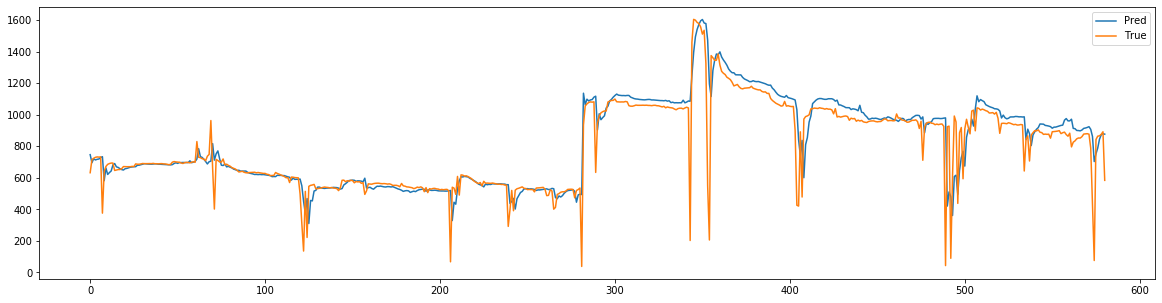

In [216]:
plt.figure(figsize=(20,5))
plt.plot(pred,label='Pred')
plt.plot(test[2],label='True')
plt.legend()

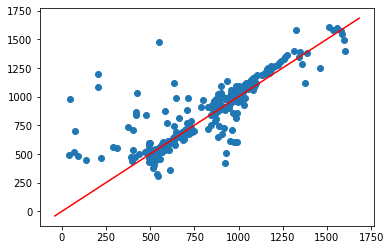

In [217]:
plt.scatter(test[2],pred)
ax=plt.gca()
x = np.linspace(*ax.get_xlim())
ax.plot(x, x,'r')

In [218]:
check_error(test[2],pred)

RMSE       124.301920
MAE         57.721931
R2           0.766936
MAE/range    0.036854

## Applying

In [219]:
dataset=production_well[name_list[2]]

In [220]:
apply_f1,apply_f2,apply_label=feature_target_future(dataset.values, dataset.values[:, targets], 0,
                                                 None, 5,ofi,
                                                 1, step=1)

In [221]:
apply=np.hstack([apply_f1,apply_f2,apply_label])
apply=drop_na_shutin(apply)

In [224]:
apply_final=convert_task_3_apply(None,None,apply,5)

In [225]:
pred=model.predict((apply_final[0],apply_final[1]))

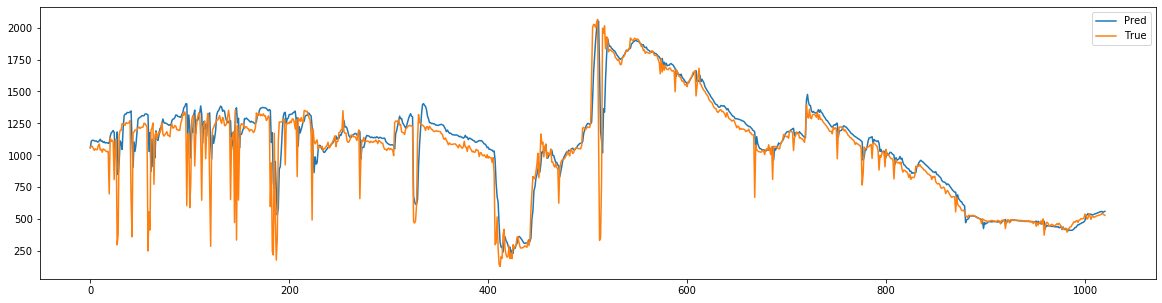

In [226]:
plt.figure(figsize=(20,5))
plt.plot(pred,label='Pred')
plt.plot(apply_final[2],label='True')
plt.legend()

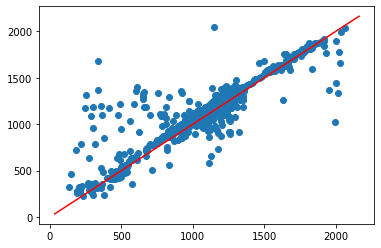

In [227]:
plt.scatter(apply_final[2],pred)
ax=plt.gca()
x = np.linspace(*ax.get_xlim())
ax.plot(x, x,'r')

In [228]:
check_error(apply_final[2],pred)

RMSE       158.219906
MAE         78.088445
R2           0.835700
MAE/range    0.040365